![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Final Paper Submission
# By Tatiana Bakwenye, Sebastien Boxho, Mikel Gallo and Joaquin Ossa

## Table of Contents
- [Part 0: Dataset Selection](#part-0-dataset-selection)
- [Part 1: Pre-processing](#part-1-setting-up-the-problem)
- [Part 3: State of the Art Comparison](#part-3-state-of-the-art-comparison)
  - [a. Full Dataset Training](#a-full-dataset-training)
  - [b. Learning Curve](#b-learning-curve)
  - [c. Technique Comparison](#c-technique-comparison)
  - [d. Methodology Analysis](#d-methodology-analysis)
- [Part 4: Model Distillation](#part-4-model-distillation)
  - [a. Model Distillation](#a-model-distillation)
  - [b. Performance and Speed Comparison](#b-performance-and-speed-comparison)
  - [c. Analysis and Improvements](#c-analysis-and-improvements)


# Setting Up the Problem

#### Objective: Understand and establish the baseline for your chosen dataset

In [1]:
!pip install datasets
!pip install ekphrasis
!pip install langchain
!pip install transformers==4.37.2
!pip install tensorflow==2.15.0
#!pip install OpenAI

In [2]:
import datasets
import time
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from transformers import TFDistilBertModel
from keras.utils import custom_object_scope
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
import random
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import spacy
sp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import string
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from keras.callbacks import EarlyStopping
from spacy.matcher import Matcher, PhraseMatcher
from tensorflow.keras import regularizers
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from langchain.chat_models import ChatOpenAI
from jinja2 import Template
from langchain.prompts import (
    AIMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Create a new Matcher
matcher = Matcher(sp.vocab)

## Class Proportion

def class_prop(label):
    train_class = pd.Series(label).value_counts().reset_index()
    #Rename columns
    train_class.columns = ['class', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    print(train_class[['class','count','perc']].round(4))

## Function for Based-Rule classifier
def classify_text(text):
    doc = sp(text)
    matches = matcher(doc)
    if matches:
        return matches  # Return the label of the first match
    else:
        return "UNKNOWN"  # If no match found

### DATA EXPLORATION
def freq_table(df,label):
    train_class = df[label].value_counts().reset_index()
    #Rename columns
    train_class.columns = ['category', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    return train_class[['category','count','perc']].round(4)

## Plot Metric Results
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

            # Adjust layout
            ax.set_xticklabels(self.results.keys(), rotation=55)

        plt.tight_layout()
        plt.show()

# Part 0: Dataset Selection

In [4]:
df = load_dataset("carblacac/twitter-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for carblacac/twitter-sentiment-analysis contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/carblacac/twitter-sentiment-analysis
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the ne

# Part 1: Setting Up the Problem

## a. Bibliography and SOA

## b. Dataset Description

##### TSATC: Twitter Sentiment Analysis Training Corpus     
Original DATASET contains 1,578,627 classified tweets (1 for positive and 0 for negative sentiment).

Our dataset has already been randomly sampled, cleaned, and split into training and testing sets. Both positive and negative classes are well balanced within each subset, and the training subset has been further divided into an 80% training set and a 20% validation set.  

This dataset is an aggregation of two twitter sentiment analysis datasets:  
- University of Michigan Sentiment Analysis competition on Kaggle: https://inclass.kaggle.com/c/si650winter11  
- Twitter Sentiment Corpus by Niek Sanders: http://www.sananalytics.com/lab/twitter-sentiment/

  
Languages: English

In [5]:
## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['feeling']

validation_data = df['validation']['text']
validation_labels = df['validation']['feeling']

test_data = df['test']['text']
test_labels = df['test']['feeling']

# Set the seed for reproducibility
np.random.seed(123)

# Define the percentage of data to use
sample_percentage = 0.05

# Sample 30% of the train data
sample_size = int(len(train_data) * sample_percentage)
train_sample_indices = random.sample(range(len(train_data)), sample_size)
train_data = [train_data[i] for i in train_sample_indices]
train_labels = [train_labels[i] for i in train_sample_indices]

# Sample 30% of the validation data
sample_size = int(len(validation_data) * sample_percentage)
validation_sample_indices = random.sample(range(len(validation_data)), sample_size)
validation_data = [validation_data[i] for i in validation_sample_indices]
validation_labels = [validation_labels[i] for i in validation_sample_indices]

# Sample 30% of the test data
sample_size = int(len(test_data) * sample_percentage)
test_sample_indices = random.sample(range(len(test_data)), sample_size)
test_data = [test_data[i] for i in test_sample_indices]
test_labels = [test_labels[i] for i in test_sample_indices]

## Creating Dataframes
df_train = pd.DataFrame({'text':train_data,'label':train_labels})
df_val = pd.DataFrame({'text':validation_data,'label':validation_labels})
df_test = pd.DataFrame({'text':test_data,'label':test_labels})

df

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### Dataset size

In [6]:
total_rows = len(train_labels) + len(test_labels) + len(validation_labels)
# Calculate train size including validation
Train_size = len(train_labels) + len(validation_labels)
# Calculate Summary
summary_df = pd.DataFrame({'SET': ['TRAIN','TEST', 'TOTAL'], 'ROWS': [Train_size, len(test_labels), total_rows], 'SPLIT': [Train_size/total_rows, len(test_labels)/total_rows,total_rows/total_rows]})
print('Dataset Split [TRAIN, TEST]')
display(summary_df.round(3))

## TRAIN SPLIT
summary_df_train = pd.DataFrame({'SET': ['train','validation', 'TRAIN'], 'ROWS': [len(train_labels), len(validation_labels), Train_size], 'SPLIT': [len(train_labels)/Train_size, len(validation_labels)/Train_size,Train_size/Train_size]})
print('TRAIN Split [train, validation]')
display(summary_df_train.round(3))

Dataset Split [TRAIN, TEST]


,SET,ROWS,SPLIT
0,TRAIN,7498,0.708
1,TEST,3099,0.292
2,TOTAL,10597,1.000


TRAIN Split [train, validation]


,SET,ROWS,SPLIT
0,train,5999,0.8
1,validation,1499,0.2
2,TRAIN,7498,1.0


### Class distribution

In [7]:
## Class balance of our datasets
print('train')
class_prop(train_labels)
print('validation')
class_prop(validation_labels)
print('test')
class_prop(test_labels)

train
   class  count    perc
0      1   3045  0.5076
1      0   2954  0.4924
validation
   class  count   perc
0      0    769  0.513
1      1    730  0.487
test
   class  count    perc
0      0   1560  0.5034
1      1   1539  0.4966


### Distribution of text lengths (train set only)

In [8]:
df_train['text_length']= [len(i.split()) for i in df_train['text']]
df_val['text_length']= [len(i.split()) for i in df_val['text']]
df_test['text_length']= [len(i.split()) for i in df_test['text']]
#Calculating Answer Length

In [9]:
for i in df_train['text'][0:5]:
    print(i.split(),'length: ', len(i.split()) )

['@KINGFISHER300', 'You', 'cant', 'just', 'pull', 'out', 'troops', 'like', 'that,', 'troops', 'protect', 'civilians', '(Women', 'and', 'children)', 'from', 'Militia', 'its', 'a', 'slow', 'process'] length:  21
['Such', 'a', 'shame', 'about', 'Jenson', 'but', 'well', 'done', 'to', 'vettel', 'webber', 'and', 'Barrichello'] length:  13
['@RockiesMLB', 'Sad', 'day'] length:  3
['about', 'to', 'cook'] length:  3
['@joeymcintyre', 'hey', 'i', 'saw', 'on', 'nkotb.com', 'some', 'people', 'didnt', 'know', 'where', 'the', 'bookdrive', 'booth', 'was.', 'TWIT', 'that', 'for', 'the', 'girlz', 'going', 'tonite!'] length:  22


Summary Statistics of text_length for positive(1) and negative(0) tweets
            mean  median       std  min  max
label                                       
0      13.596818    13.0  7.049648    1   57
1      12.946141    12.0  6.806340    1   42
   
Plot text_length distribution for positive(1) and negative(0) tweets


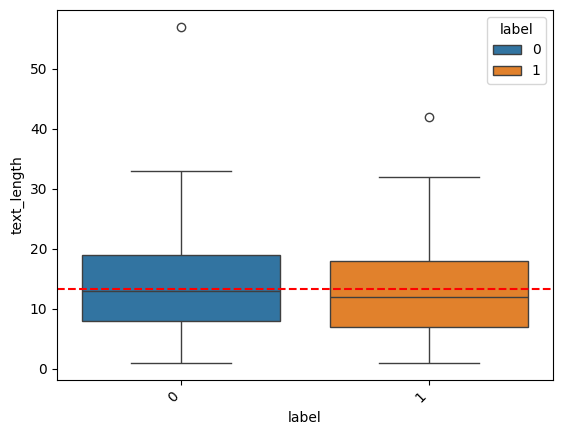

In [10]:
## Summary statistics for text_length
# Calculate multiple statistics
print('Summary Statistics of text_length for positive(1) and negative(0) tweets')
statistics = df_train.groupby('label')['text_length'].agg(['mean', 'median','std', 'min', 'max'])
# Display the result
print(statistics)

print('   ')

print('Plot text_length distribution for positive(1) and negative(0) tweets')
sns.boxplot(data=df_train, x='label', y='text_length',hue = 'label')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_train['text_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean text Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

## Data Cleaning
Twitter text requires multiple transformations prior to Preprocessing

In [11]:
# Create a TextPreProcessor instance
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used for word segmentation
    segmenter="twitter",
    # corpus from which the word statistics are going to be used for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text, with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons],
    #Remove emoticon
    pre_processor=[lambda x: x.replace('＼(^o^)／', '')]
)

# Pre-process the sentence using TextPreProcessor

def extract_clean(text):
    cleaned_text = ' '.join([word.split('<')[0] for word in text])
    return cleaned_text

def extract_emotions(text):
    emoji_expressions = [token for token in text if token in emoticons.values()]
    return emoji_expressions

def clean_string(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def flatten_emotions(emotion_list):
    # Convert the list of emotions into a string
    emotion_string = ', '.join(emotion_list)
    # Use regular expression to find all words inside angle brackets
    emotions = re.findall(r'<([^>]*)>', emotion_string)
    unique_emotions = list(set(emotions))
    combined_emotions = ', '.join(unique_emotions)
    return combined_emotions


def clean_text(df):
# Pre-process all the sentences in df_train['text']
    df['preprocessed_text'] = [text_processor.pre_process_doc(text) for text in df['text']]
    df['clean_text'] = df['preprocessed_text'].apply(extract_clean).apply(clean_string)

    #Getting Hashtags
    df['hashtag'] = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    df['hashtag'] = [' '.join(i) for i in df['hashtag']]

    # Iterate through the preprocessed text
    df['emotions'] = df['preprocessed_text'].apply(extract_emotions)
    df['clean_emotions'] = df['emotions'].apply(flatten_emotions)

    df = df[['text','label','text_length','clean_text','clean_emotions','hashtag']]
    return df

df_train = clean_text(df_train)
df_val = clean_text(df_val)
df_test = clean_text(df_test)

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


## DATA EXPLORATION

### Preprocessor

In [12]:
## Text mining - Preprocessing, CountVectorizing and tf-idf
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Convert text to lowercase
            #text = text.lower()
            text = "".join([char.lower() for char in text if char not in string.punctuation])
            # Tokenize text
            tokens = word_tokenize(text)
            # Remove stopwords and apply lemmatization
            filtered_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words]
            # Join tokens back into a string
            preprocessed_text = ' '.join(filtered_tokens)
            preprocessed_texts.append(preprocessed_text)

        return preprocessed_texts

In [13]:
sent = ['hello . ! my name is! test .. wuhoo']
pre =TextPreprocessor()
pre.fit(sent)
res = pre.transform(sent)
res

['hello name test wuhoo']

#### Exploring positive and negative words using WordCloud

In [14]:
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train['clean_text'])

Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

### TF-IDF Score

In [15]:
def tfidf_term(pipeline,df,sentiment):
# Access the CountVectorizer step from the pipeline
    count_vectorizer = pipeline.named_steps['vect']
    # Fit and transform the data
    tf_idf_pos_matrix = pipeline.transform(df[df['label']==sentiment]['clean_text'])
    # Convert count matrix to DataFrame
    vec_fr_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    #Creating a dictionary of frequencies for our terms
    feature_names = count_vectorizer.get_feature_names_out()
    # Calculate Term frequency dictionary
    term_tfidf = np.mean(vec_fr_mtx, axis=0)
    #Store in a dictionary
    tfidf_dict = {i: n for i, n in zip(feature_names, term_tfidf)}
    print(len(term_tfidf))
    return feature_names, term_tfidf, tfidf_dict


def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

# Example usage:
def plot_freq_top(df,top,pos):
    df = df.sort_values(by='score',ascending = False)
    df = df.head(top)
    #We are going to set the

    # Plot the top N terms and their TF-IDF scores
    plt.figure(figsize=(10, 6))
    plt.barh(df['terms'], df['score'], align='center')
    plt.yticks(df['terms'])
    plt.xlabel('Frequency Score')
    plt.title(pos.format(top))
    #plt.xlim(0,0.010)
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()

---

# Part 2: Data Scientist Challenge (only for the data no models about part 2 in this notebook)
## a. BERT Model with Limited Data

In the following exercises we will work with clean text.

In [16]:
train_data_clean = df_train['clean_text']
validation_data_clean = df_val['clean_text']
test_data_clean = df_test['clean_text']

In [17]:
# First, we'll select 32 random rows from the DataFrame using the sample method.
df_train_32 = df_train.sample(n=32)

In [18]:
train_data_32 = df_train_32['clean_text']
train_labels_32 = df_train_32['label']

### BERT SETUP

In [19]:
checkpoint="cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=  8 # impossible to have bigger batch as far as we have just 32 observations in the train
max_length= 40 # fine for the length of the sentences in our dataset - changed it according to the distribution
rate =     0.5 # dropout parameters - tried different options, 0.5 still performs better
num_labels = len(np.unique(validation_labels))

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [20]:
## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
output_layer = tf.keras.layers.Dropout(rate)(embedding_layer)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [21]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [22]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_32).reshape(-1, 1)).toarray()

## b. Dataset Augmentation

Text data augmentation approaches include:

+ Synonym Replacement: Replace words with their synonyms.
+ Random Insertion: Insert random words into the text.
+ Random Deletion: Randomly delete words from the text.
+ Random Swap: Swap two words randomly in the text.
+ Text Masking: Replace words or phrases with a mask token.

As far as we have very small dataset (DTM is of shape 32:305) I chose not to work with deletion or masking, but rather with synonyms. I thought of two approaches to do so:

### Data Augmentation: Manually Gathered Synonyms

First approach was to analyse the most common words associated with positive and negative sentiments and manually create a dictionary with synonyms. Then, I augmented data with 50 (tried more, but performance was worse, probably bacause of the limited variety of the changes and the fact, that probably misclassified observations could be misclassified now twice) observations and trained the same BERT with augmented data.

In [23]:
# I had slightly different approach, but changed it to Mikel's so to have the same logic throughout the notebook. Will have to move this and next cell to the first exercise later on.
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train_32['clean_text'])

Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

In [24]:
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)

302


In [25]:
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)

302


I got top 'most positive' and 'most negative' terms, manually chose some of them and assigned synonyms.

In [26]:
# Sort the dataframe by the 'score' column in decreasing order
neg_tf_idf_sorted = neg_tf_idf.sort_values(by='score', ascending=False)
pos_tf_idf_sorted = pos_tf_idf.sort_values(by='score', ascending=False)

# Extract the top 25 terms from the sorted dataframe
top_terms_neg = neg_tf_idf_sorted['terms'].head(25).tolist()
top_terms_pos = pos_tf_idf_sorted['terms'].head(25).tolist()

# Print the list of top 25 terms
print(top_terms_neg)
print(top_terms_pos)

['broken', 'computer', 'totally jeal', 'computer broken', 'totally', 'jeal', 'could', 'suck', 'dead', 'think', 'think flatiron', 'flatiron', 'flatiron dead', 'told could', 'told', 'made redundant', 'could made', 'redundant', 'racing fast', 'heart', 'heart racing', 'racing', 'fast', 'fast suck', 'provider']
['found', 'goodnight', 'everyone', 'goodnight everyone', 'getting', 'getting deal', 'deal', 'congrats', 'congrats getting', 'album', 'thanks', 'worth', 'go', 'great', 'done', 'outside', 'today nice', 'nice outside', 'today', 'nice', 'fishing today', 'fishing', 'made', 'go baby', 'way']


In [27]:
synonyms = {
    'go': ['move', 'travel', 'proceed', 'advance'],
    'envy': ['jealousy', 'resentment', 'desire'],
    'follower': ['adherent', 'disciple', 'supporter', 'devotee'],
    'want': ['desire', 'wish', 'crave', 'yearn'],
    'long': ['lengthy', 'extended', 'prolonged', 'distant'],
    'got': ['obtained', 'acquired', 'received', 'possessed'],
    'back': ['rear', 'behind', 'spine', 'reverse'],
    'hear': ['listen', 'perceive', 'catch', 'comprehend'],
    'woke': ['awake','conscious', 'comprehend'],
    'ago': ['in the past', 'back', 'before', 'previously'],
    'get back': ['retrieve', 'return', 'reclaim', 'regain'],
    'long ago': ['many years ago', 'ages ago', 'centuries ago'],
    'ghost image': ['phantom picture', 'spirit image'],
    'cry': ['weep', 'sob', 'shed tears'],
    'much': ['a lot', 'many', 'plenty', 'abundant'],
    'rock': ['stone', 'boulder', 'pebble', 'rocky'],
    'thank': ['express gratitude', 'show appreciation', 'give thanks', 'acknowledge'],
    'fair': ['just', 'acceptable', 'impartial', 'reasonable'],
    'enough': ['sufficient', 'adequate', 'plenty'],
    'like': ['enjoy', 'admire', 'favor', 'approve of'],
    'night': ['evening', 'darkness', 'nighttime', 'nocturnal'],
}

In [28]:
# Function to replace key word with a random synonym
def replace_with_synonym(text, synonyms_dict):
    words = text.split()
    for i, word in enumerate(words):
        if word in synonyms_dict:
            synonyms = synonyms_dict[word]
            # Randomly select a synonym
            new_word = random.choice(synonyms)
            # Replace the key word with the selected synonym
            words[i] = new_word
    return ' '.join(words)

# Initialize an empty DataFrame to store new observations
new_rows = pd.DataFrame(columns=df_train_32.columns)

# Generate additional 50 rows
while len(new_rows) < 50:
    # Identify rows with words from synonyms dictionary
    relevant_rows = df_train_32[df_train_32['clean_text'].apply(lambda x: any(word in synonyms for word in x.split()))]
    # Duplicate each relevant row and replace key word with synonym
    for idx, row in relevant_rows.iterrows():
        new_row = row.copy()
        new_row['clean_text'] = replace_with_synonym(row['clean_text'], synonyms)
        new_rows = new_rows.append(new_row, ignore_index=True)
        if len(new_rows) >= 50:
            break

# Display the new DataFrame with 50 new rows
new_rows.head(10)

<ipython-input-28-383be659130a>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


,text,label,text_length,clean_text,clean_emotions,hashtag
0,@laurengj you're so much better at twitter tha...,0,16,you are so a lot better at twitter than me ! i...,,
1,@josevillanueva sorry i couldn't go to the Lun...,0,9,sorry i could not travel to the luna bean,,
2,"@aaronriveroll ha ha. No, I meant they are sti...",0,17,"ha ha . no , i meant they are still under cons...",,
3,Ladytsuki is waiting me to go to their house.....,1,15,ladytsuki is waiting me to advance to their ho...,,
4,has just got some work done woot Now off to t...,1,19,has just received some work done woot now off ...,,
5,Stuff like this just isn't supposed to happen!...,0,17,stuff admire this just is not supposed to happ...,,
6,@adamm9 yeah! Way to go baby. So proud of you.,1,10,yeah ! way to proceed baby . so proud of you .,,
7,I want more ice cream but the box is empty #m...,0,11,i desire more ice cream but the box is empty m...,,moosetracks
8,@laurengj you're so much better at twitter tha...,0,16,you are so abundant better at twitter than me ...,,
9,@josevillanueva sorry i couldn't go to the Lun...,0,9,sorry i could not advance to the luna bean,,


In [29]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame shape
print(augmented_df.shape)

(82, 6)


In [30]:
# Define data and labels
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

Note, that we will work with the same BERT model, so I will not change anything in the model architecture.

### Data Augmentation: Synonyms from WordNet

I didn't choose to work with WordNet packages in the beginning, as far as synonyms look kind of random and don't usually properly reflect the meaning of the word (probably because of multiple meanings) and don't consider the context. But as far as I couldn't manually assign synonyms to all (or at least many) tokens, I decided to try WordNet as well.

So the second approach is to rendomly change 30% of the tokens in the comments (I tried different shares, 30% performed better) and add 32*20 (tried different numbers as well) new rows.

In [31]:
# Function to get synonyms from WordNet
def get_wordnet_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

# Function to replace random words with WordNet synonyms
def replace_with_synonym_wordnet(text):
    words = text.split()
    for i, word in enumerate(words):
        # Randomly decide whether to replace the word with a synonym
        if random.random() < 0.3:  # Adjust the probability as needed
            # Get WordNet synonyms for the word
            synonyms = get_wordnet_synonyms(word)
            if synonyms:
                # Randomly select a synonym
                new_word = random.choice(synonyms)
                # Replace the word with the selected synonym
                words[i] = new_word
    return ' '.join(words)

# Duplicate each row and replace random words with WordNet synonyms
new_rows = pd.DataFrame(columns=df_train_32.columns)
for idx, row in df_train_32.iterrows():
    for _ in range(20):  # Duplicate 20 times - can be adjusted as needed
        # Duplicate the row
        new_row = row.copy()
        # Replace random words in the 'clean_text' column with WordNet synonyms
        new_row['clean_text'] = replace_with_synonym_wordnet(row['clean_text'])
        # Append the new row to the DataFrame
        new_rows = new_rows.append(new_row, ignore_index=True)

# Display the new DataFrame with duplicated rows and random word replacements
new_rows.head(10)

<ipython-input-31-5f1b6b51e9c4>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


,text,label,text_length,clean_text,clean_emotions,hashtag
0,@hudgensness those pics look really great Ho...,1,13,those pics look really great hope you to have ...,,
1,@hudgensness those pics look really great Ho...,1,13,those picture look really great hope you to ha...,,
2,@hudgensness those pics look really great Ho...,1,13,those pics look real great hope you to get vit...,,
3,@hudgensness those pics look really great Ho...,1,13,those pics look genuinely neat hope you to hav...,,
4,@hudgensness those pics look really great Ho...,1,13,those pics look really great hope you to hold ...,,
5,@hudgensness those pics look really great Ho...,1,13,those pics depend truly corking hope you to ha...,,
6,@hudgensness those pics look really great Ho...,1,13,those flick look really great hope you to have...,,
7,@hudgensness those pics look really great Ho...,1,13,those pics look really great hope you to have ...,,
8,@hudgensness those pics look really great Ho...,1,13,those pics expect truly great hope you to have...,,
9,@hudgensness those pics look really great Ho...,1,13,those motion_picture looking_at really large h...,,


From the printed first rows you actually may see (comparing text and clean text, which was duplicated), that synonyms are kind of weird.

In [32]:
# Add new_rows to df_train_32
augmented_w_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame
print(augmented_w_df.shape)

(672, 6)


In [33]:
augmented_w_df_data = augmented_w_df['clean_text']
augmented_w_df_label = augmented_w_df['label']

---

# c. Zero-Shot Learning with LLM
#### For the Zero-Shot setup we found different LLM models from Huggingface which we tried to see which one gave us the best accuracy testing them with the validation data. Finally it was "facebook/bart-large-mnli" the one it gave us the best results

In [34]:
from transformers import pipeline
model_name = "facebook/bart-large-mnli"  # Adjust model name as needed

df_val_sampled = df_val.sample(n=299, random_state=42)
sampled_list1 = (df_val_sampled['text']).tolist()

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ['positive', 'negative']

# Store the predictions for each item in a list
predictions = []

# Iterate over each text sample in test_data
for text_sample in sampled_list1:
    # Use the classifier pipeline to predict the label
    result = classifier(text_sample, candidate_labels)

    # Get the label with the highest score
    if result['scores'][0] >= result['scores'][1]:
        predicted_label = result['labels'][0]
    else:
        predicted_label = result['labels'][1]

    # Append the predicted label to the predictions list
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

['positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'po

In [35]:
zero_predictions = [1 if prediction == 'positive' else 0 for prediction in predictions]

# Update the "label" column with values from sampled_list2
df_val_sampled['label'] = zero_predictions

# Display the updated DataFrame
df_val_sampled.head()

,text,label,text_length,clean_text,clean_emotions,hashtag
1116,"@dannykurily aww dear danny, feel better! &lt;3",1,7,"aww dear danny , feel better !",,
1395,"@nimbupani : Yup, that's when I realized I was...",0,26,": yup , that ' s when i realized i was in the ...",,
422,Nooooooo... why did aar get moved to club 101,0,9,no . why did aar get moved to club,,
413,Highlight of my Sunday: got to go on my long b...,1,30,highlight of my sunday : got to go on my long ...,,
451,@yasexy ur faky givin u a run for ya money!!! ...,0,21,ur faky givin u a run for ya money ! hang in t...,,


#### Now we train our Roberta model once again adding the data obtained with Zero-Shot to the 32 labeled

In [36]:
# Add new_rows to df_train_32
augmented_zero_df = pd.concat([df_train_32, df_val_sampled], ignore_index=True)

# Display the augmented DataFrame
print(augmented_zero_df.shape)

(331, 6)


In [37]:
augmented_zero_df_data = augmented_zero_df['clean_text']
augmented_zero_df_label = augmented_zero_df['label']

#### We get a very big increase in the performance of our model, probably because of the size of the data, since we were training our model with only 32 samples and now we are adding 300 more samples, even though they are not 100% accurate, is still gives a lot more information for the model to work better

---

# d. Data Generation with LLM

In [38]:
# Load csv file containing the generated tweets
df = pd.read_csv("/content/gpt_tweets.csv")

df['Context'] = df['Context'].str.strip()
df.rename(columns={'Tweet': 'text', 'Sentiment': 'label'}, inplace=True)

In [39]:
# Inspect Data
print(df.shape)
df.isna().sum()

(1135, 3)


text       0
label      0
Context    0
dtype: int64

In [40]:
df['text_length'] = 0
df = clean_text(df)

train_data_generated = df["text"]
train_labels_generated = df["label"]

---

# Part 3: State of the Art Comparison

## a. Full Dataset Training

In [41]:
metrics_comp = Metrics()

In [42]:
# Define observation shares
observation_shares = [0.01, 0.10, 0.25, 0.5, 0.75, 1]

# List to store validation predictions for all models
all_valid_preds = []

# List to store histories for all models
all_histories = []

for share in observation_shares:
    # Calculate the number of observations
    obs_count = int(len(df_train) * share)

    # Sample from the DataFrame
    df_train_sampled = df_train.sample(n=obs_count)

    # Extract features and labels
    train_data_sampled = df_train_sampled['clean_text']
    train_labels_sampled = df_train_sampled['label']

    # One-hot encode the labels
    y_train_sampled = enc.fit_transform(np.array(train_labels_sampled).reshape(-1, 1)).toarray()

    # Convert validation labels to one-hot encoding
    y_valid = enc.transform(np.array(validation_labels).reshape(-1, 1)).toarray()

    # Define steps per epoch
    steps_per_epoch = int(len(train_data)/batch_size)

    # Generate batches for training data
    train_batches = get_batches(train_data_sampled, y_train_sampled, tokenizer, batch_size, max_length)

    # Generate batches for validation data
    valid_batches = get_batches(validation_data, y_valid, tokenizer, batch_size, max_length)

    # Compile the model
    bert_model.compile(
        optimizer=Adam(2e-5),
        metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
        loss=tf.keras.losses.CategoricalCrossentropy()
    )

    # Train the model and record the history
    history = bert_model.fit(
        train_batches,
        epochs=5,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_batches,
        validation_steps=len(validation_data) // batch_size,
    )
    #callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

    # Append the history to the list
    all_histories.append(history)

    # Get the inputs tokenized from the validation set
    inputs = tokenizer.batch_encode_plus(list(test_data),
                                         add_special_tokens=True,
                                         max_length=max_length,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_token_type_ids=True,
                                         truncation=True)

    # Extract input_ids and attention mask
    inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
                    np.asarray(inputs['attention_mask'], dtype='int32')]

    # Get predictions for the validation set
    valid_preds = bert_model.predict(inputs_valid)
    valid_preds = np.argmax(valid_preds, axis=1)

    # Append predictions to the list
    all_valid_preds.append(valid_preds)
    metrics_comp.run(test_labels, valid_preds, f"share_{int(share * 100)}%")
    tf.keras.backend.clear_session()

Epoch 1/5


749/749 [==============================] - 589s 747ms/step - loss: 0.0341 - recall: 0.9868 - precision: 0.9868 - val_loss: 1.4982 - val_recall: 0.7774 - val_precision: 0.7774
Epoch 2/5
749/749 [==============================] - 542s 724ms/step - loss: 5.6483e-05 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.6868 - val_recall: 0.7780 - val_precision: 0.7780
Epoch 3/5
749/749 [==============================] - 550s 734ms/step - loss: 2.0588e-05 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.7985 - val_recall: 0.7767 - val_precision: 0.7767
Epoch 4/5
749/749 [==============================] - 546s 729ms/step - loss: 1.2583e-05 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9020 - val_recall: 0.7760 - val_precision: 0.7760
Epoch 5/5
97/97 [==============================] - 39s 367ms/step
Epoch 1/5


749/749 [==============================] - 581s 736ms/step - loss: 0.1594 - recall: 0.9423 - precision: 0.9423 - val_loss: 1.2354 - val_recall: 0.8168 - val_precision: 0.8168
Epoch 2/5
749/749 [==============================] - 533s 711ms/step - loss: 0.0316 - recall: 0.9903 - precision: 0.9903 - val_loss: 1.1807 - val_recall: 0.8176 - val_precision: 0.8176
Epoch 3/5
749/749 [==============================] - 526s 702ms/step - loss: 0.0066 - recall: 0.9980 - precision: 0.9980 - val_loss: 1.5718 - val_recall: 0.8176 - val_precision: 0.8176
Epoch 4/5
749/749 [==============================] - 528s 705ms/step - loss: 0.0052 - recall: 0.9982 - precision: 0.9982 - val_loss: 1.6358 - val_recall: 0.8142 - val_precision: 0.8142
Epoch 5/5
97/97 [==============================] - 37s 350ms/step
Epoch 1/5


749/749 [==============================] - 604s 769ms/step - loss: 0.2832 - recall: 0.8974 - precision: 0.8974 - val_loss: 0.8468 - val_recall: 0.8122 - val_precision: 0.8122
Epoch 2/5
749/749 [==============================] - 585s 781ms/step - loss: 0.0403 - recall: 0.9861 - precision: 0.9861 - val_loss: 0.9054 - val_recall: 0.8249 - val_precision: 0.8249
Epoch 3/5
749/749 [==============================] - 517s 690ms/step - loss: 0.0215 - recall: 0.9925 - precision: 0.9925 - val_loss: 1.2094 - val_recall: 0.8135 - val_precision: 0.8135
Epoch 4/5
749/749 [==============================] - 518s 691ms/step - loss: 0.0284 - recall: 0.9906 - precision: 0.9906 - val_loss: 1.1065 - val_recall: 0.8122 - val_precision: 0.8122
Epoch 5/5
97/97 [==============================] - 35s 332ms/step
Epoch 1/5


749/749 [==============================] - 550s 700ms/step - loss: 0.2729 - recall: 0.9012 - precision: 0.9012 - val_loss: 0.5972 - val_recall: 0.8162 - val_precision: 0.8162
Epoch 2/5
749/749 [==============================] - 526s 702ms/step - loss: 0.0835 - recall: 0.9736 - precision: 0.9736 - val_loss: 0.7873 - val_recall: 0.8216 - val_precision: 0.8216
Epoch 3/5
749/749 [==============================] - 520s 695ms/step - loss: 0.0409 - recall: 0.9871 - precision: 0.9871 - val_loss: 0.8770 - val_recall: 0.8343 - val_precision: 0.8343
Epoch 4/5
749/749 [==============================] - 519s 693ms/step - loss: 0.0237 - recall: 0.9927 - precision: 0.9927 - val_loss: 1.0876 - val_recall: 0.8317 - val_precision: 0.8317
Epoch 5/5
97/97 [==============================] - 36s 336ms/step
Epoch 1/5


749/749 [==============================] - 556s 703ms/step - loss: 0.1786 - recall: 0.9440 - precision: 0.9440 - val_loss: 0.5844 - val_recall: 0.8289 - val_precision: 0.8289
Epoch 2/5
749/749 [==============================] - 526s 703ms/step - loss: 0.0748 - recall: 0.9748 - precision: 0.9748 - val_loss: 0.7974 - val_recall: 0.8256 - val_precision: 0.8256
Epoch 3/5
749/749 [==============================] - 620s 828ms/step - loss: 0.0420 - recall: 0.9885 - precision: 0.9885 - val_loss: 0.8796 - val_recall: 0.8216 - val_precision: 0.8216
Epoch 4/5
749/749 [==============================] - 527s 703ms/step - loss: 0.0341 - recall: 0.9870 - precision: 0.9870 - val_loss: 0.9123 - val_recall: 0.8223 - val_precision: 0.8223
Epoch 5/5
97/97 [==============================] - 35s 333ms/step
Epoch 1/5


749/749 [==============================] - 555s 707ms/step - loss: 0.0956 - recall: 0.9706 - precision: 0.9706 - val_loss: 0.5703 - val_recall: 0.8142 - val_precision: 0.8142
Epoch 2/5
749/749 [==============================] - 510s 681ms/step - loss: 0.0440 - recall: 0.9870 - precision: 0.9870 - val_loss: 0.9145 - val_recall: 0.8417 - val_precision: 0.8417
Epoch 3/5
749/749 [==============================] - 506s 675ms/step - loss: 0.0313 - recall: 0.9886 - precision: 0.9886 - val_loss: 0.9402 - val_recall: 0.8370 - val_precision: 0.8370
Epoch 4/5
749/749 [==============================] - 512s 683ms/step - loss: 0.0321 - recall: 0.9900 - precision: 0.9900 - val_loss: 0.8448 - val_recall: 0.8337 - val_precision: 0.8337
Epoch 5/5
97/97 [==============================] - 35s 331ms/step


## b. Learning Curve

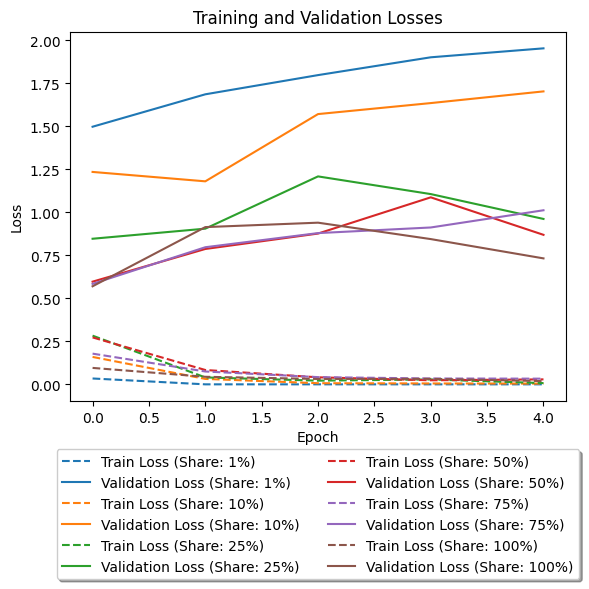

In [43]:
# Define a colormap with enough distinct colors
colors = plt.cm.tab10.colors

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot losses for all histories
for i, history in enumerate(all_histories):
    # Extract training and validation losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot training and validation losses with appropriate color
    color_index = i % len(colors)
    ax.plot(train_loss, label=f'Train Loss (Share: {int(observation_shares[i] * 100)}%)', linestyle='--', color=colors[color_index])
    ax.plot(val_loss, label=f'Validation Loss (Share: {int(observation_shares[i] * 100)}%)', color=colors[color_index])

# Set title and labels
ax.set_title('Training and Validation Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)  # Moving legend to the bottom

# Show plot
plt.show()

<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


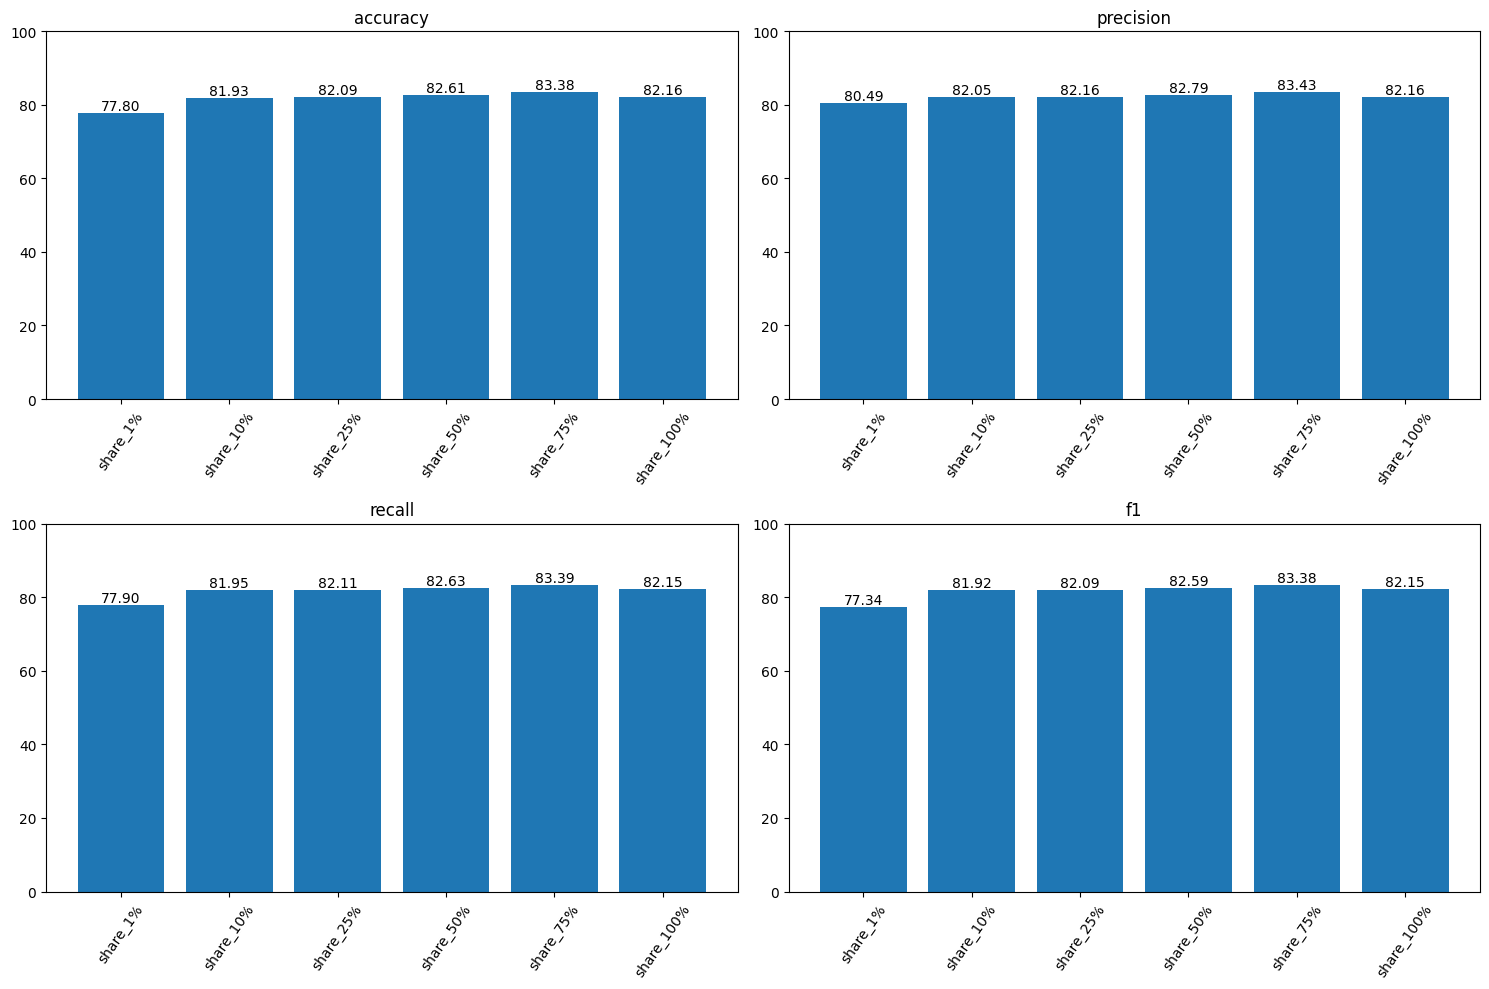

In [44]:
metrics_comp.plot()

As expected, we can observe a trend of increasing performance with the expansion of the training dataset, attributed to the provision of more diverse and representative examples. This enables the model to learn more robust patterns and relationships, consequently enhancing its predictive accuracy and generalization capability. However, beyond a certain point, the improvement becomes less significant, and the model may reach a stagnation where additional data fails to introduce substantial new variety for further learning

## c. Technique Comparison
## Pre-train the (freezed) model with the different techniques explored before

In [45]:
# Apply the different techniques and compare their perfromance
# 1. 32 label, 2. Synonyms, 3. Zero Shot, 4. LLM Tweets
techniques_names = ["32 Labels","Augmented Synonyms","Zero Shot","Generated Tweets"]
techniques = [[train_data_32,train_labels_32],[augmented_w_df_data,augmented_w_df_label],[augmented_zero_df_data, augmented_zero_df_label],[train_data_generated,train_labels_generated]]

In [46]:
histories = []
teacher_model = None
best_loss = float('inf')
i = 0

for train_tec,y_tec in techniques:
    print("Model :",techniques_names[i])
    model_tec = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
    # To freeze BERT parameters (look at the trainable parameters below)
    model_tec.layers[2].trainable = False

    X_train = np.array(train_tec)

    y_train = enc.fit_transform(np.array(y_tec).reshape(-1, 1)).toarray()

    steps_per_epoch = int(len(X_train)/batch_size)

    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    model_tec.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

    print("Fit Freezed layer...")
    model_tec.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)

    # Test the model
    test_preds = model_tec.predict(inputs_valid)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_comp.run(test_labels, test_preds, f"Froozen + {techniques_names[i]}")

    print("Fit unfreezd layer...")
    model_tec.layers[2].trainable = True

    steps_per_epoch = int(len(train_data)/batch_size)
    X_train = np.array(train_data_clean)

    y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

    # Train on the whole NN
    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    model_tec.compile(optimizer=Adam(2e-5),
                      metrics=[tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision()],
                      loss=tf.keras.losses.CategoricalCrossentropy())

    history = model_tec.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)
    loss_ = history.history['loss'][-1]
    histories.append(history)

    if best_loss > loss_:
      best_loss = loss_
      teacher_model = tf.keras.models.clone_model(model_tec)

    # Test unfreezed model
    test_preds = model_tec.predict(inputs_valid)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_comp.run(test_labels, test_preds, f"Unfrozen {techniques_names[i]}")
    tf.keras.backend.clear_session()
    i = i+1

Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
4/4 [==============================] - 14s 153ms/step - loss: 0.0091 - recall: 1.0000 - precision: 1.0000
Epoch 2/2
97/97 [==============================] - 35s 334ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 506s 639ms/step - loss: 0.0265 - recall_1: 0.9908 - precision_1: 0.9908
Epoch 2/2
97/97 [==============================] - 46s 442ms/step
Model : Augmented Synonyms
Fit Freezed layer...
Epoch 1/2
84/84 [==============================] - 26s 152ms/step - loss: 0.1134 - recall: 0.9792 - precision: 0.9792
Epoch 2/2
97/97 [==============================] - 37s 349ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 551s 695ms/step - loss: 0.0201 - recall_1: 0.9947 - precision_1: 0.9947
Epoch 2/2
97/97 [==============================] - 38s 359ms/step
Model : Zero Shot
Fit Freezed layer...
Epoch 1/2
41/41 [==============================] - 19s 160ms/step - loss: 1.3074 - recall: 0.7988 - precision: 0.7988
Epoch 2/2
97/97 [==============================] - 38s 364ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 571s 722ms/step - loss: 0.0265 - recall_1: 0.9920 - precision_1: 0.9920
Epoch 2/2
97/97 [==============================] - 38s 364ms/step
Model : Generated Tweets
Fit Freezed layer...
Epoch 1/2
141/141 [==============================] - 33s 150ms/step - loss: 1.4753 - recall: 0.7660 - precision: 0.7660
Epoch 2/2
97/97 [==============================] - 38s 333ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 519s 660ms/step - loss: 0.0173 - recall_1: 0.9953 - precision_1: 0.9953
Epoch 2/2
97/97 [==============================] - 35s 334ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


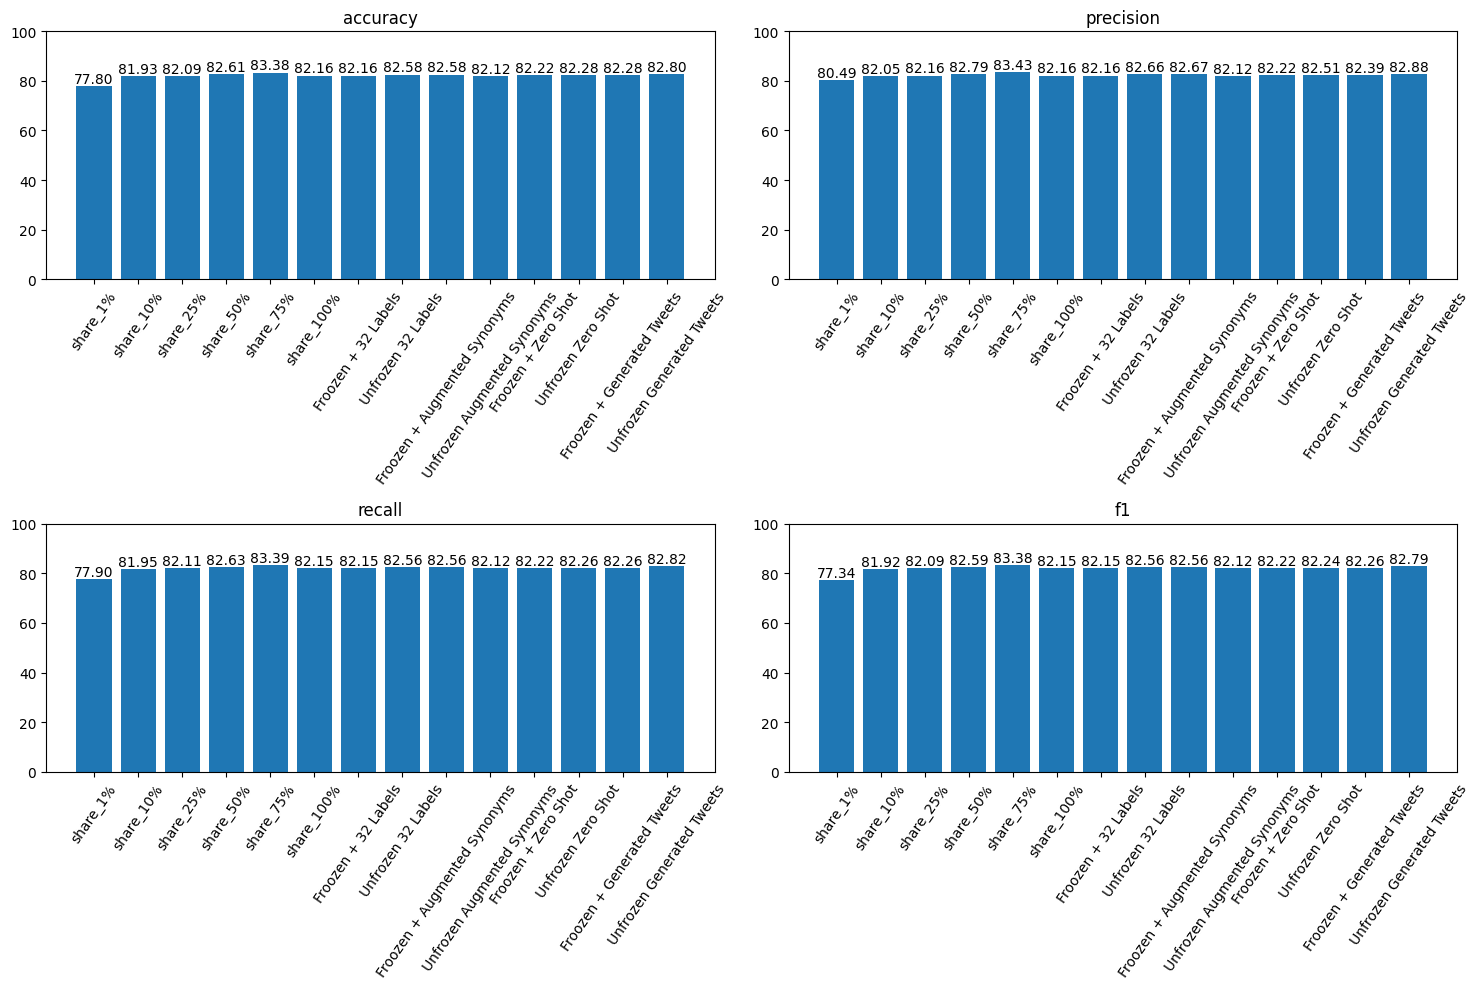

In [47]:
metrics_comp.plot()

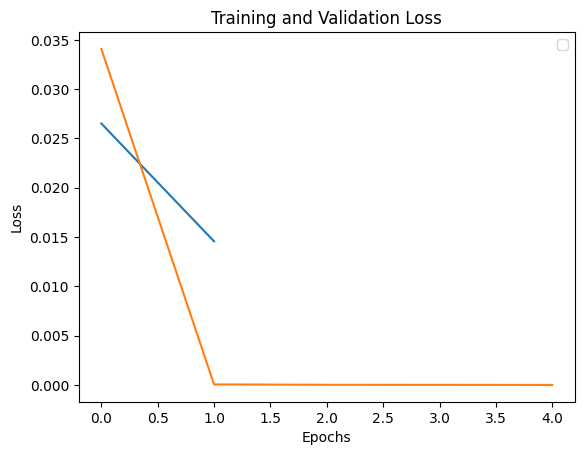

In [48]:
# Plot of the loss curve of the best model from the (1%,5%,10%...) vs the best model incorporating one of the data augmentation techniques
def plot_best_history():
    best_history1 = min(histories, key=lambda x: min(x.history['loss']))
    best_history2 = min(all_histories, key=lambda x: min(x.history['loss']))
    plt.plot(best_history1.history['loss'] )
    plt.plot(best_history2.history['loss'] )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot best history for histories
plot_best_history()

## d. Methodology Analysis

Our approach to improve the model was trying with all the techniques used on part 2 and see how well they compared vs the model with 100% real data. We noticed that in general the performance of the model increases with this techniques, were we can highlight Zero-Shot as the most effective one, but they show worst improvements compared to increasing the size of the real training data. This is most likely because this techniques can just offer data that could be biased, very simple or limited.

In comparison to the SOA model (Roberta) ours performs worse, despite the fact that we are using this Roberta model as our base. When doing a more detailed analysis we realized that the data used in the training of Roberta, the dataset was greatly imbalanced, having nearly a 90% of positive data and just 10% negative. Considering this we concluded that the performance of our model is within the expected performance, we even tried the SOA model in HuggingFace and we got similar results to what we show here.

# Part 4: Model Distillation
## a. Model Distillation

The best model being the one using the generated tweets from ChatGPT we will initialise this model as the teacher model:

In [55]:
student_metrics = Metrics()

teacher_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

# Freez Bert model
model_tec.layers[2].trainable = False

X_train = np.array(train_data_generated)

y_train = enc.fit_transform(np.array(train_labels_generated).reshape(-1, 1)).toarray()

steps_per_epoch = int(len(X_train)/batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

teacher_model.compile(optimizer=Adam(2e-5),
                metrics=[tf.keras.metrics.Recall(),
                tf.keras.metrics.Precision()],
                loss=tf.keras.losses.CategoricalCrossentropy())

print("Fit Freezed layer...")
teacher_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)

# Test the model
test_preds = teacher_model.predict(inputs_valid)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
student_metrics.run(test_labels, test_preds, "Teacher Model - froozen")

print("Fit unfreezd layer...")
teacher_model.layers[2].trainable = True

steps_per_epoch = int(len(train_data)/batch_size)
X_train = np.array(train_data_clean)

y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

# Train on the whole NN
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

teacher_model.compile(optimizer=Adam(2e-5),
                  metrics=[tf.keras.metrics.Recall(),
                  tf.keras.metrics.Precision()],
                  loss=tf.keras.losses.CategoricalCrossentropy())

history = teacher_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)

# Test unfreezed model
start = time.time()
test_preds = teacher_model.predict(inputs_valid)
test_preds = np.argmax(test_preds, axis=1)
end = time.time()

# get the final metrics
student_metrics.run(test_labels, test_preds, "Teacher model - unfroozen")

Fit Freezed layer...
Epoch 1/2


141/141 [==============================] - 107s 629ms/step - loss: 0.2993 - recall_3: 0.8706 - precision_3: 0.8706
Epoch 2/2
97/97 [==============================] - 24s 229ms/step
Fit unfreezd layer...
Epoch 1/2


749/749 [==============================] - 431s 555ms/step - loss: 0.4332 - recall_4: 0.8082 - precision_4: 0.8082
Epoch 2/2
97/97 [==============================] - 18s 175ms/step


In [56]:
class Distiller(tf.keras.Model):

    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3,):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False):

        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature, axis=1),
            tf.nn.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


In [57]:
# Create the student model on "distilbert/distilroberta-base"
checkpoint_distil="distilbert/distilroberta-base"
tokenizer_distil = AutoTokenizer.from_pretrained(checkpoint_distil)
model_distil = TFAutoModel.from_pretrained(checkpoint_distil)

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model_distil(input_ids_in, attention_mask=input_masks_in)[0][:, 0, :]
output_layer = tf.keras.layers.Dropout(rate)(embedding_layer)
output = tf.keras.layers.Dense(num_labels, kernel_initializer="glorot_uniform", activation='softmax')(output_layer)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


model_distil = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

model_distil.summary()
student = model_distil

student.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   8211840   ['input_token[0][0]',         
 rtaModel)                   ngAndCrossAttentions(last_   0          'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [58]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher_model)
distiller.compile(
    optimizer=Adam(2e-5),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)
batches_with_progress = tqdm_generator(batches, steps_per_epoch)
# Distill teacher to student
distiller.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/749 [00:00<?, ?it/s]

Epoch 1/2



Epoch:   0%|          | 1/749 [00:28<5:57:01, 28.64s/it]

  1/749 [..............................] - ETA: 6:01:25 - recall_6: 0.6250 - precision_6: 0.6250


Epoch:   0%|          | 3/749 [00:29<1:35:13,  7.66s/it]

  2/749 [..............................] - ETA: 9:59 - recall_6: 0.5625 - precision_6: 0.5625   


Epoch:   1%|          | 4/749 [00:30<1:05:37,  5.28s/it]

  3/749 [..............................] - ETA: 9:29 - recall_6: 0.5000 - precision_6: 0.5000


Epoch:   1%|          | 5/749 [00:30<46:49,  3.78s/it]  

  4/749 [..............................] - ETA: 9:35 - recall_6: 0.5000 - precision_6: 0.5000


Epoch:   1%|          | 6/749 [00:31<34:53,  2.82s/it]

  5/749 [..............................] - ETA: 9:44 - recall_6: 0.4500 - precision_6: 0.4500


Epoch:   1%|          | 7/749 [00:32<27:06,  2.19s/it]

  6/749 [..............................] - ETA: 9:53 - recall_6: 0.4375 - precision_6: 0.4375


Epoch:   1%|          | 8/749 [00:33<21:57,  1.78s/it]

  7/749 [..............................] - ETA: 9:51 - recall_6: 0.4286 - precision_6: 0.4286


Epoch:   1%|          | 9/749 [00:34<18:12,  1.48s/it]

  8/749 [..............................] - ETA: 9:45 - recall_6: 0.4375 - precision_6: 0.4375


Epoch:   1%|▏         | 10/749 [00:34<15:23,  1.25s/it]

  9/749 [..............................] - ETA: 9:41 - recall_6: 0.4444 - precision_6: 0.4444


Epoch:   1%|▏         | 11/749 [00:35<13:32,  1.10s/it]

 10/749 [..............................] - ETA: 9:36 - recall_6: 0.4500 - precision_6: 0.4500


Epoch:   2%|▏         | 12/749 [00:36<12:10,  1.01it/s]

 11/749 [..............................] - ETA: 9:35 - recall_6: 0.4545 - precision_6: 0.4545


Epoch:   2%|▏         | 13/749 [00:37<11:21,  1.08it/s]

 12/749 [..............................] - ETA: 9:32 - recall_6: 0.4688 - precision_6: 0.4688


Epoch:   2%|▏         | 14/749 [00:37<10:40,  1.15it/s]

 13/749 [..............................] - ETA: 9:29 - recall_6: 0.4519 - precision_6: 0.4519


Epoch:   2%|▏         | 15/749 [00:38<10:11,  1.20it/s]

 14/749 [..............................] - ETA: 9:23 - recall_6: 0.4643 - precision_6: 0.4643


Epoch:   2%|▏         | 16/749 [00:39<09:38,  1.27it/s]

 15/749 [..............................] - ETA: 9:22 - recall_6: 0.4583 - precision_6: 0.4583


Epoch:   2%|▏         | 17/749 [00:39<09:28,  1.29it/s]

 16/749 [..............................] - ETA: 9:21 - recall_6: 0.4531 - precision_6: 0.4531


Epoch:   2%|▏         | 18/749 [00:40<09:25,  1.29it/s]

 17/749 [..............................] - ETA: 9:18 - recall_6: 0.4412 - precision_6: 0.4412


Epoch:   3%|▎         | 19/749 [00:41<09:14,  1.32it/s]

 18/749 [..............................] - ETA: 9:17 - recall_6: 0.4375 - precision_6: 0.4375


Epoch:   3%|▎         | 20/749 [00:42<09:13,  1.32it/s]

 19/749 [..............................] - ETA: 9:16 - recall_6: 0.4276 - precision_6: 0.4276


Epoch:   3%|▎         | 21/749 [00:42<09:11,  1.32it/s]

 20/749 [..............................] - ETA: 9:14 - recall_6: 0.4250 - precision_6: 0.4250


Epoch:   3%|▎         | 22/749 [00:43<09:01,  1.34it/s]

 21/749 [..............................] - ETA: 9:13 - recall_6: 0.4107 - precision_6: 0.4107


Epoch:   3%|▎         | 23/749 [00:44<09:05,  1.33it/s]

 22/749 [..............................] - ETA: 9:12 - recall_6: 0.4148 - precision_6: 0.4148


Epoch:   3%|▎         | 24/749 [00:45<09:05,  1.33it/s]

 23/749 [..............................] - ETA: 9:10 - recall_6: 0.4130 - precision_6: 0.4130


Epoch:   3%|▎         | 25/749 [00:45<08:56,  1.35it/s]

 24/749 [..............................] - ETA: 9:09 - recall_6: 0.4219 - precision_6: 0.4219


Epoch:   3%|▎         | 26/749 [00:46<08:57,  1.34it/s]

 25/749 [>.............................] - ETA: 9:07 - recall_6: 0.4250 - precision_6: 0.4250


Epoch:   4%|▎         | 27/749 [00:47<08:52,  1.36it/s]

 26/749 [>.............................] - ETA: 9:06 - recall_6: 0.4423 - precision_6: 0.4423


Epoch:   4%|▎         | 28/749 [00:48<08:54,  1.35it/s]

 27/749 [>.............................] - ETA: 9:06 - recall_6: 0.4398 - precision_6: 0.4398


Epoch:   4%|▍         | 29/749 [00:48<09:02,  1.33it/s]

 28/749 [>.............................] - ETA: 9:05 - recall_6: 0.4464 - precision_6: 0.4464


Epoch:   4%|▍         | 30/749 [00:49<09:01,  1.33it/s]

 29/749 [>.............................] - ETA: 9:07 - recall_6: 0.4526 - precision_6: 0.4526


Epoch:   4%|▍         | 31/749 [00:50<09:18,  1.29it/s]

 30/749 [>.............................] - ETA: 9:06 - recall_6: 0.4500 - precision_6: 0.4500


Epoch:   4%|▍         | 32/749 [00:51<09:18,  1.28it/s]

 31/749 [>.............................] - ETA: 9:05 - recall_6: 0.4556 - precision_6: 0.4556


Epoch:   4%|▍         | 33/749 [00:52<09:13,  1.29it/s]

 32/749 [>.............................] - ETA: 9:05 - recall_6: 0.4609 - precision_6: 0.4609


Epoch:   5%|▍         | 34/749 [00:52<09:08,  1.30it/s]

 33/749 [>.............................] - ETA: 9:04 - recall_6: 0.4621 - precision_6: 0.4621


Epoch:   5%|▍         | 35/749 [00:53<09:06,  1.31it/s]

 34/749 [>.............................] - ETA: 9:03 - recall_6: 0.4743 - precision_6: 0.4743


Epoch:   5%|▍         | 36/749 [00:54<09:03,  1.31it/s]

 35/749 [>.............................] - ETA: 9:02 - recall_6: 0.4750 - precision_6: 0.4750


Epoch:   5%|▍         | 37/749 [00:55<09:05,  1.31it/s]

 36/749 [>.............................] - ETA: 9:01 - recall_6: 0.4757 - precision_6: 0.4757


Epoch:   5%|▌         | 38/749 [00:55<08:56,  1.33it/s]

 37/749 [>.............................] - ETA: 9:00 - recall_6: 0.4764 - precision_6: 0.4764


Epoch:   5%|▌         | 39/749 [00:56<08:51,  1.34it/s]

 38/749 [>.............................] - ETA: 8:59 - recall_6: 0.4836 - precision_6: 0.4836


Epoch:   5%|▌         | 40/749 [00:57<08:57,  1.32it/s]

 39/749 [>.............................] - ETA: 8:58 - recall_6: 0.4808 - precision_6: 0.4808


Epoch:   5%|▌         | 41/749 [00:58<08:48,  1.34it/s]

 40/749 [>.............................] - ETA: 8:57 - recall_6: 0.4812 - precision_6: 0.4812


Epoch:   6%|▌         | 42/749 [00:58<08:45,  1.34it/s]

 41/749 [>.............................] - ETA: 8:56 - recall_6: 0.4787 - precision_6: 0.4787


Epoch:   6%|▌         | 43/749 [00:59<08:42,  1.35it/s]

 42/749 [>.............................] - ETA: 8:55 - recall_6: 0.4821 - precision_6: 0.4821


Epoch:   6%|▌         | 44/749 [01:00<08:46,  1.34it/s]

 43/749 [>.............................] - ETA: 8:56 - recall_6: 0.4884 - precision_6: 0.4884


Epoch:   6%|▌         | 45/749 [01:01<09:06,  1.29it/s]

 44/749 [>.............................] - ETA: 8:54 - recall_6: 0.4915 - precision_6: 0.4915


Epoch:   6%|▌         | 46/749 [01:01<08:56,  1.31it/s]

 45/749 [>.............................] - ETA: 8:53 - recall_6: 0.4861 - precision_6: 0.4861


Epoch:   6%|▋         | 47/749 [01:02<08:47,  1.33it/s]

 46/749 [>.............................] - ETA: 8:52 - recall_6: 0.4783 - precision_6: 0.4783


Epoch:   6%|▋         | 48/749 [01:03<08:39,  1.35it/s]

 47/749 [>.............................] - ETA: 8:51 - recall_6: 0.4814 - precision_6: 0.4814


Epoch:   7%|▋         | 49/749 [01:04<08:42,  1.34it/s]

 48/749 [>.............................] - ETA: 8:50 - recall_6: 0.4844 - precision_6: 0.4844


Epoch:   7%|▋         | 50/749 [01:04<08:36,  1.35it/s]

 49/749 [>.............................] - ETA: 8:48 - recall_6: 0.4821 - precision_6: 0.4821


Epoch:   7%|▋         | 51/749 [01:05<08:30,  1.37it/s]

 50/749 [=>............................] - ETA: 8:48 - recall_6: 0.4800 - precision_6: 0.4800


Epoch:   7%|▋         | 52/749 [01:06<08:34,  1.35it/s]

 51/749 [=>............................] - ETA: 8:47 - recall_6: 0.4804 - precision_6: 0.4804


Epoch:   7%|▋         | 53/749 [01:07<08:35,  1.35it/s]

 52/749 [=>............................] - ETA: 8:46 - recall_6: 0.4832 - precision_6: 0.4832


Epoch:   7%|▋         | 54/749 [01:07<08:35,  1.35it/s]

 53/749 [=>............................] - ETA: 8:45 - recall_6: 0.4835 - precision_6: 0.4835


Epoch:   7%|▋         | 55/749 [01:08<08:38,  1.34it/s]

 54/749 [=>............................] - ETA: 8:44 - recall_6: 0.4861 - precision_6: 0.4861


Epoch:   7%|▋         | 56/749 [01:09<08:36,  1.34it/s]

 55/749 [=>............................] - ETA: 8:43 - recall_6: 0.4864 - precision_6: 0.4864


Epoch:   8%|▊         | 57/749 [01:09<08:26,  1.37it/s]

 56/749 [=>............................] - ETA: 8:42 - recall_6: 0.4866 - precision_6: 0.4866


Epoch:   8%|▊         | 58/749 [01:10<08:23,  1.37it/s]

 57/749 [=>............................] - ETA: 8:40 - recall_6: 0.4890 - precision_6: 0.4890


Epoch:   8%|▊         | 59/749 [01:11<08:20,  1.38it/s]

 58/749 [=>............................] - ETA: 8:40 - recall_6: 0.4871 - precision_6: 0.4871


Epoch:   8%|▊         | 60/749 [01:12<08:28,  1.35it/s]

 59/749 [=>............................] - ETA: 8:39 - recall_6: 0.4852 - precision_6: 0.4852


Epoch:   8%|▊         | 61/749 [01:12<08:31,  1.35it/s]

 60/749 [=>............................] - ETA: 8:38 - recall_6: 0.4854 - precision_6: 0.4854


Epoch:   8%|▊         | 62/749 [01:13<08:33,  1.34it/s]

 61/749 [=>............................] - ETA: 8:38 - recall_6: 0.4877 - precision_6: 0.4877


Epoch:   8%|▊         | 63/749 [01:14<08:34,  1.33it/s]

 62/749 [=>............................] - ETA: 8:38 - recall_6: 0.4899 - precision_6: 0.4899


Epoch:   9%|▊         | 64/749 [01:15<08:51,  1.29it/s]

 63/749 [=>............................] - ETA: 8:37 - recall_6: 0.4901 - precision_6: 0.4901


Epoch:   9%|▊         | 65/749 [01:16<08:44,  1.30it/s]

 64/749 [=>............................] - ETA: 8:37 - recall_6: 0.4844 - precision_6: 0.4844


Epoch:   9%|▉         | 66/749 [01:16<08:48,  1.29it/s]

 65/749 [=>............................] - ETA: 8:35 - recall_6: 0.4827 - precision_6: 0.4827


Epoch:   9%|▉         | 67/749 [01:17<08:32,  1.33it/s]

 66/749 [=>............................] - ETA: 8:35 - recall_6: 0.4792 - precision_6: 0.4792


Epoch:   9%|▉         | 68/749 [01:18<08:35,  1.32it/s]

 67/749 [=>............................] - ETA: 8:34 - recall_6: 0.4776 - precision_6: 0.4776


Epoch:   9%|▉         | 69/749 [01:19<08:34,  1.32it/s]

 68/749 [=>............................] - ETA: 8:33 - recall_6: 0.4761 - precision_6: 0.4761


Epoch:   9%|▉         | 70/749 [01:19<08:30,  1.33it/s]

 69/749 [=>............................] - ETA: 8:32 - recall_6: 0.4783 - precision_6: 0.4783


Epoch:   9%|▉         | 71/749 [01:20<08:27,  1.34it/s]

 70/749 [=>............................] - ETA: 8:32 - recall_6: 0.4804 - precision_6: 0.4804


Epoch:  10%|▉         | 72/749 [01:21<08:32,  1.32it/s]

 71/749 [=>............................] - ETA: 8:31 - recall_6: 0.4824 - precision_6: 0.4824


Epoch:  10%|▉         | 73/749 [01:22<08:33,  1.32it/s]

 72/749 [=>............................] - ETA: 8:30 - recall_6: 0.4844 - precision_6: 0.4844


Epoch:  10%|▉         | 74/749 [01:22<08:32,  1.32it/s]

 73/749 [=>............................] - ETA: 8:29 - recall_6: 0.4829 - precision_6: 0.4829


Epoch:  10%|█         | 75/749 [01:23<08:19,  1.35it/s]

 74/749 [=>............................] - ETA: 8:28 - recall_6: 0.4848 - precision_6: 0.4848


Epoch:  10%|█         | 76/749 [01:24<08:17,  1.35it/s]

 75/749 [==>...........................] - ETA: 8:28 - recall_6: 0.4867 - precision_6: 0.4867


Epoch:  10%|█         | 77/749 [01:25<08:25,  1.33it/s]

 76/749 [==>...........................] - ETA: 8:27 - recall_6: 0.4901 - precision_6: 0.4901


Epoch:  10%|█         | 78/749 [01:25<08:20,  1.34it/s]

 77/749 [==>...........................] - ETA: 8:26 - recall_6: 0.4903 - precision_6: 0.4903


Epoch:  11%|█         | 79/749 [01:26<08:17,  1.35it/s]

 78/749 [==>...........................] - ETA: 8:25 - recall_6: 0.4904 - precision_6: 0.4904


Epoch:  11%|█         | 80/749 [01:27<08:20,  1.34it/s]

 79/749 [==>...........................] - ETA: 8:24 - recall_6: 0.4873 - precision_6: 0.4873


Epoch:  11%|█         | 81/749 [01:28<08:23,  1.33it/s]

 80/749 [==>...........................] - ETA: 8:23 - recall_6: 0.4859 - precision_6: 0.4859


Epoch:  11%|█         | 82/749 [01:28<08:19,  1.34it/s]

 81/749 [==>...........................] - ETA: 8:23 - recall_6: 0.4815 - precision_6: 0.4815


Epoch:  11%|█         | 83/749 [01:29<08:14,  1.35it/s]

 82/749 [==>...........................] - ETA: 8:22 - recall_6: 0.4832 - precision_6: 0.4832


Epoch:  11%|█         | 84/749 [01:30<08:18,  1.33it/s]

 83/749 [==>...........................] - ETA: 8:21 - recall_6: 0.4834 - precision_6: 0.4834


Epoch:  11%|█▏        | 85/749 [01:30<08:10,  1.35it/s]

 84/749 [==>...........................] - ETA: 8:20 - recall_6: 0.4807 - precision_6: 0.4807


Epoch:  11%|█▏        | 86/749 [01:31<08:13,  1.34it/s]

 85/749 [==>...........................] - ETA: 8:19 - recall_6: 0.4838 - precision_6: 0.4838


Epoch:  12%|█▏        | 87/749 [01:32<08:16,  1.33it/s]

 86/749 [==>...........................] - ETA: 8:19 - recall_6: 0.4840 - precision_6: 0.4840


Epoch:  12%|█▏        | 88/749 [01:33<08:23,  1.31it/s]

 87/749 [==>...........................] - ETA: 8:18 - recall_6: 0.4828 - precision_6: 0.4828


Epoch:  12%|█▏        | 89/749 [01:34<08:13,  1.34it/s]

 88/749 [==>...........................] - ETA: 8:17 - recall_6: 0.4844 - precision_6: 0.4844


Epoch:  12%|█▏        | 90/749 [01:34<08:08,  1.35it/s]

 89/749 [==>...........................] - ETA: 8:16 - recall_6: 0.4846 - precision_6: 0.4846


Epoch:  12%|█▏        | 91/749 [01:35<08:07,  1.35it/s]

 90/749 [==>...........................] - ETA: 8:15 - recall_6: 0.4847 - precision_6: 0.4847


Epoch:  12%|█▏        | 92/749 [01:36<08:07,  1.35it/s]

 91/749 [==>...........................] - ETA: 8:15 - recall_6: 0.4849 - precision_6: 0.4849


Epoch:  12%|█▏        | 93/749 [01:36<08:09,  1.34it/s]

 92/749 [==>...........................] - ETA: 8:14 - recall_6: 0.4837 - precision_6: 0.4837


Epoch:  13%|█▎        | 94/749 [01:37<08:09,  1.34it/s]

 93/749 [==>...........................] - ETA: 8:13 - recall_6: 0.4839 - precision_6: 0.4839


Epoch:  13%|█▎        | 95/749 [01:38<08:11,  1.33it/s]

 94/749 [==>...........................] - ETA: 8:12 - recall_6: 0.4801 - precision_6: 0.4801


Epoch:  13%|█▎        | 96/749 [01:39<08:07,  1.34it/s]

 95/749 [==>...........................] - ETA: 8:11 - recall_6: 0.4803 - precision_6: 0.4803


Epoch:  13%|█▎        | 97/749 [01:39<08:07,  1.34it/s]

 96/749 [==>...........................] - ETA: 8:11 - recall_6: 0.4792 - precision_6: 0.4792


Epoch:  13%|█▎        | 98/749 [01:40<08:03,  1.35it/s]

 97/749 [==>...........................] - ETA: 8:10 - recall_6: 0.4807 - precision_6: 0.4807


Epoch:  13%|█▎        | 99/749 [01:41<08:00,  1.35it/s]

 98/749 [==>...........................] - ETA: 8:09 - recall_6: 0.4834 - precision_6: 0.4834


Epoch:  13%|█▎        | 100/749 [01:42<08:03,  1.34it/s]

 99/749 [==>...........................] - ETA: 8:08 - recall_6: 0.4836 - precision_6: 0.4836


Epoch:  13%|█▎        | 101/749 [01:42<08:07,  1.33it/s]

100/749 [===>..........................] - ETA: 8:08 - recall_6: 0.4825 - precision_6: 0.4825


Epoch:  14%|█▎        | 102/749 [01:43<08:12,  1.31it/s]

101/749 [===>..........................] - ETA: 8:07 - recall_6: 0.4827 - precision_6: 0.4827


Epoch:  14%|█▍        | 103/749 [01:44<08:07,  1.33it/s]

102/749 [===>..........................] - ETA: 8:06 - recall_6: 0.4828 - precision_6: 0.4828


Epoch:  14%|█▍        | 104/749 [01:45<08:08,  1.32it/s]

103/749 [===>..........................] - ETA: 8:05 - recall_6: 0.4830 - precision_6: 0.4830


Epoch:  14%|█▍        | 105/749 [01:45<07:57,  1.35it/s]

104/749 [===>..........................] - ETA: 8:04 - recall_6: 0.4844 - precision_6: 0.4844


Epoch:  14%|█▍        | 106/749 [01:46<07:55,  1.35it/s]

105/749 [===>..........................] - ETA: 8:04 - recall_6: 0.4845 - precision_6: 0.4845


Epoch:  14%|█▍        | 107/749 [01:47<07:55,  1.35it/s]

106/749 [===>..........................] - ETA: 8:03 - recall_6: 0.4835 - precision_6: 0.4835


Epoch:  14%|█▍        | 108/749 [01:48<07:55,  1.35it/s]

107/749 [===>..........................] - ETA: 8:02 - recall_6: 0.4836 - precision_6: 0.4836


Epoch:  15%|█▍        | 109/749 [01:48<07:55,  1.35it/s]

108/749 [===>..........................] - ETA: 8:01 - recall_6: 0.4826 - precision_6: 0.4826


Epoch:  15%|█▍        | 110/749 [01:49<07:55,  1.34it/s]

109/749 [===>..........................] - ETA: 8:01 - recall_6: 0.4805 - precision_6: 0.4805


Epoch:  15%|█▍        | 111/749 [01:50<08:03,  1.32it/s]

110/749 [===>..........................] - ETA: 8:00 - recall_6: 0.4830 - precision_6: 0.4830


Epoch:  15%|█▍        | 112/749 [01:51<08:00,  1.33it/s]

111/749 [===>..........................] - ETA: 7:59 - recall_6: 0.4809 - precision_6: 0.4809


Epoch:  15%|█▌        | 113/749 [01:51<07:56,  1.34it/s]

112/749 [===>..........................] - ETA: 7:58 - recall_6: 0.4844 - precision_6: 0.4844


Epoch:  15%|█▌        | 114/749 [01:52<07:50,  1.35it/s]

113/749 [===>..........................] - ETA: 7:57 - recall_6: 0.4812 - precision_6: 0.4812


Epoch:  15%|█▌        | 115/749 [01:53<07:50,  1.35it/s]

114/749 [===>..........................] - ETA: 7:57 - recall_6: 0.4814 - precision_6: 0.4814


Epoch:  15%|█▌        | 116/749 [01:54<07:53,  1.34it/s]

115/749 [===>..........................] - ETA: 7:56 - recall_6: 0.4826 - precision_6: 0.4826


Epoch:  16%|█▌        | 117/749 [01:54<07:59,  1.32it/s]

116/749 [===>..........................] - ETA: 7:56 - recall_6: 0.4828 - precision_6: 0.4828


Epoch:  16%|█▌        | 118/749 [01:55<08:04,  1.30it/s]

117/749 [===>..........................] - ETA: 7:55 - recall_6: 0.4840 - precision_6: 0.4840


Epoch:  16%|█▌        | 119/749 [01:56<08:01,  1.31it/s]

118/749 [===>..........................] - ETA: 7:54 - recall_6: 0.4820 - precision_6: 0.4820


Epoch:  16%|█▌        | 120/749 [01:57<08:00,  1.31it/s]

119/749 [===>..........................] - ETA: 7:53 - recall_6: 0.4842 - precision_6: 0.4842


Epoch:  16%|█▌        | 121/749 [01:58<07:56,  1.32it/s]

120/749 [===>..........................] - ETA: 7:53 - recall_6: 0.4854 - precision_6: 0.4854


Epoch:  16%|█▋        | 122/749 [01:58<08:05,  1.29it/s]

121/749 [===>..........................] - ETA: 7:52 - recall_6: 0.4835 - precision_6: 0.4835


Epoch:  16%|█▋        | 123/749 [01:59<08:04,  1.29it/s]

122/749 [===>..........................] - ETA: 7:51 - recall_6: 0.4836 - precision_6: 0.4836


Epoch:  17%|█▋        | 124/749 [02:00<07:54,  1.32it/s]

123/749 [===>..........................] - ETA: 7:51 - recall_6: 0.4858 - precision_6: 0.4858


Epoch:  17%|█▋        | 125/749 [02:01<07:58,  1.30it/s]

124/749 [===>..........................] - ETA: 7:50 - recall_6: 0.4849 - precision_6: 0.4849


Epoch:  17%|█▋        | 126/749 [02:01<07:49,  1.33it/s]

125/749 [====>.........................] - ETA: 7:49 - recall_6: 0.4830 - precision_6: 0.4830


Epoch:  17%|█▋        | 127/749 [02:02<07:48,  1.33it/s]

126/749 [====>.........................] - ETA: 7:49 - recall_6: 0.4821 - precision_6: 0.4821


Epoch:  17%|█▋        | 128/749 [02:03<07:57,  1.30it/s]

127/749 [====>.........................] - ETA: 7:48 - recall_6: 0.4833 - precision_6: 0.4833


Epoch:  17%|█▋        | 129/749 [02:04<07:53,  1.31it/s]

128/749 [====>.........................] - ETA: 7:47 - recall_6: 0.4834 - precision_6: 0.4834


Epoch:  17%|█▋        | 130/749 [02:04<07:56,  1.30it/s]

129/749 [====>.........................] - ETA: 7:47 - recall_6: 0.4835 - precision_6: 0.4835


Epoch:  17%|█▋        | 131/749 [02:05<07:57,  1.29it/s]

130/749 [====>.........................] - ETA: 7:46 - recall_6: 0.4837 - precision_6: 0.4837


Epoch:  18%|█▊        | 132/749 [02:06<07:56,  1.30it/s]

131/749 [====>.........................] - ETA: 7:45 - recall_6: 0.4828 - precision_6: 0.4828


Epoch:  18%|█▊        | 133/749 [02:07<07:50,  1.31it/s]

132/749 [====>.........................] - ETA: 7:44 - recall_6: 0.4820 - precision_6: 0.4820


Epoch:  18%|█▊        | 134/749 [02:07<07:44,  1.32it/s]

133/749 [====>.........................] - ETA: 7:44 - recall_6: 0.4803 - precision_6: 0.4803


Epoch:  18%|█▊        | 135/749 [02:08<07:50,  1.31it/s]

134/749 [====>.........................] - ETA: 7:43 - recall_6: 0.4804 - precision_6: 0.4804


Epoch:  18%|█▊        | 136/749 [02:09<07:43,  1.32it/s]

135/749 [====>.........................] - ETA: 7:42 - recall_6: 0.4833 - precision_6: 0.4833


Epoch:  18%|█▊        | 137/749 [02:10<07:47,  1.31it/s]

136/749 [====>.........................] - ETA: 7:42 - recall_6: 0.4816 - precision_6: 0.4816


Epoch:  18%|█▊        | 138/749 [02:11<07:47,  1.31it/s]

137/749 [====>.........................] - ETA: 7:41 - recall_6: 0.4808 - precision_6: 0.4808


Epoch:  19%|█▊        | 139/749 [02:11<07:40,  1.32it/s]

138/749 [====>.........................] - ETA: 7:40 - recall_6: 0.4810 - precision_6: 0.4810


Epoch:  19%|█▊        | 140/749 [02:12<07:39,  1.33it/s]

139/749 [====>.........................] - ETA: 7:39 - recall_6: 0.4820 - precision_6: 0.4820


Epoch:  19%|█▉        | 141/749 [02:13<07:46,  1.30it/s]

140/749 [====>.........................] - ETA: 7:39 - recall_6: 0.4812 - precision_6: 0.4812


Epoch:  19%|█▉        | 142/749 [02:14<07:46,  1.30it/s]

141/749 [====>.........................] - ETA: 7:38 - recall_6: 0.4823 - precision_6: 0.4823


Epoch:  19%|█▉        | 143/749 [02:14<07:49,  1.29it/s]

142/749 [====>.........................] - ETA: 7:37 - recall_6: 0.4824 - precision_6: 0.4824


Epoch:  19%|█▉        | 144/749 [02:15<07:45,  1.30it/s]

143/749 [====>.........................] - ETA: 7:37 - recall_6: 0.4816 - precision_6: 0.4816


Epoch:  19%|█▉        | 145/749 [02:16<07:46,  1.30it/s]

144/749 [====>.........................] - ETA: 7:36 - recall_6: 0.4826 - precision_6: 0.4826


Epoch:  19%|█▉        | 146/749 [02:17<07:43,  1.30it/s]

145/749 [====>.........................] - ETA: 7:35 - recall_6: 0.4828 - precision_6: 0.4828


Epoch:  20%|█▉        | 147/749 [02:17<07:50,  1.28it/s]

146/749 [====>.........................] - ETA: 7:35 - recall_6: 0.4820 - precision_6: 0.4820


Epoch:  20%|█▉        | 148/749 [02:18<07:48,  1.28it/s]

147/749 [====>.........................] - ETA: 7:34 - recall_6: 0.4838 - precision_6: 0.4838


Epoch:  20%|█▉        | 149/749 [02:19<07:41,  1.30it/s]

148/749 [====>.........................] - ETA: 7:33 - recall_6: 0.4856 - precision_6: 0.4856


Epoch:  20%|██        | 150/749 [02:20<07:39,  1.30it/s]

149/749 [====>.........................] - ETA: 7:33 - recall_6: 0.4866 - precision_6: 0.4866


Epoch:  20%|██        | 151/749 [02:21<07:40,  1.30it/s]

150/749 [=====>........................] - ETA: 7:32 - recall_6: 0.4875 - precision_6: 0.4875


Epoch:  20%|██        | 152/749 [02:21<07:36,  1.31it/s]

151/749 [=====>........................] - ETA: 7:31 - recall_6: 0.4868 - precision_6: 0.4868


Epoch:  20%|██        | 153/749 [02:22<07:38,  1.30it/s]

152/749 [=====>........................] - ETA: 7:30 - recall_6: 0.4868 - precision_6: 0.4868


Epoch:  21%|██        | 154/749 [02:23<07:33,  1.31it/s]

153/749 [=====>........................] - ETA: 7:30 - recall_6: 0.4877 - precision_6: 0.4877


Epoch:  21%|██        | 155/749 [02:24<07:33,  1.31it/s]

154/749 [=====>........................] - ETA: 7:29 - recall_6: 0.4878 - precision_6: 0.4878


Epoch:  21%|██        | 156/749 [02:24<07:25,  1.33it/s]

155/749 [=====>........................] - ETA: 7:28 - recall_6: 0.4863 - precision_6: 0.4863


Epoch:  21%|██        | 157/749 [02:25<07:30,  1.31it/s]

156/749 [=====>........................] - ETA: 7:27 - recall_6: 0.4880 - precision_6: 0.4880


Epoch:  21%|██        | 158/749 [02:26<07:26,  1.32it/s]

157/749 [=====>........................] - ETA: 7:27 - recall_6: 0.4912 - precision_6: 0.4912


Epoch:  21%|██        | 159/749 [02:27<07:21,  1.34it/s]

158/749 [=====>........................] - ETA: 7:26 - recall_6: 0.4889 - precision_6: 0.4889


Epoch:  21%|██▏       | 160/749 [02:27<07:15,  1.35it/s]

159/749 [=====>........................] - ETA: 7:25 - recall_6: 0.4882 - precision_6: 0.4882


Epoch:  21%|██▏       | 161/749 [02:28<07:17,  1.34it/s]

160/749 [=====>........................] - ETA: 7:24 - recall_6: 0.4898 - precision_6: 0.4898


Epoch:  22%|██▏       | 162/749 [02:29<07:12,  1.36it/s]

161/749 [=====>........................] - ETA: 7:23 - recall_6: 0.4891 - precision_6: 0.4891


Epoch:  22%|██▏       | 163/749 [02:30<07:17,  1.34it/s]

162/749 [=====>........................] - ETA: 7:22 - recall_6: 0.4884 - precision_6: 0.4884


Epoch:  22%|██▏       | 164/749 [02:30<07:10,  1.36it/s]

163/749 [=====>........................] - ETA: 7:22 - recall_6: 0.4908 - precision_6: 0.4908


Epoch:  22%|██▏       | 165/749 [02:31<07:19,  1.33it/s]

164/749 [=====>........................] - ETA: 7:21 - recall_6: 0.4916 - precision_6: 0.4916


Epoch:  22%|██▏       | 166/749 [02:32<07:16,  1.34it/s]

165/749 [=====>........................] - ETA: 7:20 - recall_6: 0.4917 - precision_6: 0.4917


Epoch:  22%|██▏       | 167/749 [02:33<07:14,  1.34it/s]

166/749 [=====>........................] - ETA: 7:19 - recall_6: 0.4932 - precision_6: 0.4932


Epoch:  22%|██▏       | 168/749 [02:33<07:07,  1.36it/s]

167/749 [=====>........................] - ETA: 7:19 - recall_6: 0.4925 - precision_6: 0.4925


Epoch:  23%|██▎       | 169/749 [02:34<07:15,  1.33it/s]

168/749 [=====>........................] - ETA: 7:18 - recall_6: 0.4933 - precision_6: 0.4933


Epoch:  23%|██▎       | 170/749 [02:35<07:07,  1.35it/s]

169/749 [=====>........................] - ETA: 7:17 - recall_6: 0.4933 - precision_6: 0.4933


Epoch:  23%|██▎       | 171/749 [02:35<07:09,  1.35it/s]

170/749 [=====>........................] - ETA: 7:16 - recall_6: 0.4934 - precision_6: 0.4934


Epoch:  23%|██▎       | 172/749 [02:36<07:11,  1.34it/s]

171/749 [=====>........................] - ETA: 7:16 - recall_6: 0.4927 - precision_6: 0.4927


Epoch:  23%|██▎       | 173/749 [02:37<07:21,  1.30it/s]

172/749 [=====>........................] - ETA: 7:15 - recall_6: 0.4913 - precision_6: 0.4913


Epoch:  23%|██▎       | 174/749 [02:38<07:22,  1.30it/s]

173/749 [=====>........................] - ETA: 7:14 - recall_6: 0.4913 - precision_6: 0.4913


Epoch:  23%|██▎       | 175/749 [02:39<07:17,  1.31it/s]

174/749 [=====>........................] - ETA: 7:13 - recall_6: 0.4892 - precision_6: 0.4892


Epoch:  23%|██▎       | 176/749 [02:39<07:07,  1.34it/s]

175/749 [======>.......................] - ETA: 7:12 - recall_6: 0.4886 - precision_6: 0.4886


Epoch:  24%|██▎       | 177/749 [02:40<07:04,  1.35it/s]

176/749 [======>.......................] - ETA: 7:12 - recall_6: 0.4893 - precision_6: 0.4893


Epoch:  24%|██▍       | 178/749 [02:41<06:59,  1.36it/s]

177/749 [======>.......................] - ETA: 7:11 - recall_6: 0.4901 - precision_6: 0.4901


Epoch:  24%|██▍       | 179/749 [02:41<06:58,  1.36it/s]

178/749 [======>.......................] - ETA: 7:10 - recall_6: 0.4909 - precision_6: 0.4909


Epoch:  24%|██▍       | 180/749 [02:42<06:54,  1.37it/s]

179/749 [======>.......................] - ETA: 7:09 - recall_6: 0.4930 - precision_6: 0.4930


Epoch:  24%|██▍       | 181/749 [02:43<06:57,  1.36it/s]

180/749 [======>.......................] - ETA: 7:08 - recall_6: 0.4938 - precision_6: 0.4938


Epoch:  24%|██▍       | 182/749 [02:44<06:52,  1.37it/s]

181/749 [======>.......................] - ETA: 7:07 - recall_6: 0.4952 - precision_6: 0.4952


Epoch:  24%|██▍       | 183/749 [02:44<06:57,  1.36it/s]

182/749 [======>.......................] - ETA: 7:07 - recall_6: 0.4966 - precision_6: 0.4966


Epoch:  25%|██▍       | 184/749 [02:45<06:57,  1.35it/s]

183/749 [======>.......................] - ETA: 7:06 - recall_6: 0.4966 - precision_6: 0.4966


Epoch:  25%|██▍       | 185/749 [02:46<06:55,  1.36it/s]

184/749 [======>.......................] - ETA: 7:05 - recall_6: 0.4966 - precision_6: 0.4966


Epoch:  25%|██▍       | 186/749 [02:47<06:52,  1.37it/s]

185/749 [======>.......................] - ETA: 7:04 - recall_6: 0.4966 - precision_6: 0.4966


Epoch:  25%|██▍       | 187/749 [02:47<06:55,  1.35it/s]

186/749 [======>.......................] - ETA: 7:03 - recall_6: 0.4966 - precision_6: 0.4966


Epoch:  25%|██▌       | 188/749 [02:48<06:50,  1.37it/s]

187/749 [======>.......................] - ETA: 7:03 - recall_6: 0.4973 - precision_6: 0.4973


Epoch:  25%|██▌       | 189/749 [02:49<06:57,  1.34it/s]

188/749 [======>.......................] - ETA: 7:02 - recall_6: 0.4980 - precision_6: 0.4980


Epoch:  25%|██▌       | 190/749 [02:50<06:53,  1.35it/s]

189/749 [======>.......................] - ETA: 7:01 - recall_6: 0.4987 - precision_6: 0.4987


Epoch:  26%|██▌       | 191/749 [02:50<06:59,  1.33it/s]

190/749 [======>.......................] - ETA: 7:00 - recall_6: 0.4987 - precision_6: 0.4987


Epoch:  26%|██▌       | 192/749 [02:51<06:54,  1.34it/s]

191/749 [======>.......................] - ETA: 7:00 - recall_6: 0.4987 - precision_6: 0.4987


Epoch:  26%|██▌       | 193/749 [02:52<06:58,  1.33it/s]

192/749 [======>.......................] - ETA: 6:59 - recall_6: 0.4987 - precision_6: 0.4987


Epoch:  26%|██▌       | 194/749 [02:53<06:54,  1.34it/s]

193/749 [======>.......................] - ETA: 6:58 - recall_6: 0.4994 - precision_6: 0.4994


Epoch:  26%|██▌       | 195/749 [02:53<06:56,  1.33it/s]

194/749 [======>.......................] - ETA: 6:57 - recall_6: 0.5000 - precision_6: 0.5000


Epoch:  26%|██▌       | 196/749 [02:54<06:54,  1.34it/s]

195/749 [======>.......................] - ETA: 6:57 - recall_6: 0.5000 - precision_6: 0.5000


Epoch:  26%|██▋       | 197/749 [02:55<07:07,  1.29it/s]

196/749 [======>.......................] - ETA: 6:56 - recall_6: 0.5019 - precision_6: 0.5019


Epoch:  26%|██▋       | 198/749 [02:56<06:57,  1.32it/s]

197/749 [======>.......................] - ETA: 6:55 - recall_6: 0.5032 - precision_6: 0.5032


Epoch:  27%|██▋       | 199/749 [02:56<06:55,  1.32it/s]

198/749 [======>.......................] - ETA: 6:54 - recall_6: 0.5044 - precision_6: 0.5044


Epoch:  27%|██▋       | 200/749 [02:57<06:54,  1.33it/s]

199/749 [======>.......................] - ETA: 6:54 - recall_6: 0.5057 - precision_6: 0.5057


Epoch:  27%|██▋       | 201/749 [02:58<06:48,  1.34it/s]

200/749 [=======>......................] - ETA: 6:53 - recall_6: 0.5063 - precision_6: 0.5063


Epoch:  27%|██▋       | 202/749 [02:59<06:44,  1.35it/s]

201/749 [=======>......................] - ETA: 6:52 - recall_6: 0.5075 - precision_6: 0.5075


Epoch:  27%|██▋       | 203/749 [02:59<06:45,  1.35it/s]

202/749 [=======>......................] - ETA: 6:51 - recall_6: 0.5074 - precision_6: 0.5074


Epoch:  27%|██▋       | 204/749 [03:00<06:44,  1.35it/s]

203/749 [=======>......................] - ETA: 6:51 - recall_6: 0.5074 - precision_6: 0.5074


Epoch:  27%|██▋       | 205/749 [03:01<06:49,  1.33it/s]

204/749 [=======>......................] - ETA: 6:50 - recall_6: 0.5074 - precision_6: 0.5074


Epoch:  28%|██▊       | 206/749 [03:02<06:44,  1.34it/s]

205/749 [=======>......................] - ETA: 6:49 - recall_6: 0.5091 - precision_6: 0.5091


Epoch:  28%|██▊       | 207/749 [03:02<06:42,  1.35it/s]

206/749 [=======>......................] - ETA: 6:48 - recall_6: 0.5085 - precision_6: 0.5085


Epoch:  28%|██▊       | 208/749 [03:03<06:42,  1.34it/s]

207/749 [=======>......................] - ETA: 6:48 - recall_6: 0.5091 - precision_6: 0.5091


Epoch:  28%|██▊       | 209/749 [03:04<06:53,  1.31it/s]

208/749 [=======>......................] - ETA: 6:47 - recall_6: 0.5096 - precision_6: 0.5096


Epoch:  28%|██▊       | 210/749 [03:05<06:52,  1.31it/s]

209/749 [=======>......................] - ETA: 6:46 - recall_6: 0.5120 - precision_6: 0.5120


Epoch:  28%|██▊       | 211/749 [03:05<06:48,  1.32it/s]

210/749 [=======>......................] - ETA: 6:45 - recall_6: 0.5125 - precision_6: 0.5125


Epoch:  28%|██▊       | 212/749 [03:06<06:45,  1.32it/s]

211/749 [=======>......................] - ETA: 6:45 - recall_6: 0.5136 - precision_6: 0.5136


Epoch:  28%|██▊       | 213/749 [03:07<06:41,  1.34it/s]

212/749 [=======>......................] - ETA: 6:44 - recall_6: 0.5153 - precision_6: 0.5153


Epoch:  29%|██▊       | 214/749 [03:08<06:36,  1.35it/s]

213/749 [=======>......................] - ETA: 6:43 - recall_6: 0.5170 - precision_6: 0.5170


Epoch:  29%|██▊       | 215/749 [03:08<06:39,  1.34it/s]

214/749 [=======>......................] - ETA: 6:42 - recall_6: 0.5164 - precision_6: 0.5164


Epoch:  29%|██▉       | 216/749 [03:09<06:38,  1.34it/s]

215/749 [=======>......................] - ETA: 6:42 - recall_6: 0.5169 - precision_6: 0.5169


Epoch:  29%|██▉       | 217/749 [03:10<06:44,  1.31it/s]

216/749 [=======>......................] - ETA: 6:41 - recall_6: 0.5168 - precision_6: 0.5168


Epoch:  29%|██▉       | 218/749 [03:11<06:44,  1.31it/s]

217/749 [=======>......................] - ETA: 6:40 - recall_6: 0.5167 - precision_6: 0.5167


Epoch:  29%|██▉       | 219/749 [03:11<06:40,  1.32it/s]

218/749 [=======>......................] - ETA: 6:39 - recall_6: 0.5161 - precision_6: 0.5161


Epoch:  29%|██▉       | 220/749 [03:12<06:37,  1.33it/s]

219/749 [=======>......................] - ETA: 6:39 - recall_6: 0.5160 - precision_6: 0.5160


Epoch:  30%|██▉       | 221/749 [03:13<06:39,  1.32it/s]

220/749 [=======>......................] - ETA: 6:38 - recall_6: 0.5165 - precision_6: 0.5165


Epoch:  30%|██▉       | 222/749 [03:14<06:39,  1.32it/s]

221/749 [=======>......................] - ETA: 6:37 - recall_6: 0.5170 - precision_6: 0.5170


Epoch:  30%|██▉       | 223/749 [03:14<06:35,  1.33it/s]

222/749 [=======>......................] - ETA: 6:36 - recall_6: 0.5191 - precision_6: 0.5191


Epoch:  30%|██▉       | 224/749 [03:15<06:35,  1.33it/s]

223/749 [=======>......................] - ETA: 6:35 - recall_6: 0.5191 - precision_6: 0.5191


Epoch:  30%|███       | 225/749 [03:16<06:32,  1.34it/s]

224/749 [=======>......................] - ETA: 6:35 - recall_6: 0.5206 - precision_6: 0.5206


Epoch:  30%|███       | 226/749 [03:17<06:29,  1.34it/s]

225/749 [========>.....................] - ETA: 6:34 - recall_6: 0.5211 - precision_6: 0.5211


Epoch:  30%|███       | 227/749 [03:17<06:36,  1.32it/s]

226/749 [========>.....................] - ETA: 6:33 - recall_6: 0.5210 - precision_6: 0.5210


Epoch:  30%|███       | 228/749 [03:18<06:35,  1.32it/s]

227/749 [========>.....................] - ETA: 6:33 - recall_6: 0.5220 - precision_6: 0.5220


Epoch:  31%|███       | 229/749 [03:19<06:38,  1.31it/s]

228/749 [========>.....................] - ETA: 6:32 - recall_6: 0.5225 - precision_6: 0.5225


Epoch:  31%|███       | 230/749 [03:20<06:38,  1.30it/s]

229/749 [========>.....................] - ETA: 6:31 - recall_6: 0.5229 - precision_6: 0.5229


Epoch:  31%|███       | 231/749 [03:21<06:37,  1.30it/s]

230/749 [========>.....................] - ETA: 6:30 - recall_6: 0.5239 - precision_6: 0.5239


Epoch:  31%|███       | 232/749 [03:21<06:28,  1.33it/s]

231/749 [========>.....................] - ETA: 6:30 - recall_6: 0.5249 - precision_6: 0.5249


Epoch:  31%|███       | 233/749 [03:22<06:22,  1.35it/s]

232/749 [========>.....................] - ETA: 6:29 - recall_6: 0.5264 - precision_6: 0.5264


Epoch:  31%|███       | 234/749 [03:23<06:25,  1.34it/s]

233/749 [========>.....................] - ETA: 6:28 - recall_6: 0.5268 - precision_6: 0.5268


Epoch:  31%|███▏      | 235/749 [03:23<06:27,  1.33it/s]

234/749 [========>.....................] - ETA: 6:27 - recall_6: 0.5267 - precision_6: 0.5267


Epoch:  32%|███▏      | 236/749 [03:24<06:23,  1.34it/s]

235/749 [========>.....................] - ETA: 6:27 - recall_6: 0.5277 - precision_6: 0.5277


Epoch:  32%|███▏      | 237/749 [03:25<06:23,  1.34it/s]

236/749 [========>.....................] - ETA: 6:26 - recall_6: 0.5291 - precision_6: 0.5291


Epoch:  32%|███▏      | 238/749 [03:26<06:21,  1.34it/s]

237/749 [========>.....................] - ETA: 6:25 - recall_6: 0.5290 - precision_6: 0.5290


Epoch:  32%|███▏      | 239/749 [03:26<06:16,  1.35it/s]

238/749 [========>.....................] - ETA: 6:24 - recall_6: 0.5299 - precision_6: 0.5299


Epoch:  32%|███▏      | 240/749 [03:27<06:18,  1.35it/s]

239/749 [========>.....................] - ETA: 6:23 - recall_6: 0.5293 - precision_6: 0.5293


Epoch:  32%|███▏      | 241/749 [03:28<06:21,  1.33it/s]

240/749 [========>.....................] - ETA: 6:23 - recall_6: 0.5312 - precision_6: 0.5312


Epoch:  32%|███▏      | 242/749 [03:29<06:19,  1.34it/s]

241/749 [========>.....................] - ETA: 6:22 - recall_6: 0.5327 - precision_6: 0.5327


Epoch:  32%|███▏      | 243/749 [03:29<06:19,  1.33it/s]

242/749 [========>.....................] - ETA: 6:21 - recall_6: 0.5341 - precision_6: 0.5341


Epoch:  33%|███▎      | 244/749 [03:30<06:13,  1.35it/s]

243/749 [========>.....................] - ETA: 6:20 - recall_6: 0.5350 - precision_6: 0.5350


Epoch:  33%|███▎      | 245/749 [03:31<06:12,  1.35it/s]

244/749 [========>.....................] - ETA: 6:20 - recall_6: 0.5369 - precision_6: 0.5369


Epoch:  33%|███▎      | 246/749 [03:32<06:11,  1.35it/s]

245/749 [========>.....................] - ETA: 6:19 - recall_6: 0.5372 - precision_6: 0.5372


Epoch:  33%|███▎      | 247/749 [03:32<06:08,  1.36it/s]

246/749 [========>.....................] - ETA: 6:18 - recall_6: 0.5386 - precision_6: 0.5386


Epoch:  33%|███▎      | 248/749 [03:33<06:12,  1.35it/s]

247/749 [========>.....................] - ETA: 6:17 - recall_6: 0.5390 - precision_6: 0.5390


Epoch:  33%|███▎      | 249/749 [03:34<06:17,  1.32it/s]

248/749 [========>.....................] - ETA: 6:17 - recall_6: 0.5403 - precision_6: 0.5403


Epoch:  33%|███▎      | 250/749 [03:35<06:14,  1.33it/s]

249/749 [========>.....................] - ETA: 6:16 - recall_6: 0.5407 - precision_6: 0.5407


Epoch:  34%|███▎      | 251/749 [03:35<06:10,  1.35it/s]

250/749 [=========>....................] - ETA: 6:15 - recall_6: 0.5420 - precision_6: 0.5420


Epoch:  34%|███▎      | 252/749 [03:36<06:12,  1.33it/s]

251/749 [=========>....................] - ETA: 6:14 - recall_6: 0.5428 - precision_6: 0.5428


Epoch:  34%|███▍      | 253/749 [03:37<06:13,  1.33it/s]

252/749 [=========>....................] - ETA: 6:13 - recall_6: 0.5432 - precision_6: 0.5432


Epoch:  34%|███▍      | 254/749 [03:38<06:13,  1.33it/s]

253/749 [=========>....................] - ETA: 6:13 - recall_6: 0.5440 - precision_6: 0.5440


Epoch:  34%|███▍      | 255/749 [03:38<06:12,  1.33it/s]

254/749 [=========>....................] - ETA: 6:12 - recall_6: 0.5443 - precision_6: 0.5443


Epoch:  34%|███▍      | 256/749 [03:39<06:12,  1.32it/s]

255/749 [=========>....................] - ETA: 6:11 - recall_6: 0.5436 - precision_6: 0.5436


Epoch:  34%|███▍      | 257/749 [03:40<06:12,  1.32it/s]

256/749 [=========>....................] - ETA: 6:11 - recall_6: 0.5444 - precision_6: 0.5444


Epoch:  34%|███▍      | 258/749 [03:41<06:16,  1.30it/s]

257/749 [=========>....................] - ETA: 6:10 - recall_6: 0.5447 - precision_6: 0.5447


Epoch:  35%|███▍      | 259/749 [03:41<06:09,  1.33it/s]

258/749 [=========>....................] - ETA: 6:09 - recall_6: 0.5451 - precision_6: 0.5451


Epoch:  35%|███▍      | 260/749 [03:42<06:07,  1.33it/s]

259/749 [=========>....................] - ETA: 6:08 - recall_6: 0.5463 - precision_6: 0.5463


Epoch:  35%|███▍      | 261/749 [03:43<06:07,  1.33it/s]

260/749 [=========>....................] - ETA: 6:07 - recall_6: 0.5462 - precision_6: 0.5462


Epoch:  35%|███▍      | 262/749 [03:44<06:01,  1.35it/s]

261/749 [=========>....................] - ETA: 6:07 - recall_6: 0.5465 - precision_6: 0.5465


Epoch:  35%|███▌      | 263/749 [03:44<05:58,  1.36it/s]

262/749 [=========>....................] - ETA: 6:06 - recall_6: 0.5472 - precision_6: 0.5472


Epoch:  35%|███▌      | 264/749 [03:45<05:56,  1.36it/s]

263/749 [=========>....................] - ETA: 6:05 - recall_6: 0.5480 - precision_6: 0.5480


Epoch:  35%|███▌      | 265/749 [03:46<05:54,  1.36it/s]

264/749 [=========>....................] - ETA: 6:04 - recall_6: 0.5488 - precision_6: 0.5488


Epoch:  36%|███▌      | 266/749 [03:47<05:52,  1.37it/s]

265/749 [=========>....................] - ETA: 6:03 - recall_6: 0.5495 - precision_6: 0.5495


Epoch:  36%|███▌      | 267/749 [03:47<05:52,  1.37it/s]

266/749 [=========>....................] - ETA: 6:03 - recall_6: 0.5484 - precision_6: 0.5484


Epoch:  36%|███▌      | 268/749 [03:48<05:50,  1.37it/s]

267/749 [=========>....................] - ETA: 6:02 - recall_6: 0.5496 - precision_6: 0.5496


Epoch:  36%|███▌      | 269/749 [03:49<05:54,  1.35it/s]

268/749 [=========>....................] - ETA: 6:01 - recall_6: 0.5499 - precision_6: 0.5499


Epoch:  36%|███▌      | 270/749 [03:50<05:58,  1.34it/s]

269/749 [=========>....................] - ETA: 6:00 - recall_6: 0.5502 - precision_6: 0.5502


Epoch:  36%|███▌      | 271/749 [03:50<05:58,  1.33it/s]

270/749 [=========>....................] - ETA: 6:00 - recall_6: 0.5495 - precision_6: 0.5495


Epoch:  36%|███▋      | 272/749 [03:51<05:54,  1.35it/s]

271/749 [=========>....................] - ETA: 5:59 - recall_6: 0.5494 - precision_6: 0.5494


Epoch:  36%|███▋      | 273/749 [03:52<06:00,  1.32it/s]

272/749 [=========>....................] - ETA: 5:58 - recall_6: 0.5487 - precision_6: 0.5487


Epoch:  37%|███▋      | 274/749 [03:53<06:00,  1.32it/s]

273/749 [=========>....................] - ETA: 5:58 - recall_6: 0.5495 - precision_6: 0.5495


Epoch:  37%|███▋      | 275/749 [03:53<06:02,  1.31it/s]

274/749 [=========>....................] - ETA: 5:57 - recall_6: 0.5506 - precision_6: 0.5506


Epoch:  37%|███▋      | 276/749 [03:54<06:02,  1.31it/s]

275/749 [==========>...................] - ETA: 5:56 - recall_6: 0.5514 - precision_6: 0.5514


Epoch:  37%|███▋      | 277/749 [03:55<06:12,  1.27it/s]

276/749 [==========>...................] - ETA: 5:55 - recall_6: 0.5521 - precision_6: 0.5521


Epoch:  37%|███▋      | 278/749 [03:56<06:04,  1.29it/s]

277/749 [==========>...................] - ETA: 5:55 - recall_6: 0.5532 - precision_6: 0.5532


Epoch:  37%|███▋      | 279/749 [03:56<06:03,  1.29it/s]

278/749 [==========>...................] - ETA: 5:54 - recall_6: 0.5531 - precision_6: 0.5531


Epoch:  37%|███▋      | 280/749 [03:57<05:54,  1.32it/s]

279/749 [==========>...................] - ETA: 5:53 - recall_6: 0.5533 - precision_6: 0.5533


Epoch:  38%|███▊      | 281/749 [03:58<05:51,  1.33it/s]

280/749 [==========>...................] - ETA: 5:52 - recall_6: 0.5536 - precision_6: 0.5536


Epoch:  38%|███▊      | 282/749 [03:59<05:45,  1.35it/s]

281/749 [==========>...................] - ETA: 5:52 - recall_6: 0.5543 - precision_6: 0.5543


Epoch:  38%|███▊      | 283/749 [03:59<05:45,  1.35it/s]

282/749 [==========>...................] - ETA: 5:51 - recall_6: 0.5550 - precision_6: 0.5550


Epoch:  38%|███▊      | 284/749 [04:00<05:40,  1.36it/s]

283/749 [==========>...................] - ETA: 5:50 - recall_6: 0.5552 - precision_6: 0.5552


Epoch:  38%|███▊      | 285/749 [04:01<05:42,  1.36it/s]

284/749 [==========>...................] - ETA: 5:49 - recall_6: 0.5563 - precision_6: 0.5563


Epoch:  38%|███▊      | 286/749 [04:02<05:40,  1.36it/s]

285/749 [==========>...................] - ETA: 5:48 - recall_6: 0.5561 - precision_6: 0.5561


Epoch:  38%|███▊      | 287/749 [04:02<05:33,  1.38it/s]

286/749 [==========>...................] - ETA: 5:48 - recall_6: 0.5573 - precision_6: 0.5573


Epoch:  38%|███▊      | 288/749 [04:03<05:37,  1.36it/s]

287/749 [==========>...................] - ETA: 5:47 - recall_6: 0.5575 - precision_6: 0.5575


Epoch:  39%|███▊      | 289/749 [04:04<05:31,  1.39it/s]

288/749 [==========>...................] - ETA: 5:46 - recall_6: 0.5573 - precision_6: 0.5573


Epoch:  39%|███▊      | 290/749 [04:04<05:33,  1.38it/s]

289/749 [==========>...................] - ETA: 5:45 - recall_6: 0.5584 - precision_6: 0.5584


Epoch:  39%|███▉      | 291/749 [04:05<05:40,  1.35it/s]

290/749 [==========>...................] - ETA: 5:45 - recall_6: 0.5586 - precision_6: 0.5586


Epoch:  39%|███▉      | 292/749 [04:06<05:41,  1.34it/s]

291/749 [==========>...................] - ETA: 5:44 - recall_6: 0.5580 - precision_6: 0.5580


Epoch:  39%|███▉      | 293/749 [04:07<05:38,  1.35it/s]

292/749 [==========>...................] - ETA: 5:43 - recall_6: 0.5574 - precision_6: 0.5574


Epoch:  39%|███▉      | 294/749 [04:07<05:38,  1.35it/s]

293/749 [==========>...................] - ETA: 5:42 - recall_6: 0.5572 - precision_6: 0.5572


Epoch:  39%|███▉      | 295/749 [04:08<05:37,  1.35it/s]

294/749 [==========>...................] - ETA: 5:42 - recall_6: 0.5582 - precision_6: 0.5582


Epoch:  40%|███▉      | 296/749 [04:09<05:42,  1.32it/s]

295/749 [==========>...................] - ETA: 5:41 - recall_6: 0.5593 - precision_6: 0.5593


Epoch:  40%|███▉      | 297/749 [04:10<05:40,  1.33it/s]

296/749 [==========>...................] - ETA: 5:40 - recall_6: 0.5600 - precision_6: 0.5600


Epoch:  40%|███▉      | 298/749 [04:11<05:38,  1.33it/s]

297/749 [==========>...................] - ETA: 5:39 - recall_6: 0.5606 - precision_6: 0.5606


Epoch:  40%|███▉      | 299/749 [04:11<05:38,  1.33it/s]

298/749 [==========>...................] - ETA: 5:39 - recall_6: 0.5621 - precision_6: 0.5621


Epoch:  40%|████      | 300/749 [04:12<05:39,  1.32it/s]

299/749 [==========>...................] - ETA: 5:38 - recall_6: 0.5635 - precision_6: 0.5635


Epoch:  40%|████      | 301/749 [04:13<05:44,  1.30it/s]

300/749 [===========>..................] - ETA: 5:37 - recall_6: 0.5646 - precision_6: 0.5646


Epoch:  40%|████      | 302/749 [04:14<05:46,  1.29it/s]

301/749 [===========>..................] - ETA: 5:36 - recall_6: 0.5648 - precision_6: 0.5648


Epoch:  40%|████      | 303/749 [04:14<05:46,  1.29it/s]

302/749 [===========>..................] - ETA: 5:36 - recall_6: 0.5650 - precision_6: 0.5650


Epoch:  41%|████      | 304/749 [04:15<05:37,  1.32it/s]

303/749 [===========>..................] - ETA: 5:35 - recall_6: 0.5656 - precision_6: 0.5656


Epoch:  41%|████      | 305/749 [04:16<05:40,  1.30it/s]

304/749 [===========>..................] - ETA: 5:34 - recall_6: 0.5666 - precision_6: 0.5666


Epoch:  41%|████      | 306/749 [04:17<05:37,  1.31it/s]

305/749 [===========>..................] - ETA: 5:33 - recall_6: 0.5672 - precision_6: 0.5672


Epoch:  41%|████      | 307/749 [04:17<05:40,  1.30it/s]

306/749 [===========>..................] - ETA: 5:33 - recall_6: 0.5662 - precision_6: 0.5662


Epoch:  41%|████      | 308/749 [04:18<05:35,  1.31it/s]

307/749 [===========>..................] - ETA: 5:32 - recall_6: 0.5676 - precision_6: 0.5676


Epoch:  41%|████▏     | 309/749 [04:19<05:38,  1.30it/s]

308/749 [===========>..................] - ETA: 5:31 - recall_6: 0.5678 - precision_6: 0.5678


Epoch:  41%|████▏     | 310/749 [04:20<05:32,  1.32it/s]

309/749 [===========>..................] - ETA: 5:31 - recall_6: 0.5684 - precision_6: 0.5684


Epoch:  42%|████▏     | 311/749 [04:20<05:36,  1.30it/s]

310/749 [===========>..................] - ETA: 5:30 - recall_6: 0.5681 - precision_6: 0.5681


Epoch:  42%|████▏     | 312/749 [04:21<05:29,  1.32it/s]

311/749 [===========>..................] - ETA: 5:29 - recall_6: 0.5679 - precision_6: 0.5679


Epoch:  42%|████▏     | 313/749 [04:22<05:32,  1.31it/s]

312/749 [===========>..................] - ETA: 5:28 - recall_6: 0.5681 - precision_6: 0.5681


Epoch:  42%|████▏     | 314/749 [04:23<05:30,  1.32it/s]

313/749 [===========>..................] - ETA: 5:28 - recall_6: 0.5687 - precision_6: 0.5687


Epoch:  42%|████▏     | 315/749 [04:23<05:26,  1.33it/s]

314/749 [===========>..................] - ETA: 5:27 - recall_6: 0.5689 - precision_6: 0.5689


Epoch:  42%|████▏     | 316/749 [04:24<05:23,  1.34it/s]

315/749 [===========>..................] - ETA: 5:26 - recall_6: 0.5694 - precision_6: 0.5694


Epoch:  42%|████▏     | 317/749 [04:25<05:34,  1.29it/s]

316/749 [===========>..................] - ETA: 5:25 - recall_6: 0.5688 - precision_6: 0.5688


Epoch:  42%|████▏     | 318/749 [04:26<05:32,  1.30it/s]

317/749 [===========>..................] - ETA: 5:25 - recall_6: 0.5694 - precision_6: 0.5694


Epoch:  43%|████▎     | 319/749 [04:27<05:25,  1.32it/s]

318/749 [===========>..................] - ETA: 5:24 - recall_6: 0.5692 - precision_6: 0.5692


Epoch:  43%|████▎     | 320/749 [04:27<05:26,  1.31it/s]

319/749 [===========>..................] - ETA: 5:23 - recall_6: 0.5690 - precision_6: 0.5690


Epoch:  43%|████▎     | 321/749 [04:28<05:27,  1.31it/s]

320/749 [===========>..................] - ETA: 5:22 - recall_6: 0.5688 - precision_6: 0.5688


Epoch:  43%|████▎     | 322/749 [04:29<05:21,  1.33it/s]

321/749 [===========>..................] - ETA: 5:22 - recall_6: 0.5693 - precision_6: 0.5693


Epoch:  43%|████▎     | 323/749 [04:30<05:19,  1.33it/s]

322/749 [===========>..................] - ETA: 5:21 - recall_6: 0.5699 - precision_6: 0.5699


Epoch:  43%|████▎     | 324/749 [04:30<05:20,  1.33it/s]

323/749 [===========>..................] - ETA: 5:20 - recall_6: 0.5704 - precision_6: 0.5704


Epoch:  43%|████▎     | 325/749 [04:31<05:15,  1.34it/s]

324/749 [===========>..................] - ETA: 5:19 - recall_6: 0.5702 - precision_6: 0.5702


Epoch:  44%|████▎     | 326/749 [04:32<05:14,  1.35it/s]

325/749 [============>.................] - ETA: 5:18 - recall_6: 0.5696 - precision_6: 0.5696


Epoch:  44%|████▎     | 327/749 [04:33<05:13,  1.35it/s]

326/749 [============>.................] - ETA: 5:18 - recall_6: 0.5698 - precision_6: 0.5698


Epoch:  44%|████▍     | 328/749 [04:33<05:20,  1.31it/s]

327/749 [============>.................] - ETA: 5:17 - recall_6: 0.5707 - precision_6: 0.5707


Epoch:  44%|████▍     | 329/749 [04:34<05:14,  1.33it/s]

328/749 [============>.................] - ETA: 5:16 - recall_6: 0.5716 - precision_6: 0.5716


Epoch:  44%|████▍     | 330/749 [04:35<05:14,  1.33it/s]

329/749 [============>.................] - ETA: 5:15 - recall_6: 0.5722 - precision_6: 0.5722


Epoch:  44%|████▍     | 331/749 [04:36<05:10,  1.34it/s]

330/749 [============>.................] - ETA: 5:15 - recall_6: 0.5723 - precision_6: 0.5723


Epoch:  44%|████▍     | 332/749 [04:36<05:13,  1.33it/s]

331/749 [============>.................] - ETA: 5:14 - recall_6: 0.5725 - precision_6: 0.5725


Epoch:  44%|████▍     | 333/749 [04:37<05:10,  1.34it/s]

332/749 [============>.................] - ETA: 5:13 - recall_6: 0.5723 - precision_6: 0.5723


Epoch:  45%|████▍     | 334/749 [04:38<05:10,  1.33it/s]

333/749 [============>.................] - ETA: 5:12 - recall_6: 0.5732 - precision_6: 0.5732


Epoch:  45%|████▍     | 335/749 [04:39<05:08,  1.34it/s]

334/749 [============>.................] - ETA: 5:12 - recall_6: 0.5741 - precision_6: 0.5741


Epoch:  45%|████▍     | 336/749 [04:39<05:07,  1.34it/s]

335/749 [============>.................] - ETA: 5:11 - recall_6: 0.5743 - precision_6: 0.5743


Epoch:  45%|████▍     | 337/749 [04:40<05:11,  1.32it/s]

336/749 [============>.................] - ETA: 5:10 - recall_6: 0.5755 - precision_6: 0.5755


Epoch:  45%|████▌     | 338/749 [04:41<05:15,  1.30it/s]

337/749 [============>.................] - ETA: 5:09 - recall_6: 0.5749 - precision_6: 0.5749


Epoch:  45%|████▌     | 339/749 [04:42<05:09,  1.33it/s]

338/749 [============>.................] - ETA: 5:09 - recall_6: 0.5762 - precision_6: 0.5762


Epoch:  45%|████▌     | 340/749 [04:42<05:06,  1.34it/s]

339/749 [============>.................] - ETA: 5:08 - recall_6: 0.5767 - precision_6: 0.5767


Epoch:  46%|████▌     | 341/749 [04:43<05:02,  1.35it/s]

340/749 [============>.................] - ETA: 5:07 - recall_6: 0.5765 - precision_6: 0.5765


Epoch:  46%|████▌     | 342/749 [04:44<05:05,  1.33it/s]

341/749 [============>.................] - ETA: 5:06 - recall_6: 0.5766 - precision_6: 0.5766


Epoch:  46%|████▌     | 343/749 [04:45<05:05,  1.33it/s]

342/749 [============>.................] - ETA: 5:06 - recall_6: 0.5768 - precision_6: 0.5768


Epoch:  46%|████▌     | 344/749 [04:45<05:01,  1.34it/s]

343/749 [============>.................] - ETA: 5:05 - recall_6: 0.5773 - precision_6: 0.5773


Epoch:  46%|████▌     | 345/749 [04:46<05:00,  1.34it/s]

344/749 [============>.................] - ETA: 5:04 - recall_6: 0.5774 - precision_6: 0.5774


Epoch:  46%|████▌     | 346/749 [04:47<04:59,  1.35it/s]

345/749 [============>.................] - ETA: 5:03 - recall_6: 0.5783 - precision_6: 0.5783


Epoch:  46%|████▋     | 347/749 [04:48<04:57,  1.35it/s]

346/749 [============>.................] - ETA: 5:03 - recall_6: 0.5791 - precision_6: 0.5791


Epoch:  46%|████▋     | 348/749 [04:48<04:58,  1.34it/s]

347/749 [============>.................] - ETA: 5:02 - recall_6: 0.5800 - precision_6: 0.5800


Epoch:  47%|████▋     | 349/749 [04:49<04:58,  1.34it/s]

348/749 [============>.................] - ETA: 5:01 - recall_6: 0.5801 - precision_6: 0.5801


Epoch:  47%|████▋     | 350/749 [04:50<04:55,  1.35it/s]

349/749 [============>.................] - ETA: 5:00 - recall_6: 0.5806 - precision_6: 0.5806


Epoch:  47%|████▋     | 351/749 [04:50<04:50,  1.37it/s]

350/749 [=============>................] - ETA: 5:00 - recall_6: 0.5814 - precision_6: 0.5814


Epoch:  47%|████▋     | 352/749 [04:51<04:53,  1.35it/s]

351/749 [=============>................] - ETA: 4:59 - recall_6: 0.5816 - precision_6: 0.5816


Epoch:  47%|████▋     | 353/749 [04:52<04:52,  1.35it/s]

352/749 [=============>................] - ETA: 4:58 - recall_6: 0.5813 - precision_6: 0.5813


Epoch:  47%|████▋     | 354/749 [04:53<04:56,  1.33it/s]

353/749 [=============>................] - ETA: 4:57 - recall_6: 0.5818 - precision_6: 0.5818


Epoch:  47%|████▋     | 355/749 [04:53<04:56,  1.33it/s]

354/749 [=============>................] - ETA: 4:56 - recall_6: 0.5826 - precision_6: 0.5826


Epoch:  48%|████▊     | 356/749 [04:54<04:48,  1.36it/s]

355/749 [=============>................] - ETA: 4:56 - recall_6: 0.5831 - precision_6: 0.5831


Epoch:  48%|████▊     | 357/749 [04:55<04:51,  1.34it/s]

356/749 [=============>................] - ETA: 4:55 - recall_6: 0.5836 - precision_6: 0.5836


Epoch:  48%|████▊     | 358/749 [04:56<04:48,  1.35it/s]

357/749 [=============>................] - ETA: 4:54 - recall_6: 0.5837 - precision_6: 0.5837


Epoch:  48%|████▊     | 359/749 [04:56<04:49,  1.35it/s]

358/749 [=============>................] - ETA: 4:53 - recall_6: 0.5841 - precision_6: 0.5841


Epoch:  48%|████▊     | 360/749 [04:57<04:46,  1.36it/s]

359/749 [=============>................] - ETA: 4:53 - recall_6: 0.5843 - precision_6: 0.5843


Epoch:  48%|████▊     | 361/749 [04:58<04:49,  1.34it/s]

360/749 [=============>................] - ETA: 4:52 - recall_6: 0.5847 - precision_6: 0.5847


Epoch:  48%|████▊     | 362/749 [04:59<04:45,  1.35it/s]

361/749 [=============>................] - ETA: 4:51 - recall_6: 0.5855 - precision_6: 0.5855


Epoch:  48%|████▊     | 363/749 [04:59<04:45,  1.35it/s]

362/749 [=============>................] - ETA: 4:50 - recall_6: 0.5863 - precision_6: 0.5863


Epoch:  49%|████▊     | 364/749 [05:00<04:50,  1.33it/s]

363/749 [=============>................] - ETA: 4:50 - recall_6: 0.5871 - precision_6: 0.5871


Epoch:  49%|████▊     | 365/749 [05:01<04:46,  1.34it/s]

364/749 [=============>................] - ETA: 4:49 - recall_6: 0.5879 - precision_6: 0.5879


Epoch:  49%|████▉     | 366/749 [05:02<04:48,  1.33it/s]

365/749 [=============>................] - ETA: 4:48 - recall_6: 0.5890 - precision_6: 0.5890


Epoch:  49%|████▉     | 367/749 [05:02<04:46,  1.33it/s]

366/749 [=============>................] - ETA: 4:47 - recall_6: 0.5885 - precision_6: 0.5885


Epoch:  49%|████▉     | 368/749 [05:03<04:47,  1.32it/s]

367/749 [=============>................] - ETA: 4:47 - recall_6: 0.5889 - precision_6: 0.5889


Epoch:  49%|████▉     | 369/749 [05:04<04:47,  1.32it/s]

368/749 [=============>................] - ETA: 4:46 - recall_6: 0.5893 - precision_6: 0.5893


Epoch:  49%|████▉     | 370/749 [05:05<04:43,  1.33it/s]

369/749 [=============>................] - ETA: 4:45 - recall_6: 0.5894 - precision_6: 0.5894


Epoch:  50%|████▉     | 371/749 [05:05<04:39,  1.35it/s]

370/749 [=============>................] - ETA: 4:44 - recall_6: 0.5902 - precision_6: 0.5902


Epoch:  50%|████▉     | 372/749 [05:06<04:43,  1.33it/s]

371/749 [=============>................] - ETA: 4:44 - recall_6: 0.5903 - precision_6: 0.5903


Epoch:  50%|████▉     | 373/749 [05:07<04:40,  1.34it/s]

372/749 [=============>................] - ETA: 4:43 - recall_6: 0.5897 - precision_6: 0.5897


Epoch:  50%|████▉     | 374/749 [05:08<04:41,  1.33it/s]

373/749 [=============>................] - ETA: 4:42 - recall_6: 0.5898 - precision_6: 0.5898


Epoch:  50%|█████     | 375/749 [05:08<04:37,  1.35it/s]

374/749 [=============>................] - ETA: 4:41 - recall_6: 0.5902 - precision_6: 0.5902


Epoch:  50%|█████     | 376/749 [05:09<04:38,  1.34it/s]

375/749 [==============>...............] - ETA: 4:41 - recall_6: 0.5910 - precision_6: 0.5910


Epoch:  50%|█████     | 377/749 [05:10<04:37,  1.34it/s]

376/749 [==============>...............] - ETA: 4:40 - recall_6: 0.5914 - precision_6: 0.5914


Epoch:  50%|█████     | 378/749 [05:11<04:37,  1.34it/s]

377/749 [==============>...............] - ETA: 4:39 - recall_6: 0.5922 - precision_6: 0.5922


Epoch:  51%|█████     | 379/749 [05:11<04:36,  1.34it/s]

378/749 [==============>...............] - ETA: 4:38 - recall_6: 0.5929 - precision_6: 0.5929


Epoch:  51%|█████     | 380/749 [05:12<04:31,  1.36it/s]

379/749 [==============>...............] - ETA: 4:37 - recall_6: 0.5933 - precision_6: 0.5933


Epoch:  51%|█████     | 381/749 [05:13<04:25,  1.39it/s]

380/749 [==============>...............] - ETA: 4:37 - recall_6: 0.5934 - precision_6: 0.5934


Epoch:  51%|█████     | 382/749 [05:13<04:25,  1.38it/s]

381/749 [==============>...............] - ETA: 4:36 - recall_6: 0.5935 - precision_6: 0.5935


Epoch:  51%|█████     | 383/749 [05:14<04:24,  1.39it/s]

382/749 [==============>...............] - ETA: 4:35 - recall_6: 0.5939 - precision_6: 0.5939


Epoch:  51%|█████▏    | 384/749 [05:15<04:28,  1.36it/s]

383/749 [==============>...............] - ETA: 4:34 - recall_6: 0.5943 - precision_6: 0.5943


Epoch:  51%|█████▏    | 385/749 [05:16<04:26,  1.36it/s]

384/749 [==============>...............] - ETA: 4:34 - recall_6: 0.5951 - precision_6: 0.5951


Epoch:  52%|█████▏    | 386/749 [05:16<04:28,  1.35it/s]

385/749 [==============>...............] - ETA: 4:33 - recall_6: 0.5945 - precision_6: 0.5945


Epoch:  52%|█████▏    | 387/749 [05:17<04:27,  1.35it/s]

386/749 [==============>...............] - ETA: 4:32 - recall_6: 0.5946 - precision_6: 0.5946


Epoch:  52%|█████▏    | 388/749 [05:18<04:29,  1.34it/s]

387/749 [==============>...............] - ETA: 4:31 - recall_6: 0.5953 - precision_6: 0.5953


Epoch:  52%|█████▏    | 389/749 [05:19<04:27,  1.34it/s]

388/749 [==============>...............] - ETA: 4:31 - recall_6: 0.5950 - precision_6: 0.5950


Epoch:  52%|█████▏    | 390/749 [05:19<04:29,  1.33it/s]

389/749 [==============>...............] - ETA: 4:30 - recall_6: 0.5958 - precision_6: 0.5958


Epoch:  52%|█████▏    | 391/749 [05:20<04:26,  1.34it/s]

390/749 [==============>...............] - ETA: 4:29 - recall_6: 0.5962 - precision_6: 0.5962


Epoch:  52%|█████▏    | 392/749 [05:21<04:26,  1.34it/s]

391/749 [==============>...............] - ETA: 4:28 - recall_6: 0.5962 - precision_6: 0.5962


Epoch:  52%|█████▏    | 393/749 [05:22<04:26,  1.34it/s]

392/749 [==============>...............] - ETA: 4:28 - recall_6: 0.5969 - precision_6: 0.5969


Epoch:  53%|█████▎    | 394/749 [05:22<04:22,  1.35it/s]

393/749 [==============>...............] - ETA: 4:27 - recall_6: 0.5970 - precision_6: 0.5970


Epoch:  53%|█████▎    | 395/749 [05:23<04:20,  1.36it/s]

394/749 [==============>...............] - ETA: 4:26 - recall_6: 0.5977 - precision_6: 0.5977


Epoch:  53%|█████▎    | 396/749 [05:24<04:20,  1.35it/s]

395/749 [==============>...............] - ETA: 4:25 - recall_6: 0.5987 - precision_6: 0.5987


Epoch:  53%|█████▎    | 397/749 [05:25<04:18,  1.36it/s]

396/749 [==============>...............] - ETA: 4:25 - recall_6: 0.5991 - precision_6: 0.5991


Epoch:  53%|█████▎    | 398/749 [05:25<04:18,  1.36it/s]

397/749 [==============>...............] - ETA: 4:24 - recall_6: 0.5995 - precision_6: 0.5995


Epoch:  53%|█████▎    | 399/749 [05:26<04:15,  1.37it/s]

398/749 [==============>...............] - ETA: 4:23 - recall_6: 0.5996 - precision_6: 0.5996


Epoch:  53%|█████▎    | 400/749 [05:27<04:17,  1.36it/s]

399/749 [==============>...............] - ETA: 4:22 - recall_6: 0.5996 - precision_6: 0.5996


Epoch:  54%|█████▎    | 401/749 [05:28<04:16,  1.36it/s]

400/749 [===============>..............] - ETA: 4:22 - recall_6: 0.6003 - precision_6: 0.6003


Epoch:  54%|█████▎    | 402/749 [05:28<04:20,  1.33it/s]

401/749 [===============>..............] - ETA: 4:21 - recall_6: 0.6004 - precision_6: 0.6004


Epoch:  54%|█████▍    | 403/749 [05:29<04:20,  1.33it/s]

402/749 [===============>..............] - ETA: 4:20 - recall_6: 0.6004 - precision_6: 0.6004


Epoch:  54%|█████▍    | 404/749 [05:30<04:16,  1.35it/s]

403/749 [===============>..............] - ETA: 4:19 - recall_6: 0.6014 - precision_6: 0.6014


Epoch:  54%|█████▍    | 405/749 [05:31<04:14,  1.35it/s]

404/749 [===============>..............] - ETA: 4:19 - recall_6: 0.6018 - precision_6: 0.6018


Epoch:  54%|█████▍    | 406/749 [05:31<04:17,  1.33it/s]

405/749 [===============>..............] - ETA: 4:18 - recall_6: 0.6019 - precision_6: 0.6019


Epoch:  54%|█████▍    | 407/749 [05:32<04:15,  1.34it/s]

406/749 [===============>..............] - ETA: 4:17 - recall_6: 0.6010 - precision_6: 0.6010


Epoch:  54%|█████▍    | 408/749 [05:33<04:14,  1.34it/s]

407/749 [===============>..............] - ETA: 4:16 - recall_6: 0.6014 - precision_6: 0.6014


Epoch:  55%|█████▍    | 409/749 [05:34<04:13,  1.34it/s]

408/749 [===============>..............] - ETA: 4:16 - recall_6: 0.6023 - precision_6: 0.6023


Epoch:  55%|█████▍    | 410/749 [05:34<04:14,  1.33it/s]

409/749 [===============>..............] - ETA: 4:15 - recall_6: 0.6024 - precision_6: 0.6024


Epoch:  55%|█████▍    | 411/749 [05:35<04:14,  1.33it/s]

410/749 [===============>..............] - ETA: 4:14 - recall_6: 0.6027 - precision_6: 0.6027


Epoch:  55%|█████▌    | 412/749 [05:36<04:18,  1.30it/s]

411/749 [===============>..............] - ETA: 4:13 - recall_6: 0.6031 - precision_6: 0.6031


Epoch:  55%|█████▌    | 413/749 [05:37<04:20,  1.29it/s]

412/749 [===============>..............] - ETA: 4:13 - recall_6: 0.6035 - precision_6: 0.6035


Epoch:  55%|█████▌    | 414/749 [05:37<04:19,  1.29it/s]

413/749 [===============>..............] - ETA: 4:12 - recall_6: 0.6041 - precision_6: 0.6041


Epoch:  55%|█████▌    | 415/749 [05:38<04:21,  1.28it/s]

414/749 [===============>..............] - ETA: 4:11 - recall_6: 0.6042 - precision_6: 0.6042


Epoch:  56%|█████▌    | 416/749 [05:39<04:18,  1.29it/s]

415/749 [===============>..............] - ETA: 4:10 - recall_6: 0.6039 - precision_6: 0.6039


Epoch:  56%|█████▌    | 417/749 [05:40<04:16,  1.29it/s]

416/749 [===============>..............] - ETA: 4:10 - recall_6: 0.6037 - precision_6: 0.6037


Epoch:  56%|█████▌    | 418/749 [05:41<04:16,  1.29it/s]

417/749 [===============>..............] - ETA: 4:09 - recall_6: 0.6037 - precision_6: 0.6037


Epoch:  56%|█████▌    | 419/749 [05:41<04:13,  1.30it/s]

418/749 [===============>..............] - ETA: 4:08 - recall_6: 0.6047 - precision_6: 0.6047


Epoch:  56%|█████▌    | 420/749 [05:42<04:12,  1.30it/s]

419/749 [===============>..............] - ETA: 4:07 - recall_6: 0.6050 - precision_6: 0.6050


Epoch:  56%|█████▌    | 421/749 [05:43<04:08,  1.32it/s]

420/749 [===============>..............] - ETA: 4:07 - recall_6: 0.6051 - precision_6: 0.6051


Epoch:  56%|█████▋    | 422/749 [05:44<04:07,  1.32it/s]

421/749 [===============>..............] - ETA: 4:06 - recall_6: 0.6054 - precision_6: 0.6054


Epoch:  56%|█████▋    | 423/749 [05:44<04:04,  1.33it/s]

422/749 [===============>..............] - ETA: 4:05 - recall_6: 0.6055 - precision_6: 0.6055


Epoch:  57%|█████▋    | 424/749 [05:45<04:01,  1.34it/s]

423/749 [===============>..............] - ETA: 4:04 - recall_6: 0.6061 - precision_6: 0.6061


Epoch:  57%|█████▋    | 425/749 [05:46<03:59,  1.35it/s]

424/749 [===============>..............] - ETA: 4:04 - recall_6: 0.6055 - precision_6: 0.6055


Epoch:  57%|█████▋    | 426/749 [05:47<04:02,  1.33it/s]

425/749 [================>.............] - ETA: 4:03 - recall_6: 0.6065 - precision_6: 0.6065


Epoch:  57%|█████▋    | 427/749 [05:47<04:04,  1.32it/s]

426/749 [================>.............] - ETA: 4:02 - recall_6: 0.6062 - precision_6: 0.6062


Epoch:  57%|█████▋    | 428/749 [05:48<04:09,  1.29it/s]

427/749 [================>.............] - ETA: 4:01 - recall_6: 0.6071 - precision_6: 0.6071


Epoch:  57%|█████▋    | 429/749 [05:49<04:08,  1.29it/s]

428/749 [================>.............] - ETA: 4:01 - recall_6: 0.6078 - precision_6: 0.6078


Epoch:  57%|█████▋    | 430/749 [05:50<04:10,  1.28it/s]

429/749 [================>.............] - ETA: 4:00 - recall_6: 0.6078 - precision_6: 0.6078


Epoch:  58%|█████▊    | 431/749 [05:50<04:08,  1.28it/s]

430/749 [================>.............] - ETA: 3:59 - recall_6: 0.6084 - precision_6: 0.6084


Epoch:  58%|█████▊    | 432/749 [05:51<04:05,  1.29it/s]

431/749 [================>.............] - ETA: 3:59 - recall_6: 0.6088 - precision_6: 0.6088


Epoch:  58%|█████▊    | 433/749 [05:52<04:05,  1.29it/s]

432/749 [================>.............] - ETA: 3:58 - recall_6: 0.6094 - precision_6: 0.6094


Epoch:  58%|█████▊    | 434/749 [05:53<04:03,  1.30it/s]

433/749 [================>.............] - ETA: 3:57 - recall_6: 0.6100 - precision_6: 0.6100


Epoch:  58%|█████▊    | 435/749 [05:54<04:00,  1.31it/s]

434/749 [================>.............] - ETA: 3:56 - recall_6: 0.6106 - precision_6: 0.6106


Epoch:  58%|█████▊    | 436/749 [05:54<03:56,  1.32it/s]

435/749 [================>.............] - ETA: 3:56 - recall_6: 0.6112 - precision_6: 0.6112


Epoch:  58%|█████▊    | 437/749 [05:55<03:57,  1.31it/s]

436/749 [================>.............] - ETA: 3:55 - recall_6: 0.6115 - precision_6: 0.6115


Epoch:  58%|█████▊    | 438/749 [05:56<03:58,  1.30it/s]

437/749 [================>.............] - ETA: 3:54 - recall_6: 0.6116 - precision_6: 0.6116


Epoch:  59%|█████▊    | 439/749 [05:57<03:56,  1.31it/s]

438/749 [================>.............] - ETA: 3:53 - recall_6: 0.6124 - precision_6: 0.6124


Epoch:  59%|█████▊    | 440/749 [05:57<03:58,  1.29it/s]

439/749 [================>.............] - ETA: 3:53 - recall_6: 0.6130 - precision_6: 0.6130


Epoch:  59%|█████▉    | 441/749 [05:58<03:55,  1.31it/s]

440/749 [================>.............] - ETA: 3:52 - recall_6: 0.6134 - precision_6: 0.6134


Epoch:  59%|█████▉    | 442/749 [05:59<03:55,  1.31it/s]

441/749 [================>.............] - ETA: 3:51 - recall_6: 0.6139 - precision_6: 0.6139


Epoch:  59%|█████▉    | 443/749 [06:00<03:54,  1.30it/s]

442/749 [================>.............] - ETA: 3:50 - recall_6: 0.6140 - precision_6: 0.6140


Epoch:  59%|█████▉    | 444/749 [06:00<03:51,  1.32it/s]

443/749 [================>.............] - ETA: 3:50 - recall_6: 0.6143 - precision_6: 0.6143


Epoch:  59%|█████▉    | 445/749 [06:01<03:56,  1.28it/s]

444/749 [================>.............] - ETA: 3:49 - recall_6: 0.6143 - precision_6: 0.6143


Epoch:  60%|█████▉    | 446/749 [06:02<04:03,  1.25it/s]

445/749 [================>.............] - ETA: 3:48 - recall_6: 0.6149 - precision_6: 0.6149


Epoch:  60%|█████▉    | 447/749 [06:03<04:02,  1.25it/s]

446/749 [================>.............] - ETA: 3:48 - recall_6: 0.6149 - precision_6: 0.6149


Epoch:  60%|█████▉    | 448/749 [06:04<04:03,  1.24it/s]

447/749 [================>.............] - ETA: 3:47 - recall_6: 0.6155 - precision_6: 0.6155


Epoch:  60%|█████▉    | 449/749 [06:04<04:00,  1.25it/s]

448/749 [================>.............] - ETA: 3:46 - recall_6: 0.6155 - precision_6: 0.6155


Epoch:  60%|██████    | 450/749 [06:05<04:00,  1.24it/s]

449/749 [================>.............] - ETA: 3:45 - recall_6: 0.6161 - precision_6: 0.6161


Epoch:  60%|██████    | 451/749 [06:06<04:00,  1.24it/s]

450/749 [=================>............] - ETA: 3:45 - recall_6: 0.6161 - precision_6: 0.6161


Epoch:  60%|██████    | 452/749 [06:07<03:58,  1.25it/s]

451/749 [=================>............] - ETA: 3:44 - recall_6: 0.6167 - precision_6: 0.6167


Epoch:  60%|██████    | 453/749 [06:08<04:00,  1.23it/s]

452/749 [=================>............] - ETA: 3:43 - recall_6: 0.6167 - precision_6: 0.6167


Epoch:  61%|██████    | 454/749 [06:09<03:57,  1.24it/s]

453/749 [=================>............] - ETA: 3:43 - recall_6: 0.6170 - precision_6: 0.6170


Epoch:  61%|██████    | 455/749 [06:09<03:58,  1.23it/s]

454/749 [=================>............] - ETA: 3:42 - recall_6: 0.6173 - precision_6: 0.6173


Epoch:  61%|██████    | 456/749 [06:10<03:57,  1.23it/s]

455/749 [=================>............] - ETA: 3:41 - recall_6: 0.6181 - precision_6: 0.6181


Epoch:  61%|██████    | 457/749 [06:11<03:55,  1.24it/s]

456/749 [=================>............] - ETA: 3:40 - recall_6: 0.6187 - precision_6: 0.6187


Epoch:  61%|██████    | 458/749 [06:12<03:55,  1.24it/s]

457/749 [=================>............] - ETA: 3:40 - recall_6: 0.6190 - precision_6: 0.6190


Epoch:  61%|██████▏   | 459/749 [06:13<03:52,  1.25it/s]

458/749 [=================>............] - ETA: 3:39 - recall_6: 0.6195 - precision_6: 0.6195


Epoch:  61%|██████▏   | 460/749 [06:13<03:53,  1.24it/s]

459/749 [=================>............] - ETA: 3:38 - recall_6: 0.6196 - precision_6: 0.6196


Epoch:  62%|██████▏   | 461/749 [06:14<03:49,  1.26it/s]

460/749 [=================>............] - ETA: 3:37 - recall_6: 0.6201 - precision_6: 0.6201


Epoch:  62%|██████▏   | 462/749 [06:15<03:50,  1.25it/s]

461/749 [=================>............] - ETA: 3:37 - recall_6: 0.6204 - precision_6: 0.6204


Epoch:  62%|██████▏   | 463/749 [06:16<03:45,  1.27it/s]

462/749 [=================>............] - ETA: 3:36 - recall_6: 0.6209 - precision_6: 0.6209


Epoch:  62%|██████▏   | 464/749 [06:17<03:45,  1.26it/s]

463/749 [=================>............] - ETA: 3:35 - recall_6: 0.6215 - precision_6: 0.6215


Epoch:  62%|██████▏   | 465/749 [06:17<03:49,  1.24it/s]

464/749 [=================>............] - ETA: 3:35 - recall_6: 0.6220 - precision_6: 0.6220


Epoch:  62%|██████▏   | 466/749 [06:18<03:45,  1.26it/s]

465/749 [=================>............] - ETA: 3:34 - recall_6: 0.6218 - precision_6: 0.6218


Epoch:  62%|██████▏   | 467/749 [06:19<03:50,  1.23it/s]

466/749 [=================>............] - ETA: 3:33 - recall_6: 0.6223 - precision_6: 0.6223


Epoch:  62%|██████▏   | 468/749 [06:20<03:51,  1.21it/s]

467/749 [=================>............] - ETA: 3:32 - recall_6: 0.6226 - precision_6: 0.6226


Epoch:  63%|██████▎   | 469/749 [06:21<03:49,  1.22it/s]

468/749 [=================>............] - ETA: 3:32 - recall_6: 0.6229 - precision_6: 0.6229


Epoch:  63%|██████▎   | 470/749 [06:21<03:45,  1.24it/s]

469/749 [=================>............] - ETA: 3:31 - recall_6: 0.6234 - precision_6: 0.6234


Epoch:  63%|██████▎   | 471/749 [06:22<03:42,  1.25it/s]

470/749 [=================>............] - ETA: 3:30 - recall_6: 0.6234 - precision_6: 0.6234


Epoch:  63%|██████▎   | 472/749 [06:23<03:43,  1.24it/s]

471/749 [=================>............] - ETA: 3:30 - recall_6: 0.6231 - precision_6: 0.6231


Epoch:  63%|██████▎   | 473/749 [06:24<03:39,  1.26it/s]

472/749 [=================>............] - ETA: 3:29 - recall_6: 0.6239 - precision_6: 0.6239


Epoch:  63%|██████▎   | 474/749 [06:25<03:41,  1.24it/s]

473/749 [=================>............] - ETA: 3:28 - recall_6: 0.6245 - precision_6: 0.6245


Epoch:  63%|██████▎   | 475/749 [06:25<03:38,  1.26it/s]

474/749 [=================>............] - ETA: 3:27 - recall_6: 0.6250 - precision_6: 0.6250


Epoch:  64%|██████▎   | 476/749 [06:26<03:40,  1.24it/s]

475/749 [==================>...........] - ETA: 3:27 - recall_6: 0.6253 - precision_6: 0.6253


Epoch:  64%|██████▎   | 477/749 [06:27<03:34,  1.27it/s]

476/749 [==================>...........] - ETA: 3:26 - recall_6: 0.6261 - precision_6: 0.6261


Epoch:  64%|██████▍   | 478/749 [06:28<03:31,  1.28it/s]

477/749 [==================>...........] - ETA: 3:25 - recall_6: 0.6266 - precision_6: 0.6266


Epoch:  64%|██████▍   | 479/749 [06:29<03:29,  1.29it/s]

478/749 [==================>...........] - ETA: 3:24 - recall_6: 0.6260 - precision_6: 0.6260


Epoch:  64%|██████▍   | 480/749 [06:29<03:29,  1.28it/s]

479/749 [==================>...........] - ETA: 3:24 - recall_6: 0.6258 - precision_6: 0.6258


Epoch:  64%|██████▍   | 481/749 [06:30<03:28,  1.28it/s]

480/749 [==================>...........] - ETA: 3:23 - recall_6: 0.6258 - precision_6: 0.6258


Epoch:  64%|██████▍   | 482/749 [06:31<03:29,  1.27it/s]

481/749 [==================>...........] - ETA: 3:22 - recall_6: 0.6260 - precision_6: 0.6260


Epoch:  64%|██████▍   | 483/749 [06:32<03:25,  1.29it/s]

482/749 [==================>...........] - ETA: 3:21 - recall_6: 0.6268 - precision_6: 0.6268


Epoch:  65%|██████▍   | 484/749 [06:32<03:28,  1.27it/s]

483/749 [==================>...........] - ETA: 3:21 - recall_6: 0.6273 - precision_6: 0.6273


Epoch:  65%|██████▍   | 485/749 [06:33<03:28,  1.27it/s]

484/749 [==================>...........] - ETA: 3:20 - recall_6: 0.6271 - precision_6: 0.6271


Epoch:  65%|██████▍   | 486/749 [06:34<03:31,  1.24it/s]

485/749 [==================>...........] - ETA: 3:19 - recall_6: 0.6273 - precision_6: 0.6273


Epoch:  65%|██████▌   | 487/749 [06:35<03:28,  1.26it/s]

486/749 [==================>...........] - ETA: 3:18 - recall_6: 0.6278 - precision_6: 0.6278


Epoch:  65%|██████▌   | 488/749 [06:36<03:27,  1.26it/s]

487/749 [==================>...........] - ETA: 3:18 - recall_6: 0.6281 - precision_6: 0.6281


Epoch:  65%|██████▌   | 489/749 [06:36<03:26,  1.26it/s]

488/749 [==================>...........] - ETA: 3:17 - recall_6: 0.6286 - precision_6: 0.6286


Epoch:  65%|██████▌   | 490/749 [06:37<03:27,  1.25it/s]

489/749 [==================>...........] - ETA: 3:16 - recall_6: 0.6278 - precision_6: 0.6278


Epoch:  66%|██████▌   | 491/749 [06:38<03:27,  1.25it/s]

490/749 [==================>...........] - ETA: 3:16 - recall_6: 0.6283 - precision_6: 0.6283


Epoch:  66%|██████▌   | 492/749 [06:39<03:24,  1.26it/s]

491/749 [==================>...........] - ETA: 3:15 - recall_6: 0.6291 - precision_6: 0.6291


Epoch:  66%|██████▌   | 493/749 [06:40<03:20,  1.28it/s]

492/749 [==================>...........] - ETA: 3:14 - recall_6: 0.6288 - precision_6: 0.6288


Epoch:  66%|██████▌   | 494/749 [06:40<03:18,  1.28it/s]

493/749 [==================>...........] - ETA: 3:13 - recall_6: 0.6293 - precision_6: 0.6293


Epoch:  66%|██████▌   | 495/749 [06:41<03:14,  1.31it/s]

494/749 [==================>...........] - ETA: 3:12 - recall_6: 0.6293 - precision_6: 0.6293


Epoch:  66%|██████▌   | 496/749 [06:42<03:15,  1.29it/s]

495/749 [==================>...........] - ETA: 3:12 - recall_6: 0.6293 - precision_6: 0.6293


Epoch:  66%|██████▋   | 497/749 [06:43<03:09,  1.33it/s]

496/749 [==================>...........] - ETA: 3:11 - recall_6: 0.6293 - precision_6: 0.6293


Epoch:  66%|██████▋   | 498/749 [06:43<03:09,  1.32it/s]

497/749 [==================>...........] - ETA: 3:10 - recall_6: 0.6300 - precision_6: 0.6300


Epoch:  67%|██████▋   | 499/749 [06:44<03:07,  1.33it/s]

498/749 [==================>...........] - ETA: 3:09 - recall_6: 0.6303 - precision_6: 0.6303


Epoch:  67%|██████▋   | 500/749 [06:45<03:06,  1.33it/s]

499/749 [==================>...........] - ETA: 3:09 - recall_6: 0.6308 - precision_6: 0.6308


Epoch:  67%|██████▋   | 501/749 [06:46<03:04,  1.34it/s]

500/749 [===================>..........] - ETA: 3:08 - recall_6: 0.6313 - precision_6: 0.6313


Epoch:  67%|██████▋   | 502/749 [06:46<03:02,  1.35it/s]

501/749 [===================>..........] - ETA: 3:07 - recall_6: 0.6310 - precision_6: 0.6310


Epoch:  67%|██████▋   | 503/749 [06:47<03:00,  1.36it/s]

502/749 [===================>..........] - ETA: 3:06 - recall_6: 0.6315 - precision_6: 0.6315


Epoch:  67%|██████▋   | 504/749 [06:48<03:01,  1.35it/s]

503/749 [===================>..........] - ETA: 3:06 - recall_6: 0.6320 - precision_6: 0.6320


Epoch:  67%|██████▋   | 505/749 [06:48<02:58,  1.37it/s]

504/749 [===================>..........] - ETA: 3:05 - recall_6: 0.6324 - precision_6: 0.6324


Epoch:  68%|██████▊   | 506/749 [06:49<03:01,  1.34it/s]

505/749 [===================>..........] - ETA: 3:04 - recall_6: 0.6322 - precision_6: 0.6322


Epoch:  68%|██████▊   | 507/749 [06:50<03:00,  1.34it/s]

506/749 [===================>..........] - ETA: 3:03 - recall_6: 0.6324 - precision_6: 0.6324


Epoch:  68%|██████▊   | 508/749 [06:51<03:01,  1.33it/s]

507/749 [===================>..........] - ETA: 3:03 - recall_6: 0.6324 - precision_6: 0.6324


Epoch:  68%|██████▊   | 509/749 [06:52<02:59,  1.34it/s]

508/749 [===================>..........] - ETA: 3:02 - recall_6: 0.6329 - precision_6: 0.6329


Epoch:  68%|██████▊   | 510/749 [06:52<03:00,  1.33it/s]

509/749 [===================>..........] - ETA: 3:01 - recall_6: 0.6329 - precision_6: 0.6329


Epoch:  68%|██████▊   | 511/749 [06:53<03:00,  1.32it/s]

510/749 [===================>..........] - ETA: 3:00 - recall_6: 0.6326 - precision_6: 0.6326


Epoch:  68%|██████▊   | 512/749 [06:54<02:59,  1.32it/s]

511/749 [===================>..........] - ETA: 3:00 - recall_6: 0.6326 - precision_6: 0.6326


Epoch:  68%|██████▊   | 513/749 [06:55<02:58,  1.32it/s]

512/749 [===================>..........] - ETA: 2:59 - recall_6: 0.6331 - precision_6: 0.6331


Epoch:  69%|██████▊   | 514/749 [06:55<02:59,  1.31it/s]

513/749 [===================>..........] - ETA: 2:58 - recall_6: 0.6333 - precision_6: 0.6333


Epoch:  69%|██████▉   | 515/749 [06:56<02:57,  1.32it/s]

514/749 [===================>..........] - ETA: 2:57 - recall_6: 0.6340 - precision_6: 0.6340


Epoch:  69%|██████▉   | 516/749 [06:57<02:57,  1.31it/s]

515/749 [===================>..........] - ETA: 2:57 - recall_6: 0.6342 - precision_6: 0.6342


Epoch:  69%|██████▉   | 517/749 [06:58<02:54,  1.33it/s]

516/749 [===================>..........] - ETA: 2:56 - recall_6: 0.6337 - precision_6: 0.6337


Epoch:  69%|██████▉   | 518/749 [06:58<02:54,  1.32it/s]

517/749 [===================>..........] - ETA: 2:55 - recall_6: 0.6335 - precision_6: 0.6335


Epoch:  69%|██████▉   | 519/749 [06:59<02:51,  1.34it/s]

518/749 [===================>..........] - ETA: 2:54 - recall_6: 0.6339 - precision_6: 0.6339


Epoch:  69%|██████▉   | 520/749 [07:00<02:50,  1.34it/s]

519/749 [===================>..........] - ETA: 2:53 - recall_6: 0.6342 - precision_6: 0.6342


Epoch:  70%|██████▉   | 521/749 [07:01<02:48,  1.35it/s]

520/749 [===================>..........] - ETA: 2:53 - recall_6: 0.6344 - precision_6: 0.6344


Epoch:  70%|██████▉   | 522/749 [07:01<02:48,  1.34it/s]

521/749 [===================>..........] - ETA: 2:52 - recall_6: 0.6346 - precision_6: 0.6346


Epoch:  70%|██████▉   | 523/749 [07:02<02:49,  1.34it/s]

522/749 [===================>..........] - ETA: 2:51 - recall_6: 0.6351 - precision_6: 0.6351


Epoch:  70%|██████▉   | 524/749 [07:03<02:50,  1.32it/s]

523/749 [===================>..........] - ETA: 2:50 - recall_6: 0.6355 - precision_6: 0.6355


Epoch:  70%|███████   | 525/749 [07:04<02:48,  1.33it/s]

524/749 [===================>..........] - ETA: 2:50 - recall_6: 0.6357 - precision_6: 0.6357


Epoch:  70%|███████   | 526/749 [07:04<02:47,  1.34it/s]

525/749 [====================>.........] - ETA: 2:49 - recall_6: 0.6357 - precision_6: 0.6357


Epoch:  70%|███████   | 527/749 [07:05<02:44,  1.35it/s]

526/749 [====================>.........] - ETA: 2:48 - recall_6: 0.6359 - precision_6: 0.6359


Epoch:  70%|███████   | 528/749 [07:06<02:42,  1.36it/s]

527/749 [====================>.........] - ETA: 2:47 - recall_6: 0.6357 - precision_6: 0.6357


Epoch:  71%|███████   | 529/749 [07:06<02:39,  1.38it/s]

528/749 [====================>.........] - ETA: 2:47 - recall_6: 0.6361 - precision_6: 0.6361


Epoch:  71%|███████   | 530/749 [07:07<02:43,  1.34it/s]

529/749 [====================>.........] - ETA: 2:46 - recall_6: 0.6363 - precision_6: 0.6363


Epoch:  71%|███████   | 531/749 [07:08<02:41,  1.35it/s]

530/749 [====================>.........] - ETA: 2:45 - recall_6: 0.6366 - precision_6: 0.6366


Epoch:  71%|███████   | 532/749 [07:09<02:40,  1.35it/s]

531/749 [====================>.........] - ETA: 2:44 - recall_6: 0.6370 - precision_6: 0.6370


Epoch:  71%|███████   | 533/749 [07:09<02:38,  1.36it/s]

532/749 [====================>.........] - ETA: 2:44 - recall_6: 0.6370 - precision_6: 0.6370


Epoch:  71%|███████▏  | 534/749 [07:10<02:37,  1.36it/s]

533/749 [====================>.........] - ETA: 2:43 - recall_6: 0.6367 - precision_6: 0.6367


Epoch:  71%|███████▏  | 535/749 [07:11<02:35,  1.38it/s]

534/749 [====================>.........] - ETA: 2:42 - recall_6: 0.6365 - precision_6: 0.6365


Epoch:  72%|███████▏  | 536/749 [07:12<02:36,  1.36it/s]

535/749 [====================>.........] - ETA: 2:41 - recall_6: 0.6371 - precision_6: 0.6371


Epoch:  72%|███████▏  | 537/749 [07:12<02:34,  1.37it/s]

536/749 [====================>.........] - ETA: 2:40 - recall_6: 0.6376 - precision_6: 0.6376


Epoch:  72%|███████▏  | 538/749 [07:13<02:34,  1.36it/s]

537/749 [====================>.........] - ETA: 2:40 - recall_6: 0.6378 - precision_6: 0.6378


Epoch:  72%|███████▏  | 539/749 [07:14<02:35,  1.35it/s]

538/749 [====================>.........] - ETA: 2:39 - recall_6: 0.6378 - precision_6: 0.6378


Epoch:  72%|███████▏  | 540/749 [07:15<02:34,  1.35it/s]

539/749 [====================>.........] - ETA: 2:38 - recall_6: 0.6378 - precision_6: 0.6378


Epoch:  72%|███████▏  | 541/749 [07:15<02:35,  1.34it/s]

540/749 [====================>.........] - ETA: 2:37 - recall_6: 0.6377 - precision_6: 0.6377


Epoch:  72%|███████▏  | 542/749 [07:16<02:34,  1.34it/s]

541/749 [====================>.........] - ETA: 2:37 - recall_6: 0.6377 - precision_6: 0.6377


Epoch:  72%|███████▏  | 543/749 [07:17<02:32,  1.35it/s]

542/749 [====================>.........] - ETA: 2:36 - recall_6: 0.6379 - precision_6: 0.6379


Epoch:  73%|███████▎  | 544/749 [07:18<02:31,  1.35it/s]

543/749 [====================>.........] - ETA: 2:35 - recall_6: 0.6386 - precision_6: 0.6386


Epoch:  73%|███████▎  | 545/749 [07:18<02:34,  1.32it/s]

544/749 [====================>.........] - ETA: 2:34 - recall_6: 0.6392 - precision_6: 0.6392


Epoch:  73%|███████▎  | 546/749 [07:19<02:31,  1.34it/s]

545/749 [====================>.........] - ETA: 2:34 - recall_6: 0.6392 - precision_6: 0.6392


Epoch:  73%|███████▎  | 547/749 [07:20<02:30,  1.34it/s]

546/749 [====================>.........] - ETA: 2:33 - recall_6: 0.6392 - precision_6: 0.6392


Epoch:  73%|███████▎  | 548/749 [07:21<02:27,  1.36it/s]

547/749 [====================>.........] - ETA: 2:32 - recall_6: 0.6396 - precision_6: 0.6396


Epoch:  73%|███████▎  | 549/749 [07:21<02:27,  1.35it/s]

548/749 [====================>.........] - ETA: 2:31 - recall_6: 0.6403 - precision_6: 0.6403


Epoch:  73%|███████▎  | 550/749 [07:22<02:25,  1.37it/s]

549/749 [====================>.........] - ETA: 2:31 - recall_6: 0.6407 - precision_6: 0.6407


Epoch:  74%|███████▎  | 551/749 [07:23<02:25,  1.36it/s]

550/749 [=====================>........] - ETA: 2:30 - recall_6: 0.6407 - precision_6: 0.6407


Epoch:  74%|███████▎  | 552/749 [07:23<02:22,  1.38it/s]

551/749 [=====================>........] - ETA: 2:29 - recall_6: 0.6411 - precision_6: 0.6411


Epoch:  74%|███████▍  | 553/749 [07:24<02:22,  1.38it/s]

552/749 [=====================>........] - ETA: 2:28 - recall_6: 0.6411 - precision_6: 0.6411


Epoch:  74%|███████▍  | 554/749 [07:25<02:25,  1.34it/s]

553/749 [=====================>........] - ETA: 2:28 - recall_6: 0.6410 - precision_6: 0.6410


Epoch:  74%|███████▍  | 555/749 [07:26<02:35,  1.25it/s]

554/749 [=====================>........] - ETA: 2:27 - recall_6: 0.6417 - precision_6: 0.6417


Epoch:  74%|███████▍  | 556/749 [07:27<02:30,  1.28it/s]

555/749 [=====================>........] - ETA: 2:26 - recall_6: 0.6421 - precision_6: 0.6421


Epoch:  74%|███████▍  | 557/749 [07:27<02:28,  1.29it/s]

556/749 [=====================>........] - ETA: 2:25 - recall_6: 0.6425 - precision_6: 0.6425


Epoch:  74%|███████▍  | 558/749 [07:28<02:25,  1.32it/s]

557/749 [=====================>........] - ETA: 2:25 - recall_6: 0.6430 - precision_6: 0.6430


Epoch:  75%|███████▍  | 559/749 [07:29<02:24,  1.32it/s]

558/749 [=====================>........] - ETA: 2:24 - recall_6: 0.6431 - precision_6: 0.6431


Epoch:  75%|███████▍  | 560/749 [07:30<02:23,  1.32it/s]

559/749 [=====================>........] - ETA: 2:23 - recall_6: 0.6436 - precision_6: 0.6436


Epoch:  75%|███████▍  | 561/749 [07:30<02:20,  1.34it/s]

560/749 [=====================>........] - ETA: 2:22 - recall_6: 0.6433 - precision_6: 0.6433


Epoch:  75%|███████▌  | 562/749 [07:31<02:18,  1.35it/s]

561/749 [=====================>........] - ETA: 2:22 - recall_6: 0.6435 - precision_6: 0.6435


Epoch:  75%|███████▌  | 563/749 [07:32<02:16,  1.37it/s]

562/749 [=====================>........] - ETA: 2:21 - recall_6: 0.6432 - precision_6: 0.6432


Epoch:  75%|███████▌  | 564/749 [07:32<02:14,  1.38it/s]

563/749 [=====================>........] - ETA: 2:20 - recall_6: 0.6432 - precision_6: 0.6432


Epoch:  75%|███████▌  | 565/749 [07:33<02:14,  1.37it/s]

564/749 [=====================>........] - ETA: 2:19 - recall_6: 0.6434 - precision_6: 0.6434


Epoch:  76%|███████▌  | 566/749 [07:34<02:14,  1.36it/s]

565/749 [=====================>........] - ETA: 2:18 - recall_6: 0.6436 - precision_6: 0.6436


Epoch:  76%|███████▌  | 567/749 [07:35<02:15,  1.35it/s]

566/749 [=====================>........] - ETA: 2:18 - recall_6: 0.6440 - precision_6: 0.6440


Epoch:  76%|███████▌  | 568/749 [07:35<02:14,  1.35it/s]

567/749 [=====================>........] - ETA: 2:17 - recall_6: 0.6442 - precision_6: 0.6442


Epoch:  76%|███████▌  | 569/749 [07:36<02:15,  1.33it/s]

568/749 [=====================>........] - ETA: 2:16 - recall_6: 0.6439 - precision_6: 0.6439


Epoch:  76%|███████▌  | 570/749 [07:37<02:15,  1.32it/s]

569/749 [=====================>........] - ETA: 2:15 - recall_6: 0.6439 - precision_6: 0.6439


Epoch:  76%|███████▌  | 571/749 [07:38<02:13,  1.33it/s]

570/749 [=====================>........] - ETA: 2:15 - recall_6: 0.6439 - precision_6: 0.6439


Epoch:  76%|███████▋  | 572/749 [07:38<02:10,  1.35it/s]

571/749 [=====================>........] - ETA: 2:14 - recall_6: 0.6445 - precision_6: 0.6445


Epoch:  77%|███████▋  | 573/749 [07:39<02:11,  1.34it/s]

572/749 [=====================>........] - ETA: 2:13 - recall_6: 0.6444 - precision_6: 0.6444


Epoch:  77%|███████▋  | 574/749 [07:40<02:09,  1.35it/s]

573/749 [=====================>........] - ETA: 2:12 - recall_6: 0.6446 - precision_6: 0.6446


Epoch:  77%|███████▋  | 575/749 [07:41<02:08,  1.35it/s]

574/749 [=====================>........] - ETA: 2:12 - recall_6: 0.6448 - precision_6: 0.6448


Epoch:  77%|███████▋  | 576/749 [07:41<02:06,  1.36it/s]

575/749 [======================>.......] - ETA: 2:11 - recall_6: 0.6450 - precision_6: 0.6450


Epoch:  77%|███████▋  | 577/749 [07:42<02:06,  1.36it/s]

576/749 [======================>.......] - ETA: 2:10 - recall_6: 0.6454 - precision_6: 0.6454


Epoch:  77%|███████▋  | 578/749 [07:43<02:06,  1.35it/s]

577/749 [======================>.......] - ETA: 2:09 - recall_6: 0.6451 - precision_6: 0.6451


Epoch:  77%|███████▋  | 579/749 [07:44<02:07,  1.33it/s]

578/749 [======================>.......] - ETA: 2:09 - recall_6: 0.6455 - precision_6: 0.6455


Epoch:  77%|███████▋  | 580/749 [07:44<02:05,  1.34it/s]

579/749 [======================>.......] - ETA: 2:08 - recall_6: 0.6455 - precision_6: 0.6455


Epoch:  78%|███████▊  | 581/749 [07:45<02:06,  1.33it/s]

580/749 [======================>.......] - ETA: 2:07 - recall_6: 0.6457 - precision_6: 0.6457


Epoch:  78%|███████▊  | 582/749 [07:46<02:03,  1.35it/s]

581/749 [======================>.......] - ETA: 2:06 - recall_6: 0.6459 - precision_6: 0.6459


Epoch:  78%|███████▊  | 583/749 [07:47<02:04,  1.34it/s]

582/749 [======================>.......] - ETA: 2:06 - recall_6: 0.6456 - precision_6: 0.6456


Epoch:  78%|███████▊  | 584/749 [07:47<02:02,  1.34it/s]

583/749 [======================>.......] - ETA: 2:05 - recall_6: 0.6458 - precision_6: 0.6458


Epoch:  78%|███████▊  | 585/749 [07:48<02:02,  1.34it/s]

584/749 [======================>.......] - ETA: 2:04 - recall_6: 0.6464 - precision_6: 0.6464


Epoch:  78%|███████▊  | 586/749 [07:49<02:01,  1.34it/s]

585/749 [======================>.......] - ETA: 2:03 - recall_6: 0.6470 - precision_6: 0.6470


Epoch:  78%|███████▊  | 587/749 [07:50<02:01,  1.33it/s]

586/749 [======================>.......] - ETA: 2:03 - recall_6: 0.6472 - precision_6: 0.6472


Epoch:  79%|███████▊  | 588/749 [07:50<02:01,  1.32it/s]

587/749 [======================>.......] - ETA: 2:02 - recall_6: 0.6469 - precision_6: 0.6469


Epoch:  79%|███████▊  | 589/749 [07:51<01:59,  1.33it/s]

588/749 [======================>.......] - ETA: 2:01 - recall_6: 0.6471 - precision_6: 0.6471


Epoch:  79%|███████▉  | 590/749 [07:52<01:58,  1.34it/s]

589/749 [======================>.......] - ETA: 2:00 - recall_6: 0.6477 - precision_6: 0.6477


Epoch:  79%|███████▉  | 591/749 [07:53<01:58,  1.33it/s]

590/749 [======================>.......] - ETA: 2:00 - recall_6: 0.6483 - precision_6: 0.6483


Epoch:  79%|███████▉  | 592/749 [07:53<01:57,  1.34it/s]

591/749 [======================>.......] - ETA: 1:59 - recall_6: 0.6485 - precision_6: 0.6485


Epoch:  79%|███████▉  | 593/749 [07:54<01:56,  1.34it/s]

592/749 [======================>.......] - ETA: 1:58 - recall_6: 0.6484 - precision_6: 0.6484


Epoch:  79%|███████▉  | 594/749 [07:55<01:55,  1.34it/s]

593/749 [======================>.......] - ETA: 1:57 - recall_6: 0.6484 - precision_6: 0.6484


Epoch:  79%|███████▉  | 595/749 [07:56<01:54,  1.35it/s]

594/749 [======================>.......] - ETA: 1:56 - recall_6: 0.6481 - precision_6: 0.6481


Epoch:  80%|███████▉  | 596/749 [07:56<01:53,  1.34it/s]

595/749 [======================>.......] - ETA: 1:56 - recall_6: 0.6481 - precision_6: 0.6481


Epoch:  80%|███████▉  | 597/749 [07:57<01:53,  1.34it/s]

596/749 [======================>.......] - ETA: 1:55 - recall_6: 0.6487 - precision_6: 0.6487


Epoch:  80%|███████▉  | 598/749 [07:58<01:52,  1.34it/s]

597/749 [======================>.......] - ETA: 1:54 - recall_6: 0.6491 - precision_6: 0.6491


Epoch:  80%|███████▉  | 599/749 [07:59<01:52,  1.33it/s]

598/749 [======================>.......] - ETA: 1:53 - recall_6: 0.6497 - precision_6: 0.6497


Epoch:  80%|████████  | 600/749 [07:59<01:52,  1.33it/s]

599/749 [======================>.......] - ETA: 1:53 - recall_6: 0.6503 - precision_6: 0.6503


Epoch:  80%|████████  | 601/749 [08:00<01:52,  1.32it/s]

600/749 [=======================>......] - ETA: 1:52 - recall_6: 0.6502 - precision_6: 0.6502


Epoch:  80%|████████  | 602/749 [08:01<01:50,  1.33it/s]

601/749 [=======================>......] - ETA: 1:51 - recall_6: 0.6508 - precision_6: 0.6508


Epoch:  81%|████████  | 603/749 [08:02<01:50,  1.32it/s]

602/749 [=======================>......] - ETA: 1:50 - recall_6: 0.6510 - precision_6: 0.6510


Epoch:  81%|████████  | 604/749 [08:02<01:48,  1.33it/s]

603/749 [=======================>......] - ETA: 1:50 - recall_6: 0.6511 - precision_6: 0.6511


Epoch:  81%|████████  | 605/749 [08:03<01:47,  1.34it/s]

604/749 [=======================>......] - ETA: 1:49 - recall_6: 0.6511 - precision_6: 0.6511


Epoch:  81%|████████  | 606/749 [08:04<01:45,  1.35it/s]

605/749 [=======================>......] - ETA: 1:48 - recall_6: 0.6510 - precision_6: 0.6510


Epoch:  81%|████████  | 607/749 [08:05<01:45,  1.35it/s]

606/749 [=======================>......] - ETA: 1:47 - recall_6: 0.6512 - precision_6: 0.6512


Epoch:  81%|████████  | 608/749 [08:05<01:45,  1.34it/s]

607/749 [=======================>......] - ETA: 1:47 - recall_6: 0.6516 - precision_6: 0.6516


Epoch:  81%|████████▏ | 609/749 [08:06<01:44,  1.33it/s]

608/749 [=======================>......] - ETA: 1:46 - recall_6: 0.6511 - precision_6: 0.6511


Epoch:  81%|████████▏ | 610/749 [08:07<01:45,  1.32it/s]

609/749 [=======================>......] - ETA: 1:45 - recall_6: 0.6511 - precision_6: 0.6511


Epoch:  82%|████████▏ | 611/749 [08:08<01:44,  1.32it/s]

610/749 [=======================>......] - ETA: 1:44 - recall_6: 0.6512 - precision_6: 0.6512


Epoch:  82%|████████▏ | 612/749 [08:08<01:43,  1.33it/s]

611/749 [=======================>......] - ETA: 1:44 - recall_6: 0.6514 - precision_6: 0.6514


Epoch:  82%|████████▏ | 613/749 [08:09<01:43,  1.32it/s]

612/749 [=======================>......] - ETA: 1:43 - recall_6: 0.6518 - precision_6: 0.6518


Epoch:  82%|████████▏ | 614/749 [08:10<01:41,  1.33it/s]

613/749 [=======================>......] - ETA: 1:42 - recall_6: 0.6521 - precision_6: 0.6521


Epoch:  82%|████████▏ | 615/749 [08:11<01:40,  1.33it/s]

614/749 [=======================>......] - ETA: 1:41 - recall_6: 0.6525 - precision_6: 0.6525


Epoch:  82%|████████▏ | 616/749 [08:11<01:42,  1.30it/s]

615/749 [=======================>......] - ETA: 1:41 - recall_6: 0.6524 - precision_6: 0.6524


Epoch:  82%|████████▏ | 617/749 [08:12<01:39,  1.33it/s]

616/749 [=======================>......] - ETA: 1:40 - recall_6: 0.6528 - precision_6: 0.6528


Epoch:  83%|████████▎ | 618/749 [08:13<01:39,  1.32it/s]

617/749 [=======================>......] - ETA: 1:39 - recall_6: 0.6534 - precision_6: 0.6534


Epoch:  83%|████████▎ | 619/749 [08:14<01:38,  1.32it/s]

618/749 [=======================>......] - ETA: 1:38 - recall_6: 0.6529 - precision_6: 0.6529


Epoch:  83%|████████▎ | 620/749 [08:15<01:39,  1.29it/s]

619/749 [=======================>......] - ETA: 1:38 - recall_6: 0.6529 - precision_6: 0.6529


Epoch:  83%|████████▎ | 621/749 [08:15<01:38,  1.30it/s]

620/749 [=======================>......] - ETA: 1:37 - recall_6: 0.6530 - precision_6: 0.6530


Epoch:  83%|████████▎ | 622/749 [08:16<01:39,  1.28it/s]

621/749 [=======================>......] - ETA: 1:36 - recall_6: 0.6530 - precision_6: 0.6530


Epoch:  83%|████████▎ | 623/749 [08:17<01:39,  1.26it/s]

622/749 [=======================>......] - ETA: 1:35 - recall_6: 0.6527 - precision_6: 0.6527


Epoch:  83%|████████▎ | 624/749 [08:18<01:38,  1.27it/s]

623/749 [=======================>......] - ETA: 1:35 - recall_6: 0.6529 - precision_6: 0.6529


Epoch:  83%|████████▎ | 625/749 [08:18<01:37,  1.27it/s]

624/749 [=======================>......] - ETA: 1:34 - recall_6: 0.6534 - precision_6: 0.6534


Epoch:  84%|████████▎ | 626/749 [08:19<01:36,  1.28it/s]

625/749 [========================>.....] - ETA: 1:33 - recall_6: 0.6534 - precision_6: 0.6534


Epoch:  84%|████████▎ | 627/749 [08:20<01:33,  1.31it/s]

626/749 [========================>.....] - ETA: 1:32 - recall_6: 0.6540 - precision_6: 0.6540


Epoch:  84%|████████▍ | 628/749 [08:21<01:33,  1.30it/s]

627/749 [========================>.....] - ETA: 1:32 - recall_6: 0.6539 - precision_6: 0.6539


Epoch:  84%|████████▍ | 629/749 [08:22<01:33,  1.28it/s]

628/749 [========================>.....] - ETA: 1:31 - recall_6: 0.6541 - precision_6: 0.6541


Epoch:  84%|████████▍ | 630/749 [08:22<01:36,  1.24it/s]

629/749 [========================>.....] - ETA: 1:30 - recall_6: 0.6542 - precision_6: 0.6542


Epoch:  84%|████████▍ | 631/749 [08:23<01:34,  1.25it/s]

630/749 [========================>.....] - ETA: 1:29 - recall_6: 0.6540 - precision_6: 0.6540


Epoch:  84%|████████▍ | 632/749 [08:24<01:31,  1.28it/s]

631/749 [========================>.....] - ETA: 1:29 - recall_6: 0.6541 - precision_6: 0.6541


Epoch:  85%|████████▍ | 633/749 [08:25<01:29,  1.30it/s]

632/749 [========================>.....] - ETA: 1:28 - recall_6: 0.6545 - precision_6: 0.6545


Epoch:  85%|████████▍ | 634/749 [08:25<01:28,  1.30it/s]

633/749 [========================>.....] - ETA: 1:27 - recall_6: 0.6542 - precision_6: 0.6542


Epoch:  85%|████████▍ | 635/749 [08:26<01:27,  1.31it/s]

634/749 [========================>.....] - ETA: 1:26 - recall_6: 0.6546 - precision_6: 0.6546


Epoch:  85%|████████▍ | 636/749 [08:27<01:28,  1.27it/s]

635/749 [========================>.....] - ETA: 1:26 - recall_6: 0.6547 - precision_6: 0.6547


Epoch:  85%|████████▌ | 637/749 [08:28<01:27,  1.28it/s]

636/749 [========================>.....] - ETA: 1:25 - recall_6: 0.6549 - precision_6: 0.6549


Epoch:  85%|████████▌ | 638/749 [08:29<01:27,  1.27it/s]

637/749 [========================>.....] - ETA: 1:24 - recall_6: 0.6552 - precision_6: 0.6552


Epoch:  85%|████████▌ | 639/749 [08:29<01:25,  1.29it/s]

638/749 [========================>.....] - ETA: 1:23 - recall_6: 0.6556 - precision_6: 0.6556


Epoch:  85%|████████▌ | 640/749 [08:30<01:24,  1.30it/s]

639/749 [========================>.....] - ETA: 1:23 - recall_6: 0.6553 - precision_6: 0.6553


Epoch:  86%|████████▌ | 641/749 [08:31<01:22,  1.31it/s]

640/749 [========================>.....] - ETA: 1:22 - recall_6: 0.6559 - precision_6: 0.6559


Epoch:  86%|████████▌ | 642/749 [08:32<01:21,  1.31it/s]

641/749 [========================>.....] - ETA: 1:21 - recall_6: 0.6564 - precision_6: 0.6564


Epoch:  86%|████████▌ | 643/749 [08:32<01:20,  1.32it/s]

642/749 [========================>.....] - ETA: 1:20 - recall_6: 0.6563 - precision_6: 0.6563


Epoch:  86%|████████▌ | 644/749 [08:33<01:20,  1.30it/s]

643/749 [========================>.....] - ETA: 1:20 - recall_6: 0.6565 - precision_6: 0.6565


Epoch:  86%|████████▌ | 645/749 [08:34<01:20,  1.30it/s]

644/749 [========================>.....] - ETA: 1:19 - recall_6: 0.6566 - precision_6: 0.6566


Epoch:  86%|████████▌ | 646/749 [08:35<01:19,  1.29it/s]

645/749 [========================>.....] - ETA: 1:18 - recall_6: 0.6568 - precision_6: 0.6568


Epoch:  86%|████████▋ | 647/749 [08:35<01:17,  1.32it/s]

646/749 [========================>.....] - ETA: 1:17 - recall_6: 0.6571 - precision_6: 0.6571


Epoch:  87%|████████▋ | 648/749 [08:36<01:16,  1.32it/s]

647/749 [========================>.....] - ETA: 1:17 - recall_6: 0.6571 - precision_6: 0.6571


Epoch:  87%|████████▋ | 649/749 [08:37<01:15,  1.32it/s]

648/749 [========================>.....] - ETA: 1:16 - recall_6: 0.6574 - precision_6: 0.6574


Epoch:  87%|████████▋ | 650/749 [08:38<01:16,  1.30it/s]

649/749 [========================>.....] - ETA: 1:15 - recall_6: 0.6572 - precision_6: 0.6572


Epoch:  87%|████████▋ | 651/749 [08:39<01:15,  1.29it/s]

650/749 [=========================>....] - ETA: 1:14 - recall_6: 0.6575 - precision_6: 0.6575


Epoch:  87%|████████▋ | 652/749 [08:39<01:14,  1.30it/s]

651/749 [=========================>....] - ETA: 1:14 - recall_6: 0.6569 - precision_6: 0.6569


Epoch:  87%|████████▋ | 653/749 [08:40<01:12,  1.32it/s]

652/749 [=========================>....] - ETA: 1:13 - recall_6: 0.6570 - precision_6: 0.6570


Epoch:  87%|████████▋ | 654/749 [08:41<01:12,  1.31it/s]

653/749 [=========================>....] - ETA: 1:12 - recall_6: 0.6570 - precision_6: 0.6570


Epoch:  87%|████████▋ | 655/749 [08:42<01:12,  1.30it/s]

654/749 [=========================>....] - ETA: 1:11 - recall_6: 0.6573 - precision_6: 0.6573


Epoch:  88%|████████▊ | 656/749 [08:42<01:11,  1.31it/s]

655/749 [=========================>....] - ETA: 1:11 - recall_6: 0.6576 - precision_6: 0.6576


Epoch:  88%|████████▊ | 657/749 [08:43<01:09,  1.33it/s]

656/749 [=========================>....] - ETA: 1:10 - recall_6: 0.6580 - precision_6: 0.6580


Epoch:  88%|████████▊ | 658/749 [08:44<01:08,  1.32it/s]

657/749 [=========================>....] - ETA: 1:09 - recall_6: 0.6579 - precision_6: 0.6579


Epoch:  88%|████████▊ | 659/749 [08:45<01:08,  1.32it/s]

658/749 [=========================>....] - ETA: 1:08 - recall_6: 0.6575 - precision_6: 0.6575


Epoch:  88%|████████▊ | 660/749 [08:45<01:06,  1.33it/s]

659/749 [=========================>....] - ETA: 1:08 - recall_6: 0.6576 - precision_6: 0.6576


Epoch:  88%|████████▊ | 661/749 [08:46<01:06,  1.32it/s]

660/749 [=========================>....] - ETA: 1:07 - recall_6: 0.6580 - precision_6: 0.6580


Epoch:  88%|████████▊ | 662/749 [08:47<01:06,  1.31it/s]

661/749 [=========================>....] - ETA: 1:06 - recall_6: 0.6581 - precision_6: 0.6581


Epoch:  89%|████████▊ | 663/749 [08:48<01:04,  1.33it/s]

662/749 [=========================>....] - ETA: 1:05 - recall_6: 0.6586 - precision_6: 0.6586


Epoch:  89%|████████▊ | 664/749 [08:48<01:03,  1.33it/s]

663/749 [=========================>....] - ETA: 1:05 - recall_6: 0.6584 - precision_6: 0.6584


Epoch:  89%|████████▉ | 665/749 [08:49<01:03,  1.32it/s]

664/749 [=========================>....] - ETA: 1:04 - recall_6: 0.6583 - precision_6: 0.6583


Epoch:  89%|████████▉ | 666/749 [08:50<01:04,  1.30it/s]

665/749 [=========================>....] - ETA: 1:03 - recall_6: 0.6586 - precision_6: 0.6586


Epoch:  89%|████████▉ | 667/749 [08:51<01:03,  1.29it/s]

666/749 [=========================>....] - ETA: 1:02 - recall_6: 0.6590 - precision_6: 0.6590


Epoch:  89%|████████▉ | 668/749 [08:51<01:02,  1.29it/s]

667/749 [=========================>....] - ETA: 1:01 - recall_6: 0.6591 - precision_6: 0.6591


Epoch:  89%|████████▉ | 669/749 [08:52<01:01,  1.30it/s]

668/749 [=========================>....] - ETA: 1:01 - recall_6: 0.6592 - precision_6: 0.6592


Epoch:  89%|████████▉ | 670/749 [08:53<01:01,  1.29it/s]

669/749 [=========================>....] - ETA: 1:00 - recall_6: 0.6594 - precision_6: 0.6594


Epoch:  90%|████████▉ | 671/749 [08:54<00:59,  1.31it/s]

670/749 [=========================>....] - ETA: 59s - recall_6: 0.6595 - precision_6: 0.6595 


Epoch:  90%|████████▉ | 672/749 [08:55<00:58,  1.32it/s]

671/749 [=========================>....] - ETA: 58s - recall_6: 0.6595 - precision_6: 0.6595


Epoch:  90%|████████▉ | 673/749 [08:55<00:56,  1.34it/s]

672/749 [=========================>....] - ETA: 58s - recall_6: 0.6598 - precision_6: 0.6598


Epoch:  90%|████████▉ | 674/749 [08:56<00:55,  1.34it/s]

673/749 [=========================>....] - ETA: 57s - recall_6: 0.6599 - precision_6: 0.6599


Epoch:  90%|█████████ | 675/749 [08:57<00:55,  1.33it/s]

674/749 [=========================>....] - ETA: 56s - recall_6: 0.6602 - precision_6: 0.6602


Epoch:  90%|█████████ | 676/749 [08:58<00:55,  1.32it/s]

675/749 [==========================>...] - ETA: 55s - recall_6: 0.6606 - precision_6: 0.6606


Epoch:  90%|█████████ | 677/749 [08:58<00:54,  1.33it/s]

676/749 [==========================>...] - ETA: 55s - recall_6: 0.6607 - precision_6: 0.6607


Epoch:  91%|█████████ | 678/749 [08:59<00:53,  1.34it/s]

677/749 [==========================>...] - ETA: 54s - recall_6: 0.6610 - precision_6: 0.6610


Epoch:  91%|█████████ | 679/749 [09:00<00:52,  1.34it/s]

678/749 [==========================>...] - ETA: 53s - recall_6: 0.6610 - precision_6: 0.6610


Epoch:  91%|█████████ | 680/749 [09:01<00:53,  1.30it/s]

679/749 [==========================>...] - ETA: 52s - recall_6: 0.6611 - precision_6: 0.6611


Epoch:  91%|█████████ | 681/749 [09:01<00:50,  1.34it/s]

680/749 [==========================>...] - ETA: 52s - recall_6: 0.6610 - precision_6: 0.6610


Epoch:  91%|█████████ | 682/749 [09:02<00:49,  1.35it/s]

681/749 [==========================>...] - ETA: 51s - recall_6: 0.6612 - precision_6: 0.6612


Epoch:  91%|█████████ | 683/749 [09:03<00:48,  1.36it/s]

682/749 [==========================>...] - ETA: 50s - recall_6: 0.6613 - precision_6: 0.6613


Epoch:  91%|█████████▏| 684/749 [09:03<00:47,  1.36it/s]

683/749 [==========================>...] - ETA: 49s - recall_6: 0.6614 - precision_6: 0.6614


Epoch:  91%|█████████▏| 685/749 [09:04<00:46,  1.36it/s]

684/749 [==========================>...] - ETA: 49s - recall_6: 0.6614 - precision_6: 0.6614


Epoch:  92%|█████████▏| 686/749 [09:05<00:46,  1.35it/s]

685/749 [==========================>...] - ETA: 48s - recall_6: 0.6615 - precision_6: 0.6615


Epoch:  92%|█████████▏| 687/749 [09:06<00:46,  1.34it/s]

686/749 [==========================>...] - ETA: 47s - recall_6: 0.6613 - precision_6: 0.6613


Epoch:  92%|█████████▏| 688/749 [09:06<00:46,  1.32it/s]

687/749 [==========================>...] - ETA: 46s - recall_6: 0.6610 - precision_6: 0.6610


Epoch:  92%|█████████▏| 689/749 [09:07<00:44,  1.34it/s]

688/749 [==========================>...] - ETA: 46s - recall_6: 0.6612 - precision_6: 0.6612


Epoch:  92%|█████████▏| 690/749 [09:08<00:43,  1.34it/s]

689/749 [==========================>...] - ETA: 45s - recall_6: 0.6616 - precision_6: 0.6616


Epoch:  92%|█████████▏| 691/749 [09:09<00:43,  1.33it/s]

690/749 [==========================>...] - ETA: 44s - recall_6: 0.6618 - precision_6: 0.6618


Epoch:  92%|█████████▏| 692/749 [09:09<00:42,  1.35it/s]

691/749 [==========================>...] - ETA: 43s - recall_6: 0.6617 - precision_6: 0.6617


Epoch:  93%|█████████▎| 693/749 [09:10<00:41,  1.36it/s]

692/749 [==========================>...] - ETA: 43s - recall_6: 0.6622 - precision_6: 0.6622


Epoch:  93%|█████████▎| 694/749 [09:11<00:40,  1.36it/s]

693/749 [==========================>...] - ETA: 42s - recall_6: 0.6623 - precision_6: 0.6623


Epoch:  93%|█████████▎| 695/749 [09:12<00:40,  1.35it/s]

694/749 [==========================>...] - ETA: 41s - recall_6: 0.6626 - precision_6: 0.6626


Epoch:  93%|█████████▎| 696/749 [09:12<00:39,  1.36it/s]

695/749 [==========================>...] - ETA: 40s - recall_6: 0.6629 - precision_6: 0.6629


Epoch:  93%|█████████▎| 697/749 [09:13<00:38,  1.35it/s]

696/749 [==========================>...] - ETA: 40s - recall_6: 0.6631 - precision_6: 0.6631


Epoch:  93%|█████████▎| 698/749 [09:14<00:37,  1.35it/s]

697/749 [==========================>...] - ETA: 39s - recall_6: 0.6630 - precision_6: 0.6630


Epoch:  93%|█████████▎| 699/749 [09:15<00:37,  1.35it/s]

698/749 [==========================>...] - ETA: 38s - recall_6: 0.6633 - precision_6: 0.6633


Epoch:  93%|█████████▎| 700/749 [09:15<00:36,  1.34it/s]

699/749 [==========================>...] - ETA: 37s - recall_6: 0.6636 - precision_6: 0.6636


Epoch:  94%|█████████▎| 701/749 [09:16<00:35,  1.35it/s]

700/749 [===========================>..] - ETA: 37s - recall_6: 0.6636 - precision_6: 0.6636


Epoch:  94%|█████████▎| 702/749 [09:17<00:34,  1.36it/s]

701/749 [===========================>..] - ETA: 36s - recall_6: 0.6635 - precision_6: 0.6635


Epoch:  94%|█████████▍| 703/749 [09:18<00:33,  1.36it/s]

702/749 [===========================>..] - ETA: 35s - recall_6: 0.6636 - precision_6: 0.6636


Epoch:  94%|█████████▍| 704/749 [09:18<00:33,  1.36it/s]

703/749 [===========================>..] - ETA: 34s - recall_6: 0.6639 - precision_6: 0.6639


Epoch:  94%|█████████▍| 705/749 [09:19<00:32,  1.35it/s]

704/749 [===========================>..] - ETA: 33s - recall_6: 0.6641 - precision_6: 0.6641


Epoch:  94%|█████████▍| 706/749 [09:20<00:31,  1.36it/s]

705/749 [===========================>..] - ETA: 33s - recall_6: 0.6638 - precision_6: 0.6638


Epoch:  94%|█████████▍| 707/749 [09:20<00:30,  1.36it/s]

706/749 [===========================>..] - ETA: 32s - recall_6: 0.6641 - precision_6: 0.6641


Epoch:  95%|█████████▍| 708/749 [09:21<00:29,  1.38it/s]

707/749 [===========================>..] - ETA: 31s - recall_6: 0.6643 - precision_6: 0.6643


Epoch:  95%|█████████▍| 709/749 [09:22<00:28,  1.38it/s]

708/749 [===========================>..] - ETA: 30s - recall_6: 0.6645 - precision_6: 0.6645


Epoch:  95%|█████████▍| 710/749 [09:23<00:28,  1.37it/s]

709/749 [===========================>..] - ETA: 30s - recall_6: 0.6643 - precision_6: 0.6643


Epoch:  95%|█████████▍| 711/749 [09:23<00:27,  1.36it/s]

710/749 [===========================>..] - ETA: 29s - recall_6: 0.6644 - precision_6: 0.6644


Epoch:  95%|█████████▌| 712/749 [09:24<00:27,  1.36it/s]

711/749 [===========================>..] - ETA: 28s - recall_6: 0.6647 - precision_6: 0.6647


Epoch:  95%|█████████▌| 713/749 [09:25<00:26,  1.36it/s]

712/749 [===========================>..] - ETA: 27s - recall_6: 0.6647 - precision_6: 0.6647


Epoch:  95%|█████████▌| 714/749 [09:26<00:26,  1.34it/s]

713/749 [===========================>..] - ETA: 27s - recall_6: 0.6650 - precision_6: 0.6650


Epoch:  95%|█████████▌| 715/749 [09:26<00:25,  1.34it/s]

714/749 [===========================>..] - ETA: 26s - recall_6: 0.6651 - precision_6: 0.6651


Epoch:  96%|█████████▌| 716/749 [09:27<00:24,  1.35it/s]

715/749 [===========================>..] - ETA: 25s - recall_6: 0.6652 - precision_6: 0.6652


Epoch:  96%|█████████▌| 717/749 [09:28<00:23,  1.36it/s]

716/749 [===========================>..] - ETA: 24s - recall_6: 0.6652 - precision_6: 0.6652


Epoch:  96%|█████████▌| 718/749 [09:29<00:22,  1.36it/s]

717/749 [===========================>..] - ETA: 24s - recall_6: 0.6654 - precision_6: 0.6654


Epoch:  96%|█████████▌| 719/749 [09:29<00:21,  1.37it/s]

718/749 [===========================>..] - ETA: 23s - recall_6: 0.6656 - precision_6: 0.6656


Epoch:  96%|█████████▌| 720/749 [09:30<00:21,  1.37it/s]

719/749 [===========================>..] - ETA: 22s - recall_6: 0.6659 - precision_6: 0.6659


Epoch:  96%|█████████▋| 721/749 [09:31<00:20,  1.36it/s]

720/749 [===========================>..] - ETA: 21s - recall_6: 0.6663 - precision_6: 0.6663


Epoch:  96%|█████████▋| 722/749 [09:32<00:20,  1.35it/s]

721/749 [===========================>..] - ETA: 21s - recall_6: 0.6664 - precision_6: 0.6664


Epoch:  97%|█████████▋| 723/749 [09:32<00:19,  1.33it/s]

722/749 [===========================>..] - ETA: 20s - recall_6: 0.6666 - precision_6: 0.6666


Epoch:  97%|█████████▋| 724/749 [09:33<00:18,  1.35it/s]

723/749 [===========================>..] - ETA: 19s - recall_6: 0.6670 - precision_6: 0.6670


Epoch:  97%|█████████▋| 725/749 [09:34<00:17,  1.36it/s]

724/749 [===========================>..] - ETA: 18s - recall_6: 0.6668 - precision_6: 0.6668


Epoch:  97%|█████████▋| 726/749 [09:34<00:16,  1.36it/s]

725/749 [============================>.] - ETA: 18s - recall_6: 0.6667 - precision_6: 0.6667


Epoch:  97%|█████████▋| 727/749 [09:35<00:16,  1.36it/s]

726/749 [============================>.] - ETA: 17s - recall_6: 0.6668 - precision_6: 0.6668


Epoch:  97%|█████████▋| 728/749 [09:36<00:15,  1.37it/s]

727/749 [============================>.] - ETA: 16s - recall_6: 0.6673 - precision_6: 0.6673


Epoch:  97%|█████████▋| 729/749 [09:37<00:14,  1.38it/s]

728/749 [============================>.] - ETA: 15s - recall_6: 0.6669 - precision_6: 0.6669


Epoch:  97%|█████████▋| 730/749 [09:37<00:13,  1.37it/s]

729/749 [============================>.] - ETA: 15s - recall_6: 0.6670 - precision_6: 0.6670


Epoch:  98%|█████████▊| 731/749 [09:38<00:13,  1.32it/s]

730/749 [============================>.] - ETA: 14s - recall_6: 0.6673 - precision_6: 0.6673


Epoch:  98%|█████████▊| 732/749 [09:39<00:12,  1.33it/s]

731/749 [============================>.] - ETA: 13s - recall_6: 0.6677 - precision_6: 0.6677


Epoch:  98%|█████████▊| 733/749 [09:40<00:11,  1.34it/s]

732/749 [============================>.] - ETA: 12s - recall_6: 0.6677 - precision_6: 0.6677


Epoch:  98%|█████████▊| 734/749 [09:40<00:11,  1.34it/s]

733/749 [============================>.] - ETA: 12s - recall_6: 0.6673 - precision_6: 0.6673


Epoch:  98%|█████████▊| 735/749 [09:41<00:10,  1.35it/s]

734/749 [============================>.] - ETA: 11s - recall_6: 0.6671 - precision_6: 0.6671


Epoch:  98%|█████████▊| 736/749 [09:42<00:09,  1.34it/s]

735/749 [============================>.] - ETA: 10s - recall_6: 0.6673 - precision_6: 0.6673


Epoch:  98%|█████████▊| 737/749 [09:43<00:08,  1.34it/s]

736/749 [============================>.] - ETA: 9s - recall_6: 0.6676 - precision_6: 0.6676 


Epoch:  99%|█████████▊| 738/749 [09:43<00:08,  1.36it/s]

737/749 [============================>.] - ETA: 9s - recall_6: 0.6676 - precision_6: 0.6676


Epoch:  99%|█████████▊| 739/749 [09:44<00:07,  1.36it/s]

738/749 [============================>.] - ETA: 8s - recall_6: 0.6679 - precision_6: 0.6679


Epoch:  99%|█████████▉| 740/749 [09:45<00:06,  1.34it/s]

739/749 [============================>.] - ETA: 7s - recall_6: 0.6681 - precision_6: 0.6681


Epoch:  99%|█████████▉| 741/749 [09:46<00:05,  1.36it/s]

740/749 [============================>.] - ETA: 6s - recall_6: 0.6686 - precision_6: 0.6686


Epoch:  99%|█████████▉| 742/749 [09:46<00:05,  1.32it/s]

741/749 [============================>.] - ETA: 6s - recall_6: 0.6689 - precision_6: 0.6689


Epoch:  99%|█████████▉| 743/749 [09:47<00:04,  1.31it/s]

742/749 [============================>.] - ETA: 5s - recall_6: 0.6690 - precision_6: 0.6690


Epoch:  99%|█████████▉| 744/749 [09:48<00:03,  1.32it/s]

743/749 [============================>.] - ETA: 4s - recall_6: 0.6687 - precision_6: 0.6687


Epoch:  99%|█████████▉| 745/749 [09:49<00:03,  1.32it/s]

744/749 [============================>.] - ETA: 3s - recall_6: 0.6690 - precision_6: 0.6690


Epoch: 100%|█████████▉| 746/749 [09:49<00:02,  1.34it/s]

745/749 [============================>.] - ETA: 3s - recall_6: 0.6693 - precision_6: 0.6693


Epoch: 100%|█████████▉| 747/749 [09:50<00:01,  1.34it/s]

746/749 [============================>.] - ETA: 2s - recall_6: 0.6697 - precision_6: 0.6697


Epoch: 100%|█████████▉| 748/749 [09:51<00:00,  1.35it/s]

747/749 [============================>.] - ETA: 1s - recall_6: 0.6702 - precision_6: 0.6702


Epoch: 100%|██████████| 749/749 [09:52<00:00,  1.36it/s]

748/749 [============================>.] - ETA: 0s - recall_6: 0.6703 - precision_6: 0.6703


Epoch: 750it [09:52,  1.37it/s]                         

749/749 [==============================] - 593s 754ms/step - recall_6: 0.6704 - precision_6: 0.6704
Epoch 2/2



Epoch: 751it [09:53,  1.35it/s]

  1/749 [..............................] - ETA: 9:16 - recall_6: 0.8571 - precision_6: 0.8571


Epoch: 752it [09:54,  1.35it/s]

  2/749 [..............................] - ETA: 8:58 - recall_6: 0.6667 - precision_6: 0.6667


Epoch: 753it [09:55,  1.36it/s]

  3/749 [..............................] - ETA: 9:00 - recall_6: 0.7391 - precision_6: 0.7391


Epoch: 754it [09:55,  1.36it/s]

  4/749 [..............................] - ETA: 9:00 - recall_6: 0.7419 - precision_6: 0.7419


Epoch: 755it [09:56,  1.37it/s]

  5/749 [..............................] - ETA: 9:00 - recall_6: 0.7692 - precision_6: 0.7692


Epoch: 756it [09:57,  1.37it/s]

  6/749 [..............................] - ETA: 8:57 - recall_6: 0.7660 - precision_6: 0.7660


Epoch: 757it [09:57,  1.38it/s]

  7/749 [..............................] - ETA: 9:00 - recall_6: 0.7636 - precision_6: 0.7636


Epoch: 758it [09:58,  1.36it/s]

  8/749 [..............................] - ETA: 9:00 - recall_6: 0.7619 - precision_6: 0.7619


Epoch: 759it [09:59,  1.36it/s]

  9/749 [..............................] - ETA: 9:04 - recall_6: 0.7606 - precision_6: 0.7606


Epoch: 760it [10:00,  1.33it/s]

 10/749 [..............................] - ETA: 9:02 - recall_6: 0.7595 - precision_6: 0.7595


Epoch: 761it [10:00,  1.35it/s]

 11/749 [..............................] - ETA: 9:02 - recall_6: 0.7701 - precision_6: 0.7701


Epoch: 762it [10:01,  1.35it/s]

 12/749 [..............................] - ETA: 9:01 - recall_6: 0.7789 - precision_6: 0.7789


Epoch: 763it [10:02,  1.35it/s]

 13/749 [..............................] - ETA: 8:59 - recall_6: 0.7864 - precision_6: 0.7864


Epoch: 764it [10:03,  1.37it/s]

 14/749 [..............................] - ETA: 8:57 - recall_6: 0.7748 - precision_6: 0.7748


Epoch: 765it [10:03,  1.38it/s]

 15/749 [..............................] - ETA: 8:59 - recall_6: 0.7731 - precision_6: 0.7731


Epoch: 766it [10:04,  1.34it/s]

 16/749 [..............................] - ETA: 8:59 - recall_6: 0.7874 - precision_6: 0.7874


Epoch: 767it [10:05,  1.35it/s]

 17/749 [..............................] - ETA: 9:01 - recall_6: 0.7926 - precision_6: 0.7926


Epoch: 768it [10:06,  1.31it/s]

 18/749 [..............................] - ETA: 9:02 - recall_6: 0.7902 - precision_6: 0.7902


Epoch: 769it [10:06,  1.31it/s]

 19/749 [..............................] - ETA: 9:00 - recall_6: 0.7947 - precision_6: 0.7947


Epoch: 770it [10:07,  1.33it/s]

 20/749 [..............................] - ETA: 8:58 - recall_6: 0.7925 - precision_6: 0.7925


Epoch: 771it [10:08,  1.35it/s]

 21/749 [..............................] - ETA: 8:59 - recall_6: 0.7844 - precision_6: 0.7844


Epoch: 772it [10:09,  1.33it/s]

 22/749 [..............................] - ETA: 8:58 - recall_6: 0.7943 - precision_6: 0.7943


Epoch: 773it [10:09,  1.34it/s]

 23/749 [..............................] - ETA: 8:57 - recall_6: 0.7923 - precision_6: 0.7923


Epoch: 774it [10:10,  1.36it/s]

 24/749 [..............................] - ETA: 8:55 - recall_6: 0.7906 - precision_6: 0.7906


Epoch: 775it [10:11,  1.37it/s]

 25/749 [>.............................] - ETA: 8:56 - recall_6: 0.7940 - precision_6: 0.7940


Epoch: 776it [10:12,  1.33it/s]

 26/749 [>.............................] - ETA: 8:57 - recall_6: 0.7971 - precision_6: 0.7971


Epoch: 777it [10:12,  1.31it/s]

 27/749 [>.............................] - ETA: 8:57 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 778it [10:13,  1.31it/s]

 28/749 [>.............................] - ETA: 8:56 - recall_6: 0.8027 - precision_6: 0.8027


Epoch: 779it [10:14,  1.33it/s]

 29/749 [>.............................] - ETA: 8:55 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 780it [10:15,  1.33it/s]

 30/749 [>.............................] - ETA: 8:54 - recall_6: 0.8033 - precision_6: 0.8033


Epoch: 781it [10:15,  1.34it/s]

 31/749 [>.............................] - ETA: 8:53 - recall_6: 0.8016 - precision_6: 0.8016


Epoch: 782it [10:16,  1.35it/s]

 32/749 [>.............................] - ETA: 8:51 - recall_6: 0.8039 - precision_6: 0.8039


Epoch: 783it [10:17,  1.38it/s]

 33/749 [>.............................] - ETA: 8:50 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 784it [10:18,  1.38it/s]

 34/749 [>.............................] - ETA: 8:49 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 785it [10:18,  1.38it/s]

 35/749 [>.............................] - ETA: 8:48 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 786it [10:19,  1.37it/s]

 36/749 [>.............................] - ETA: 8:47 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 787it [10:20,  1.37it/s]

 37/749 [>.............................] - ETA: 8:47 - recall_6: 0.8034 - precision_6: 0.8034


Epoch: 788it [10:20,  1.35it/s]

 38/749 [>.............................] - ETA: 8:45 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 789it [10:21,  1.37it/s]

 39/749 [>.............................] - ETA: 8:44 - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 790it [10:22,  1.39it/s]

 40/749 [>.............................] - ETA: 8:42 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 791it [10:23,  1.40it/s]

 41/749 [>.............................] - ETA: 8:42 - recall_6: 0.8043 - precision_6: 0.8043


Epoch: 792it [10:23,  1.37it/s]

 42/749 [>.............................] - ETA: 8:41 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 793it [10:24,  1.36it/s]

 43/749 [>.............................] - ETA: 8:40 - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 794it [10:25,  1.37it/s]

 44/749 [>.............................] - ETA: 8:40 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 795it [10:26,  1.37it/s]

 45/749 [>.............................] - ETA: 8:39 - recall_6: 0.8050 - precision_6: 0.8050


Epoch: 796it [10:26,  1.35it/s]

 46/749 [>.............................] - ETA: 8:38 - recall_6: 0.8038 - precision_6: 0.8038


Epoch: 797it [10:27,  1.37it/s]

 47/749 [>.............................] - ETA: 8:37 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 798it [10:28,  1.36it/s]

 48/749 [>.............................] - ETA: 8:37 - recall_6: 0.8042 - precision_6: 0.8042


Epoch: 799it [10:28,  1.36it/s]

 49/749 [>.............................] - ETA: 8:36 - recall_6: 0.8031 - precision_6: 0.8031


Epoch: 800it [10:29,  1.35it/s]

 50/749 [=>............................] - ETA: 8:36 - recall_6: 0.7945 - precision_6: 0.7945


Epoch: 801it [10:30,  1.34it/s]

 51/749 [=>............................] - ETA: 8:35 - recall_6: 0.7936 - precision_6: 0.7936


Epoch: 802it [10:31,  1.33it/s]

 52/749 [=>............................] - ETA: 8:34 - recall_6: 0.7928 - precision_6: 0.7928


Epoch: 803it [10:31,  1.35it/s]

 53/749 [=>............................] - ETA: 8:34 - recall_6: 0.7896 - precision_6: 0.7896


Epoch: 804it [10:32,  1.35it/s]

 54/749 [=>............................] - ETA: 8:33 - recall_6: 0.7935 - precision_6: 0.7935


Epoch: 805it [10:33,  1.35it/s]

 55/749 [=>............................] - ETA: 8:32 - recall_6: 0.7950 - precision_6: 0.7950


Epoch: 806it [10:34,  1.36it/s]

 56/749 [=>............................] - ETA: 8:31 - recall_6: 0.7942 - precision_6: 0.7942


Epoch: 807it [10:34,  1.36it/s]

 57/749 [=>............................] - ETA: 8:31 - recall_6: 0.7956 - precision_6: 0.7956


Epoch: 808it [10:35,  1.35it/s]

 58/749 [=>............................] - ETA: 8:30 - recall_6: 0.7948 - precision_6: 0.7948


Epoch: 809it [10:36,  1.35it/s]

 59/749 [=>............................] - ETA: 8:29 - recall_6: 0.7919 - precision_6: 0.7919


Epoch: 810it [10:37,  1.35it/s]

 60/749 [=>............................] - ETA: 8:29 - recall_6: 0.7954 - precision_6: 0.7954


Epoch: 811it [10:37,  1.35it/s]

 61/749 [=>............................] - ETA: 8:28 - recall_6: 0.7967 - precision_6: 0.7967


Epoch: 812it [10:38,  1.33it/s]

 62/749 [=>............................] - ETA: 8:28 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 813it [10:39,  1.33it/s]

 63/749 [=>............................] - ETA: 8:27 - recall_6: 0.8012 - precision_6: 0.8012


Epoch: 814it [10:40,  1.32it/s]

 64/749 [=>............................] - ETA: 8:27 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 815it [10:40,  1.32it/s]

 65/749 [=>............................] - ETA: 8:26 - recall_6: 0.8035 - precision_6: 0.8035


Epoch: 816it [10:41,  1.33it/s]

 66/749 [=>............................] - ETA: 8:25 - recall_6: 0.8027 - precision_6: 0.8027


Epoch: 817it [10:42,  1.34it/s]

 67/749 [=>............................] - ETA: 8:24 - recall_6: 0.8019 - precision_6: 0.8019


Epoch: 818it [10:43,  1.34it/s]

 68/749 [=>............................] - ETA: 8:24 - recall_6: 0.8011 - precision_6: 0.8011


Epoch: 819it [10:43,  1.33it/s]

 69/749 [=>............................] - ETA: 8:23 - recall_6: 0.8004 - precision_6: 0.8004


Epoch: 820it [10:44,  1.35it/s]

 70/749 [=>............................] - ETA: 8:22 - recall_6: 0.8014 - precision_6: 0.8014


Epoch: 821it [10:45,  1.35it/s]

 71/749 [=>............................] - ETA: 8:21 - recall_6: 0.8007 - precision_6: 0.8007


Epoch: 822it [10:46,  1.35it/s]

 72/749 [=>............................] - ETA: 8:20 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 823it [10:46,  1.37it/s]

 73/749 [=>............................] - ETA: 8:20 - recall_6: 0.8027 - precision_6: 0.8027


Epoch: 824it [10:47,  1.37it/s]

 74/749 [=>............................] - ETA: 8:19 - recall_6: 0.8037 - precision_6: 0.8037


Epoch: 825it [10:48,  1.38it/s]

 75/749 [==>...........................] - ETA: 8:18 - recall_6: 0.8030 - precision_6: 0.8030


Epoch: 826it [10:49,  1.35it/s]

 76/749 [==>...........................] - ETA: 8:17 - recall_6: 0.8007 - precision_6: 0.8007


Epoch: 827it [10:49,  1.35it/s]

 77/749 [==>...........................] - ETA: 8:17 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 828it [10:50,  1.35it/s]

 78/749 [==>...........................] - ETA: 8:16 - recall_6: 0.7994 - precision_6: 0.7994


Epoch: 829it [10:51,  1.35it/s]

 79/749 [==>...........................] - ETA: 8:15 - recall_6: 0.8003 - precision_6: 0.8003


Epoch: 830it [10:52,  1.35it/s]

 80/749 [==>...........................] - ETA: 8:14 - recall_6: 0.8013 - precision_6: 0.8013


Epoch: 831it [10:52,  1.36it/s]

 81/749 [==>...........................] - ETA: 8:14 - recall_6: 0.8006 - precision_6: 0.8006


Epoch: 832it [10:53,  1.37it/s]

 82/749 [==>...........................] - ETA: 8:13 - recall_6: 0.8015 - precision_6: 0.8015


Epoch: 833it [10:54,  1.36it/s]

 83/749 [==>...........................] - ETA: 8:12 - recall_6: 0.7994 - precision_6: 0.7994


Epoch: 834it [10:54,  1.35it/s]

 84/749 [==>...........................] - ETA: 8:12 - recall_6: 0.8018 - precision_6: 0.8018


Epoch: 835it [10:55,  1.34it/s]

 85/749 [==>...........................] - ETA: 8:11 - recall_6: 0.8012 - precision_6: 0.8012


Epoch: 836it [10:56,  1.36it/s]

 86/749 [==>...........................] - ETA: 8:10 - recall_6: 0.8006 - precision_6: 0.8006


Epoch: 837it [10:57,  1.37it/s]

 87/749 [==>...........................] - ETA: 8:09 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 838it [10:57,  1.36it/s]

 88/749 [==>...........................] - ETA: 8:08 - recall_6: 0.7980 - precision_6: 0.7980


Epoch: 839it [10:58,  1.36it/s]

 89/749 [==>...........................] - ETA: 8:07 - recall_6: 0.7989 - precision_6: 0.7989


Epoch: 840it [10:59,  1.36it/s]

 90/749 [==>...........................] - ETA: 8:07 - recall_6: 0.7983 - precision_6: 0.7983


Epoch: 841it [11:00,  1.35it/s]

 91/749 [==>...........................] - ETA: 8:06 - recall_6: 0.7964 - precision_6: 0.7964


Epoch: 842it [11:00,  1.35it/s]

 92/749 [==>...........................] - ETA: 8:05 - recall_6: 0.7973 - precision_6: 0.7973


Epoch: 843it [11:01,  1.34it/s]

 93/749 [==>...........................] - ETA: 8:05 - recall_6: 0.7968 - precision_6: 0.7968


Epoch: 844it [11:02,  1.30it/s]

 94/749 [==>...........................] - ETA: 8:05 - recall_6: 0.7989 - precision_6: 0.7989


Epoch: 845it [11:03,  1.28it/s]

 95/749 [==>...........................] - ETA: 8:05 - recall_6: 0.7997 - precision_6: 0.7997


Epoch: 846it [11:04,  1.28it/s]

 96/749 [==>...........................] - ETA: 8:04 - recall_6: 0.8005 - precision_6: 0.8005


Epoch: 847it [11:04,  1.30it/s]

 97/749 [==>...........................] - ETA: 8:03 - recall_6: 0.8026 - precision_6: 0.8026


Epoch: 848it [11:05,  1.30it/s]

 98/749 [==>...........................] - ETA: 8:03 - recall_6: 0.8020 - precision_6: 0.8020


Epoch: 849it [11:06,  1.31it/s]

 99/749 [==>...........................] - ETA: 8:02 - recall_6: 0.8003 - precision_6: 0.8003


Epoch: 850it [11:07,  1.30it/s]

100/749 [===>..........................] - ETA: 8:02 - recall_6: 0.8010 - precision_6: 0.8010


Epoch: 851it [11:07,  1.28it/s]

101/749 [===>..........................] - ETA: 8:01 - recall_6: 0.7993 - precision_6: 0.7993


Epoch: 852it [11:08,  1.30it/s]

102/749 [===>..........................] - ETA: 8:01 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 853it [11:09,  1.28it/s]

103/749 [===>..........................] - ETA: 8:00 - recall_6: 0.8019 - precision_6: 0.8019


Epoch: 854it [11:10,  1.28it/s]

104/749 [===>..........................] - ETA: 7:59 - recall_6: 0.8002 - precision_6: 0.8002


Epoch: 855it [11:10,  1.30it/s]

105/749 [===>..........................] - ETA: 7:59 - recall_6: 0.8010 - precision_6: 0.8010


Epoch: 856it [11:11,  1.29it/s]

106/749 [===>..........................] - ETA: 7:59 - recall_6: 0.8017 - precision_6: 0.8017


Epoch: 857it [11:12,  1.28it/s]

107/749 [===>..........................] - ETA: 7:58 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 858it [11:13,  1.29it/s]

108/749 [===>..........................] - ETA: 7:58 - recall_6: 0.8007 - precision_6: 0.8007


Epoch: 859it [11:14,  1.26it/s]

109/749 [===>..........................] - ETA: 7:57 - recall_6: 0.8014 - precision_6: 0.8014


Epoch: 860it [11:14,  1.27it/s]

110/749 [===>..........................] - ETA: 7:57 - recall_6: 0.8009 - precision_6: 0.8009


Epoch: 861it [11:15,  1.27it/s]

111/749 [===>..........................] - ETA: 7:56 - recall_6: 0.8005 - precision_6: 0.8005


Epoch: 862it [11:16,  1.30it/s]

112/749 [===>..........................] - ETA: 7:56 - recall_6: 0.8000 - precision_6: 0.8000


Epoch: 863it [11:17,  1.25it/s]

113/749 [===>..........................] - ETA: 7:55 - recall_6: 0.8007 - precision_6: 0.8007


Epoch: 864it [11:18,  1.25it/s]

114/749 [===>..........................] - ETA: 7:55 - recall_6: 0.8024 - precision_6: 0.8024


Epoch: 865it [11:18,  1.22it/s]

115/749 [===>..........................] - ETA: 7:55 - recall_6: 0.8020 - precision_6: 0.8020


Epoch: 866it [11:19,  1.22it/s]

116/749 [===>..........................] - ETA: 7:54 - recall_6: 0.8026 - precision_6: 0.8026


Epoch: 867it [11:20,  1.22it/s]

117/749 [===>..........................] - ETA: 7:54 - recall_6: 0.8043 - precision_6: 0.8043


Epoch: 868it [11:21,  1.24it/s]

118/749 [===>..........................] - ETA: 7:53 - recall_6: 0.8049 - precision_6: 0.8049


Epoch: 869it [11:22,  1.25it/s]

119/749 [===>..........................] - ETA: 7:53 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 870it [11:22,  1.28it/s]

120/749 [===>..........................] - ETA: 7:52 - recall_6: 0.8040 - precision_6: 0.8040


Epoch: 871it [11:23,  1.28it/s]

121/749 [===>..........................] - ETA: 7:51 - recall_6: 0.8046 - precision_6: 0.8046


Epoch: 872it [11:24,  1.29it/s]

122/749 [===>..........................] - ETA: 7:51 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 873it [11:25,  1.28it/s]

123/749 [===>..........................] - ETA: 7:50 - recall_6: 0.8077 - precision_6: 0.8077


Epoch: 874it [11:26,  1.29it/s]

124/749 [===>..........................] - ETA: 7:49 - recall_6: 0.8093 - precision_6: 0.8093


Epoch: 875it [11:26,  1.30it/s]

125/749 [====>.........................] - ETA: 7:49 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 876it [11:27,  1.31it/s]

126/749 [====>.........................] - ETA: 7:48 - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 877it [11:28,  1.32it/s]

127/749 [====>.........................] - ETA: 7:47 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 878it [11:29,  1.33it/s]

128/749 [====>.........................] - ETA: 7:46 - recall_6: 0.8094 - precision_6: 0.8094


Epoch: 879it [11:29,  1.32it/s]

129/749 [====>.........................] - ETA: 7:46 - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 880it [11:30,  1.31it/s]

130/749 [====>.........................] - ETA: 7:45 - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 881it [11:31,  1.31it/s]

131/749 [====>.........................] - ETA: 7:44 - recall_6: 0.8042 - precision_6: 0.8042


Epoch: 882it [11:32,  1.30it/s]

132/749 [====>.........................] - ETA: 7:44 - recall_6: 0.8038 - precision_6: 0.8038


Epoch: 883it [11:32,  1.30it/s]

133/749 [====>.........................] - ETA: 7:43 - recall_6: 0.8015 - precision_6: 0.8015


Epoch: 884it [11:33,  1.29it/s]

134/749 [====>.........................] - ETA: 7:42 - recall_6: 0.8021 - precision_6: 0.8021


Epoch: 885it [11:34,  1.31it/s]

135/749 [====>.........................] - ETA: 7:42 - recall_6: 0.8017 - precision_6: 0.8017


Epoch: 886it [11:35,  1.31it/s]

136/749 [====>.........................] - ETA: 7:41 - recall_6: 0.8022 - precision_6: 0.8022


Epoch: 887it [11:35,  1.30it/s]

137/749 [====>.........................] - ETA: 7:40 - recall_6: 0.8009 - precision_6: 0.8009


Epoch: 888it [11:36,  1.30it/s]

138/749 [====>.........................] - ETA: 7:40 - recall_6: 0.8015 - precision_6: 0.8015


Epoch: 889it [11:37,  1.28it/s]

139/749 [====>.........................] - ETA: 7:39 - recall_6: 0.8029 - precision_6: 0.8029


Epoch: 890it [11:38,  1.26it/s]

140/749 [====>.........................] - ETA: 7:39 - recall_6: 0.8025 - precision_6: 0.8025


Epoch: 891it [11:39,  1.27it/s]

141/749 [====>.........................] - ETA: 7:38 - recall_6: 0.8030 - precision_6: 0.8030


Epoch: 892it [11:39,  1.31it/s]

142/749 [====>.........................] - ETA: 7:37 - recall_6: 0.8035 - precision_6: 0.8035


Epoch: 893it [11:40,  1.33it/s]

143/749 [====>.........................] - ETA: 7:36 - recall_6: 0.8049 - precision_6: 0.8049


Epoch: 894it [11:41,  1.32it/s]

144/749 [====>.........................] - ETA: 7:35 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 895it [11:42,  1.33it/s]

145/749 [====>.........................] - ETA: 7:35 - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 896it [11:42,  1.33it/s]

146/749 [====>.........................] - ETA: 7:34 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 897it [11:43,  1.35it/s]

147/749 [====>.........................] - ETA: 7:33 - recall_6: 0.8051 - precision_6: 0.8051


Epoch: 898it [11:44,  1.35it/s]

148/749 [====>.........................] - ETA: 7:32 - recall_6: 0.8030 - precision_6: 0.8030


Epoch: 899it [11:45,  1.35it/s]

149/749 [====>.........................] - ETA: 7:31 - recall_6: 0.8027 - precision_6: 0.8027


Epoch: 900it [11:45,  1.35it/s]

150/749 [=====>........................] - ETA: 7:30 - recall_6: 0.8032 - precision_6: 0.8032


Epoch: 901it [11:46,  1.36it/s]

151/749 [=====>........................] - ETA: 7:30 - recall_6: 0.8028 - precision_6: 0.8028


Epoch: 902it [11:47,  1.36it/s]

152/749 [=====>........................] - ETA: 7:29 - recall_6: 0.8016 - precision_6: 0.8016


Epoch: 903it [11:47,  1.35it/s]

153/749 [=====>........................] - ETA: 7:28 - recall_6: 0.8029 - precision_6: 0.8029


Epoch: 904it [11:48,  1.35it/s]

154/749 [=====>........................] - ETA: 7:27 - recall_6: 0.8026 - precision_6: 0.8026


Epoch: 905it [11:49,  1.35it/s]

155/749 [=====>........................] - ETA: 7:26 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 906it [11:50,  1.36it/s]

156/749 [=====>........................] - ETA: 7:26 - recall_6: 0.8019 - precision_6: 0.8019


Epoch: 907it [11:50,  1.34it/s]

157/749 [=====>........................] - ETA: 7:25 - recall_6: 0.8024 - precision_6: 0.8024


Epoch: 908it [11:51,  1.36it/s]

158/749 [=====>........................] - ETA: 7:24 - recall_6: 0.8036 - precision_6: 0.8036


Epoch: 909it [11:52,  1.36it/s]

159/749 [=====>........................] - ETA: 7:23 - recall_6: 0.8025 - precision_6: 0.8025


Epoch: 910it [11:53,  1.36it/s]

160/749 [=====>........................] - ETA: 7:22 - recall_6: 0.8030 - precision_6: 0.8030


Epoch: 911it [11:53,  1.35it/s]

161/749 [=====>........................] - ETA: 7:22 - recall_6: 0.8019 - precision_6: 0.8019


Epoch: 912it [11:54,  1.33it/s]

162/749 [=====>........................] - ETA: 7:21 - recall_6: 0.8008 - precision_6: 0.8008


Epoch: 913it [11:55,  1.33it/s]

163/749 [=====>........................] - ETA: 7:20 - recall_6: 0.8005 - precision_6: 0.8005


Epoch: 914it [11:56,  1.33it/s]

164/749 [=====>........................] - ETA: 7:19 - recall_6: 0.7994 - precision_6: 0.7994


Epoch: 915it [11:56,  1.34it/s]

165/749 [=====>........................] - ETA: 7:19 - recall_6: 0.7976 - precision_6: 0.7976


Epoch: 916it [11:57,  1.33it/s]

166/749 [=====>........................] - ETA: 7:18 - recall_6: 0.7973 - precision_6: 0.7973


Epoch: 917it [11:58,  1.34it/s]

167/749 [=====>........................] - ETA: 7:17 - recall_6: 0.7955 - precision_6: 0.7955


Epoch: 918it [11:59,  1.32it/s]

168/749 [=====>........................] - ETA: 7:16 - recall_6: 0.7952 - precision_6: 0.7952


Epoch: 919it [11:59,  1.33it/s]

169/749 [=====>........................] - ETA: 7:16 - recall_6: 0.7950 - precision_6: 0.7950


Epoch: 920it [12:00,  1.34it/s]

170/749 [=====>........................] - ETA: 7:15 - recall_6: 0.7954 - precision_6: 0.7954


Epoch: 921it [12:01,  1.34it/s]

171/749 [=====>........................] - ETA: 7:14 - recall_6: 0.7952 - precision_6: 0.7952


Epoch: 922it [12:02,  1.35it/s]

172/749 [=====>........................] - ETA: 7:13 - recall_6: 0.7949 - precision_6: 0.7949


Epoch: 923it [12:02,  1.34it/s]

173/749 [=====>........................] - ETA: 7:12 - recall_6: 0.7961 - precision_6: 0.7961


Epoch: 924it [12:03,  1.35it/s]

174/749 [=====>........................] - ETA: 7:12 - recall_6: 0.7965 - precision_6: 0.7965


Epoch: 925it [12:04,  1.35it/s]

175/749 [======>.......................] - ETA: 7:11 - recall_6: 0.7963 - precision_6: 0.7963


Epoch: 926it [12:05,  1.36it/s]

176/749 [======>.......................] - ETA: 7:10 - recall_6: 0.7946 - precision_6: 0.7946


Epoch: 927it [12:05,  1.34it/s]

177/749 [======>.......................] - ETA: 7:09 - recall_6: 0.7943 - precision_6: 0.7943


Epoch: 928it [12:06,  1.34it/s]

178/749 [======>.......................] - ETA: 7:09 - recall_6: 0.7920 - precision_6: 0.7920


Epoch: 929it [12:07,  1.35it/s]

179/749 [======>.......................] - ETA: 7:08 - recall_6: 0.7904 - precision_6: 0.7904


Epoch: 930it [12:08,  1.35it/s]

180/749 [======>.......................] - ETA: 7:07 - recall_6: 0.7908 - precision_6: 0.7908


Epoch: 931it [12:08,  1.35it/s]

181/749 [======>.......................] - ETA: 7:06 - recall_6: 0.7920 - precision_6: 0.7920


Epoch: 932it [12:09,  1.33it/s]

182/749 [======>.......................] - ETA: 7:06 - recall_6: 0.7924 - precision_6: 0.7924


Epoch: 933it [12:10,  1.32it/s]

183/749 [======>.......................] - ETA: 7:05 - recall_6: 0.7936 - precision_6: 0.7936


Epoch: 934it [12:11,  1.34it/s]

184/749 [======>.......................] - ETA: 7:04 - recall_6: 0.7927 - precision_6: 0.7927


Epoch: 935it [12:11,  1.34it/s]

185/749 [======>.......................] - ETA: 7:03 - recall_6: 0.7931 - precision_6: 0.7931


Epoch: 936it [12:12,  1.34it/s]

186/749 [======>.......................] - ETA: 7:03 - recall_6: 0.7942 - precision_6: 0.7942


Epoch: 937it [12:13,  1.32it/s]

187/749 [======>.......................] - ETA: 7:02 - recall_6: 0.7940 - precision_6: 0.7940


Epoch: 938it [12:14,  1.31it/s]

188/749 [======>.......................] - ETA: 7:01 - recall_6: 0.7951 - precision_6: 0.7951


Epoch: 939it [12:14,  1.33it/s]

189/749 [======>.......................] - ETA: 7:00 - recall_6: 0.7955 - precision_6: 0.7955


Epoch: 940it [12:15,  1.35it/s]

190/749 [======>.......................] - ETA: 6:59 - recall_6: 0.7953 - precision_6: 0.7953


Epoch: 941it [12:16,  1.36it/s]

191/749 [======>.......................] - ETA: 6:59 - recall_6: 0.7957 - precision_6: 0.7957


Epoch: 942it [12:17,  1.34it/s]

192/749 [======>.......................] - ETA: 6:58 - recall_6: 0.7948 - precision_6: 0.7948


Epoch: 943it [12:17,  1.35it/s]

193/749 [======>.......................] - ETA: 6:57 - recall_6: 0.7959 - precision_6: 0.7959


Epoch: 944it [12:18,  1.34it/s]

194/749 [======>.......................] - ETA: 6:56 - recall_6: 0.7963 - precision_6: 0.7963


Epoch: 945it [12:19,  1.35it/s]

195/749 [======>.......................] - ETA: 6:56 - recall_6: 0.7967 - precision_6: 0.7967


Epoch: 946it [12:20,  1.35it/s]

196/749 [======>.......................] - ETA: 6:55 - recall_6: 0.7971 - precision_6: 0.7971


Epoch: 947it [12:20,  1.37it/s]

197/749 [======>.......................] - ETA: 6:54 - recall_6: 0.7968 - precision_6: 0.7968


Epoch: 948it [12:21,  1.35it/s]

198/749 [======>.......................] - ETA: 6:53 - recall_6: 0.7972 - precision_6: 0.7972


Epoch: 949it [12:22,  1.37it/s]

199/749 [======>.......................] - ETA: 6:52 - recall_6: 0.7976 - precision_6: 0.7976


Epoch: 950it [12:22,  1.36it/s]

200/749 [=======>......................] - ETA: 6:51 - recall_6: 0.7986 - precision_6: 0.7986


Epoch: 951it [12:23,  1.38it/s]

201/749 [=======>......................] - ETA: 6:51 - recall_6: 0.7990 - precision_6: 0.7990


Epoch: 952it [12:24,  1.36it/s]

202/749 [=======>......................] - ETA: 6:50 - recall_6: 0.7981 - precision_6: 0.7981


Epoch: 953it [12:25,  1.36it/s]

203/749 [=======>......................] - ETA: 6:49 - recall_6: 0.7979 - precision_6: 0.7979


Epoch: 954it [12:25,  1.36it/s]

204/749 [=======>......................] - ETA: 6:48 - recall_6: 0.7989 - precision_6: 0.7989


Epoch: 955it [12:26,  1.36it/s]

205/749 [=======>......................] - ETA: 6:48 - recall_6: 0.7993 - precision_6: 0.7993


Epoch: 956it [12:27,  1.36it/s]

206/749 [=======>......................] - ETA: 6:47 - recall_6: 0.7996 - precision_6: 0.7996


Epoch: 957it [12:28,  1.37it/s]

207/749 [=======>......................] - ETA: 6:46 - recall_6: 0.7994 - precision_6: 0.7994


Epoch: 958it [12:28,  1.38it/s]

208/749 [=======>......................] - ETA: 6:45 - recall_6: 0.7998 - precision_6: 0.7998


Epoch: 959it [12:29,  1.39it/s]

209/749 [=======>......................] - ETA: 6:44 - recall_6: 0.8007 - precision_6: 0.8007


Epoch: 960it [12:30,  1.39it/s]

210/749 [=======>......................] - ETA: 6:43 - recall_6: 0.8011 - precision_6: 0.8011


Epoch: 961it [12:30,  1.38it/s]

211/749 [=======>......................] - ETA: 6:43 - recall_6: 0.8008 - precision_6: 0.8008


Epoch: 962it [12:31,  1.37it/s]

212/749 [=======>......................] - ETA: 6:42 - recall_6: 0.8018 - precision_6: 0.8018


Epoch: 963it [12:32,  1.38it/s]

213/749 [=======>......................] - ETA: 6:41 - recall_6: 0.8015 - precision_6: 0.8015


Epoch: 964it [12:33,  1.35it/s]

214/749 [=======>......................] - ETA: 6:40 - recall_6: 0.8019 - precision_6: 0.8019


Epoch: 965it [12:33,  1.35it/s]

215/749 [=======>......................] - ETA: 6:40 - recall_6: 0.8022 - precision_6: 0.8022


Epoch: 966it [12:34,  1.35it/s]

216/749 [=======>......................] - ETA: 6:39 - recall_6: 0.8020 - precision_6: 0.8020


Epoch: 967it [12:35,  1.36it/s]

217/749 [=======>......................] - ETA: 6:38 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 968it [12:36,  1.36it/s]

218/749 [=======>......................] - ETA: 6:37 - recall_6: 0.8015 - precision_6: 0.8015


Epoch: 969it [12:36,  1.35it/s]

219/749 [=======>......................] - ETA: 6:36 - recall_6: 0.8018 - precision_6: 0.8018


Epoch: 970it [12:37,  1.35it/s]

220/749 [=======>......................] - ETA: 6:36 - recall_6: 0.8027 - precision_6: 0.8027


Epoch: 971it [12:38,  1.35it/s]

221/749 [=======>......................] - ETA: 6:35 - recall_6: 0.8036 - precision_6: 0.8036


Epoch: 972it [12:39,  1.30it/s]

222/749 [=======>......................] - ETA: 6:34 - recall_6: 0.8034 - precision_6: 0.8034


Epoch: 973it [12:39,  1.32it/s]

223/749 [=======>......................] - ETA: 6:34 - recall_6: 0.8026 - precision_6: 0.8026


Epoch: 974it [12:40,  1.33it/s]

224/749 [=======>......................] - ETA: 6:33 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 975it [12:41,  1.34it/s]

225/749 [========>.....................] - ETA: 6:32 - recall_6: 0.8027 - precision_6: 0.8027


Epoch: 976it [12:42,  1.35it/s]

226/749 [========>.....................] - ETA: 6:31 - recall_6: 0.8035 - precision_6: 0.8035


Epoch: 977it [12:42,  1.36it/s]

227/749 [========>.....................] - ETA: 6:30 - recall_6: 0.8033 - precision_6: 0.8033


Epoch: 978it [12:43,  1.35it/s]

228/749 [========>.....................] - ETA: 6:30 - recall_6: 0.8025 - precision_6: 0.8025


Epoch: 979it [12:44,  1.32it/s]

229/749 [========>.....................] - ETA: 6:29 - recall_6: 0.8023 - precision_6: 0.8023


Epoch: 980it [12:45,  1.35it/s]

230/749 [========>.....................] - ETA: 6:28 - recall_6: 0.8032 - precision_6: 0.8032


Epoch: 981it [12:45,  1.35it/s]

231/749 [========>.....................] - ETA: 6:27 - recall_6: 0.8040 - precision_6: 0.8040


Epoch: 982it [12:46,  1.35it/s]

232/749 [========>.....................] - ETA: 6:27 - recall_6: 0.8043 - precision_6: 0.8043


Epoch: 983it [12:47,  1.36it/s]

233/749 [========>.....................] - ETA: 6:26 - recall_6: 0.8041 - precision_6: 0.8041


Epoch: 984it [12:48,  1.36it/s]

234/749 [========>.....................] - ETA: 6:25 - recall_6: 0.8044 - precision_6: 0.8044


Epoch: 985it [12:48,  1.36it/s]

235/749 [========>.....................] - ETA: 6:24 - recall_6: 0.8052 - precision_6: 0.8052


Epoch: 986it [12:49,  1.35it/s]

236/749 [========>.....................] - ETA: 6:24 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 987it [12:50,  1.35it/s]

237/749 [========>.....................] - ETA: 6:23 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 988it [12:50,  1.36it/s]

238/749 [========>.....................] - ETA: 6:22 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 989it [12:51,  1.37it/s]

239/749 [========>.....................] - ETA: 6:21 - recall_6: 0.8069 - precision_6: 0.8069


Epoch: 990it [12:52,  1.38it/s]

240/749 [========>.....................] - ETA: 6:20 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 991it [12:53,  1.37it/s]

241/749 [========>.....................] - ETA: 6:20 - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 992it [12:53,  1.37it/s]

242/749 [========>.....................] - ETA: 6:19 - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 993it [12:54,  1.35it/s]

243/749 [========>.....................] - ETA: 6:18 - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 994it [12:55,  1.35it/s]

244/749 [========>.....................] - ETA: 6:17 - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 995it [12:56,  1.35it/s]

245/749 [========>.....................] - ETA: 6:17 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 996it [12:56,  1.35it/s]

246/749 [========>.....................] - ETA: 6:16 - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 997it [12:57,  1.35it/s]

247/749 [========>.....................] - ETA: 6:15 - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 998it [12:58,  1.35it/s]

248/749 [========>.....................] - ETA: 6:14 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 999it [12:59,  1.32it/s]

249/749 [========>.....................] - ETA: 6:14 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1000it [12:59,  1.31it/s]

250/749 [=========>....................] - ETA: 6:13 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1001it [13:00,  1.32it/s]

251/749 [=========>....................] - ETA: 6:12 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1002it [13:01,  1.32it/s]

252/749 [=========>....................] - ETA: 6:12 - recall_6: 0.8114 - precision_6: 0.8114


Epoch: 1003it [13:02,  1.31it/s]

253/749 [=========>....................] - ETA: 6:11 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1004it [13:02,  1.33it/s]

254/749 [=========>....................] - ETA: 6:10 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1005it [13:03,  1.34it/s]

255/749 [=========>....................] - ETA: 6:09 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1006it [13:04,  1.36it/s]

256/749 [=========>....................] - ETA: 6:08 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1007it [13:05,  1.37it/s]

257/749 [=========>....................] - ETA: 6:08 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1008it [13:05,  1.37it/s]

258/749 [=========>....................] - ETA: 6:07 - recall_6: 0.8114 - precision_6: 0.8114


Epoch: 1009it [13:06,  1.35it/s]

259/749 [=========>....................] - ETA: 6:06 - recall_6: 0.8102 - precision_6: 0.8102


Epoch: 1010it [13:07,  1.33it/s]

260/749 [=========>....................] - ETA: 6:05 - recall_6: 0.8105 - precision_6: 0.8105


Epoch: 1011it [13:08,  1.31it/s]

261/749 [=========>....................] - ETA: 6:05 - recall_6: 0.8112 - precision_6: 0.8112


Epoch: 1012it [13:08,  1.33it/s]

262/749 [=========>....................] - ETA: 6:04 - recall_6: 0.8119 - precision_6: 0.8119


Epoch: 1013it [13:09,  1.34it/s]

263/749 [=========>....................] - ETA: 6:03 - recall_6: 0.8112 - precision_6: 0.8112


Epoch: 1014it [13:10,  1.34it/s]

264/749 [=========>....................] - ETA: 6:02 - recall_6: 0.8105 - precision_6: 0.8105


Epoch: 1015it [13:11,  1.35it/s]

265/749 [=========>....................] - ETA: 6:02 - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 1016it [13:11,  1.33it/s]

266/749 [=========>....................] - ETA: 6:01 - recall_6: 0.8110 - precision_6: 0.8110


Epoch: 1017it [13:12,  1.33it/s]

267/749 [=========>....................] - ETA: 6:00 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1018it [13:13,  1.34it/s]

268/749 [=========>....................] - ETA: 5:59 - recall_6: 0.8115 - precision_6: 0.8115


Epoch: 1019it [13:14,  1.35it/s]

269/749 [=========>....................] - ETA: 5:59 - recall_6: 0.8122 - precision_6: 0.8122


Epoch: 1020it [13:14,  1.36it/s]

270/749 [=========>....................] - ETA: 5:58 - recall_6: 0.8115 - precision_6: 0.8115


Epoch: 1021it [13:15,  1.36it/s]

271/749 [=========>....................] - ETA: 5:57 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1022it [13:16,  1.35it/s]

272/749 [=========>....................] - ETA: 5:56 - recall_6: 0.8115 - precision_6: 0.8115


Epoch: 1023it [13:17,  1.33it/s]

273/749 [=========>....................] - ETA: 5:56 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1024it [13:17,  1.36it/s]

274/749 [=========>....................] - ETA: 5:55 - recall_6: 0.8110 - precision_6: 0.8110


Epoch: 1025it [13:18,  1.35it/s]

275/749 [==========>...................] - ETA: 5:54 - recall_6: 0.8104 - precision_6: 0.8104


Epoch: 1026it [13:19,  1.36it/s]

276/749 [==========>...................] - ETA: 5:53 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1027it [13:19,  1.36it/s]

277/749 [==========>...................] - ETA: 5:52 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1028it [13:20,  1.37it/s]

278/749 [==========>...................] - ETA: 5:52 - recall_6: 0.8111 - precision_6: 0.8111


Epoch: 1029it [13:21,  1.38it/s]

279/749 [==========>...................] - ETA: 5:51 - recall_6: 0.8104 - precision_6: 0.8104


Epoch: 1030it [13:22,  1.37it/s]

280/749 [==========>...................] - ETA: 5:50 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1031it [13:22,  1.36it/s]

281/749 [==========>...................] - ETA: 5:49 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1032it [13:23,  1.36it/s]

282/749 [==========>...................] - ETA: 5:49 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1033it [13:24,  1.36it/s]

283/749 [==========>...................] - ETA: 5:48 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1034it [13:25,  1.36it/s]

284/749 [==========>...................] - ETA: 5:47 - recall_6: 0.8111 - precision_6: 0.8111


Epoch: 1035it [13:25,  1.36it/s]

285/749 [==========>...................] - ETA: 5:46 - recall_6: 0.8104 - precision_6: 0.8104


Epoch: 1036it [13:26,  1.34it/s]

286/749 [==========>...................] - ETA: 5:46 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1037it [13:27,  1.34it/s]

287/749 [==========>...................] - ETA: 5:45 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1038it [13:28,  1.35it/s]

288/749 [==========>...................] - ETA: 5:44 - recall_6: 0.8111 - precision_6: 0.8111


Epoch: 1039it [13:28,  1.35it/s]

289/749 [==========>...................] - ETA: 5:43 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1040it [13:29,  1.37it/s]

290/749 [==========>...................] - ETA: 5:42 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1041it [13:30,  1.38it/s]

291/749 [==========>...................] - ETA: 5:42 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1042it [13:30,  1.38it/s]

292/749 [==========>...................] - ETA: 5:41 - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 1043it [13:31,  1.35it/s]

293/749 [==========>...................] - ETA: 5:40 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1044it [13:32,  1.34it/s]

294/749 [==========>...................] - ETA: 5:39 - recall_6: 0.8111 - precision_6: 0.8111


Epoch: 1045it [13:33,  1.34it/s]

295/749 [==========>...................] - ETA: 5:39 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1046it [13:33,  1.35it/s]

296/749 [==========>...................] - ETA: 5:38 - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 1047it [13:34,  1.35it/s]

297/749 [==========>...................] - ETA: 5:37 - recall_6: 0.8105 - precision_6: 0.8105


Epoch: 1048it [13:35,  1.34it/s]

298/749 [==========>...................] - ETA: 5:36 - recall_6: 0.8112 - precision_6: 0.8112


Epoch: 1049it [13:36,  1.34it/s]

299/749 [==========>...................] - ETA: 5:36 - recall_6: 0.8110 - precision_6: 0.8110


Epoch: 1050it [13:36,  1.34it/s]

300/749 [===========>..................] - ETA: 5:35 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1051it [13:37,  1.34it/s]

301/749 [===========>..................] - ETA: 5:34 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1052it [13:38,  1.34it/s]

302/749 [===========>..................] - ETA: 5:33 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1053it [13:39,  1.36it/s]

303/749 [===========>..................] - ETA: 5:33 - recall_6: 0.8102 - precision_6: 0.8102


Epoch: 1054it [13:39,  1.37it/s]

304/749 [===========>..................] - ETA: 5:32 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1055it [13:40,  1.37it/s]

305/749 [===========>..................] - ETA: 5:31 - recall_6: 0.8110 - precision_6: 0.8110


Epoch: 1056it [13:41,  1.37it/s]

306/749 [===========>..................] - ETA: 5:30 - recall_6: 0.8112 - precision_6: 0.8112


Epoch: 1057it [13:42,  1.37it/s]

307/749 [===========>..................] - ETA: 5:29 - recall_6: 0.8114 - precision_6: 0.8114


Epoch: 1058it [13:42,  1.39it/s]

308/749 [===========>..................] - ETA: 5:29 - recall_6: 0.8112 - precision_6: 0.8112


Epoch: 1059it [13:43,  1.36it/s]

309/749 [===========>..................] - ETA: 5:28 - recall_6: 0.8114 - precision_6: 0.8114


Epoch: 1060it [13:44,  1.38it/s]

310/749 [===========>..................] - ETA: 5:27 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1061it [13:44,  1.38it/s]

311/749 [===========>..................] - ETA: 5:26 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1062it [13:45,  1.39it/s]

312/749 [===========>..................] - ETA: 5:26 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1063it [13:46,  1.38it/s]

313/749 [===========>..................] - ETA: 5:25 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1064it [13:47,  1.39it/s]

314/749 [===========>..................] - ETA: 5:24 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1065it [13:47,  1.40it/s]

315/749 [===========>..................] - ETA: 5:23 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1066it [13:48,  1.38it/s]

316/749 [===========>..................] - ETA: 5:23 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1067it [13:49,  1.36it/s]

317/749 [===========>..................] - ETA: 5:22 - recall_6: 0.8110 - precision_6: 0.8110


Epoch: 1068it [13:50,  1.37it/s]

318/749 [===========>..................] - ETA: 5:21 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1069it [13:50,  1.35it/s]

319/749 [===========>..................] - ETA: 5:20 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1070it [13:51,  1.37it/s]

320/749 [===========>..................] - ETA: 5:19 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1071it [13:52,  1.38it/s]

321/749 [===========>..................] - ETA: 5:19 - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1072it [13:52,  1.39it/s]

322/749 [===========>..................] - ETA: 5:18 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1073it [13:53,  1.39it/s]

323/749 [===========>..................] - ETA: 5:17 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1074it [13:54,  1.39it/s]

324/749 [===========>..................] - ETA: 5:16 - recall_6: 0.8093 - precision_6: 0.8093


Epoch: 1075it [13:55,  1.37it/s]

325/749 [============>.................] - ETA: 5:16 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1076it [13:55,  1.35it/s]

326/749 [============>.................] - ETA: 5:15 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1077it [13:56,  1.35it/s]

327/749 [============>.................] - ETA: 5:14 - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 1078it [13:57,  1.33it/s]

328/749 [============>.................] - ETA: 5:13 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1079it [13:58,  1.33it/s]

329/749 [============>.................] - ETA: 5:13 - recall_6: 0.8111 - precision_6: 0.8111


Epoch: 1080it [13:58,  1.33it/s]

330/749 [============>.................] - ETA: 5:12 - recall_6: 0.8117 - precision_6: 0.8117


Epoch: 1081it [13:59,  1.34it/s]

331/749 [============>.................] - ETA: 5:11 - recall_6: 0.8115 - precision_6: 0.8115


Epoch: 1082it [14:00,  1.35it/s]

332/749 [============>.................] - ETA: 5:10 - recall_6: 0.8109 - precision_6: 0.8109


Epoch: 1083it [14:01,  1.35it/s]

333/749 [============>.................] - ETA: 5:10 - recall_6: 0.8111 - precision_6: 0.8111


Epoch: 1084it [14:01,  1.35it/s]

334/749 [============>.................] - ETA: 5:09 - recall_6: 0.8117 - precision_6: 0.8117


Epoch: 1085it [14:02,  1.35it/s]

335/749 [============>.................] - ETA: 5:08 - recall_6: 0.8119 - precision_6: 0.8119


Epoch: 1086it [14:03,  1.36it/s]

336/749 [============>.................] - ETA: 5:07 - recall_6: 0.8121 - precision_6: 0.8121


Epoch: 1087it [14:04,  1.36it/s]

337/749 [============>.................] - ETA: 5:07 - recall_6: 0.8122 - precision_6: 0.8122


Epoch: 1088it [14:04,  1.37it/s]

338/749 [============>.................] - ETA: 5:06 - recall_6: 0.8121 - precision_6: 0.8121


Epoch: 1089it [14:05,  1.36it/s]

339/749 [============>.................] - ETA: 5:05 - recall_6: 0.8122 - precision_6: 0.8122


Epoch: 1090it [14:06,  1.30it/s]

340/749 [============>.................] - ETA: 5:04 - recall_6: 0.8128 - precision_6: 0.8128


Epoch: 1091it [14:07,  1.31it/s]

341/749 [============>.................] - ETA: 5:04 - recall_6: 0.8130 - precision_6: 0.8130


Epoch: 1092it [14:07,  1.33it/s]

342/749 [============>.................] - ETA: 5:03 - recall_6: 0.8124 - precision_6: 0.8124


Epoch: 1093it [14:08,  1.32it/s]

343/749 [============>.................] - ETA: 5:02 - recall_6: 0.8122 - precision_6: 0.8122


Epoch: 1094it [14:09,  1.34it/s]

344/749 [============>.................] - ETA: 5:01 - recall_6: 0.8121 - precision_6: 0.8121


Epoch: 1095it [14:10,  1.36it/s]

345/749 [============>.................] - ETA: 5:01 - recall_6: 0.8119 - precision_6: 0.8119


Epoch: 1096it [14:10,  1.35it/s]

346/749 [============>.................] - ETA: 5:00 - recall_6: 0.8113 - precision_6: 0.8113


Epoch: 1097it [14:11,  1.35it/s]

347/749 [============>.................] - ETA: 4:59 - recall_6: 0.8112 - precision_6: 0.8112


Epoch: 1098it [14:12,  1.37it/s]

348/749 [============>.................] - ETA: 4:58 - recall_6: 0.8117 - precision_6: 0.8117


Epoch: 1099it [14:13,  1.35it/s]

349/749 [============>.................] - ETA: 4:58 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1100it [14:13,  1.34it/s]

350/749 [=============>................] - ETA: 4:57 - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1101it [14:14,  1.34it/s]

351/749 [=============>................] - ETA: 4:56 - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1102it [14:15,  1.36it/s]

352/749 [=============>................] - ETA: 4:55 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1103it [14:15,  1.35it/s]

353/749 [=============>................] - ETA: 4:55 - recall_6: 0.8094 - precision_6: 0.8094


Epoch: 1104it [14:16,  1.36it/s]

354/749 [=============>................] - ETA: 4:54 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1105it [14:17,  1.36it/s]

355/749 [=============>................] - ETA: 4:53 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1106it [14:18,  1.37it/s]

356/749 [=============>................] - ETA: 4:52 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1107it [14:18,  1.37it/s]

357/749 [=============>................] - ETA: 4:52 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1108it [14:19,  1.38it/s]

358/749 [=============>................] - ETA: 4:51 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1109it [14:20,  1.37it/s]

359/749 [=============>................] - ETA: 4:50 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 1110it [14:21,  1.36it/s]

360/749 [=============>................] - ETA: 4:49 - recall_6: 0.8090 - precision_6: 0.8090


Epoch: 1111it [14:21,  1.34it/s]

361/749 [=============>................] - ETA: 4:49 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 1112it [14:22,  1.36it/s]

362/749 [=============>................] - ETA: 4:48 - recall_6: 0.8090 - precision_6: 0.8090


Epoch: 1113it [14:23,  1.35it/s]

363/749 [=============>................] - ETA: 4:47 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1114it [14:24,  1.37it/s]

364/749 [=============>................] - ETA: 4:46 - recall_6: 0.8090 - precision_6: 0.8090


Epoch: 1115it [14:24,  1.37it/s]

365/749 [=============>................] - ETA: 4:46 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1116it [14:25,  1.36it/s]

366/749 [=============>................] - ETA: 4:45 - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 1117it [14:26,  1.35it/s]

367/749 [=============>................] - ETA: 4:44 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1118it [14:26,  1.36it/s]

368/749 [=============>................] - ETA: 4:43 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 1119it [14:27,  1.36it/s]

369/749 [=============>................] - ETA: 4:43 - recall_6: 0.8085 - precision_6: 0.8085


Epoch: 1120it [14:28,  1.37it/s]

370/749 [=============>................] - ETA: 4:42 - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 1121it [14:29,  1.38it/s]

371/749 [=============>................] - ETA: 4:41 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1122it [14:29,  1.37it/s]

372/749 [=============>................] - ETA: 4:40 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1123it [14:30,  1.37it/s]

373/749 [=============>................] - ETA: 4:39 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1124it [14:31,  1.37it/s]

374/749 [=============>................] - ETA: 4:39 - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1125it [14:32,  1.35it/s]

375/749 [==============>...............] - ETA: 4:38 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1126it [14:32,  1.36it/s]

376/749 [==============>...............] - ETA: 4:37 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1127it [14:33,  1.38it/s]

377/749 [==============>...............] - ETA: 4:36 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1128it [14:34,  1.36it/s]

378/749 [==============>...............] - ETA: 4:36 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1129it [14:34,  1.37it/s]

379/749 [==============>...............] - ETA: 4:35 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1130it [14:35,  1.39it/s]

380/749 [==============>...............] - ETA: 4:34 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1131it [14:36,  1.39it/s]

381/749 [==============>...............] - ETA: 4:33 - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1132it [14:37,  1.38it/s]

382/749 [==============>...............] - ETA: 4:33 - recall_6: 0.8069 - precision_6: 0.8069


Epoch: 1133it [14:37,  1.37it/s]

383/749 [==============>...............] - ETA: 4:32 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1134it [14:38,  1.34it/s]

384/749 [==============>...............] - ETA: 4:31 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1135it [14:39,  1.34it/s]

385/749 [==============>...............] - ETA: 4:30 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1136it [14:40,  1.34it/s]

386/749 [==============>...............] - ETA: 4:30 - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1137it [14:40,  1.34it/s]

387/749 [==============>...............] - ETA: 4:29 - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 1138it [14:41,  1.36it/s]

388/749 [==============>...............] - ETA: 4:28 - recall_6: 0.8070 - precision_6: 0.8070


Epoch: 1139it [14:42,  1.37it/s]

389/749 [==============>...............] - ETA: 4:27 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1140it [14:43,  1.36it/s]

390/749 [==============>...............] - ETA: 4:27 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1141it [14:43,  1.37it/s]

391/749 [==============>...............] - ETA: 4:26 - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1142it [14:44,  1.38it/s]

392/749 [==============>...............] - ETA: 4:25 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1143it [14:45,  1.37it/s]

393/749 [==============>...............] - ETA: 4:24 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 1144it [14:45,  1.38it/s]

394/749 [==============>...............] - ETA: 4:24 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1145it [14:46,  1.39it/s]

395/749 [==============>...............] - ETA: 4:23 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 1146it [14:47,  1.39it/s]

396/749 [==============>...............] - ETA: 4:22 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1147it [14:48,  1.38it/s]

397/749 [==============>...............] - ETA: 4:21 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1148it [14:48,  1.37it/s]

398/749 [==============>...............] - ETA: 4:21 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1149it [14:49,  1.38it/s]

399/749 [==============>...............] - ETA: 4:20 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1150it [14:50,  1.36it/s]

400/749 [===============>..............] - ETA: 4:19 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1151it [14:51,  1.35it/s]

401/749 [===============>..............] - ETA: 4:18 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1152it [14:51,  1.36it/s]

402/749 [===============>..............] - ETA: 4:18 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1153it [14:52,  1.37it/s]

403/749 [===============>..............] - ETA: 4:17 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1154it [14:53,  1.36it/s]

404/749 [===============>..............] - ETA: 4:16 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1155it [14:54,  1.36it/s]

405/749 [===============>..............] - ETA: 4:15 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1156it [14:54,  1.37it/s]

406/749 [===============>..............] - ETA: 4:15 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1157it [14:55,  1.36it/s]

407/749 [===============>..............] - ETA: 4:14 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1158it [14:56,  1.36it/s]

408/749 [===============>..............] - ETA: 4:13 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1159it [14:56,  1.37it/s]

409/749 [===============>..............] - ETA: 4:12 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1160it [14:57,  1.35it/s]

410/749 [===============>..............] - ETA: 4:12 - recall_6: 0.8070 - precision_6: 0.8070


Epoch: 1161it [14:58,  1.34it/s]

411/749 [===============>..............] - ETA: 4:11 - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1162it [14:59,  1.33it/s]

412/749 [===============>..............] - ETA: 4:10 - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1163it [14:59,  1.34it/s]

413/749 [===============>..............] - ETA: 4:09 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1164it [15:00,  1.35it/s]

414/749 [===============>..............] - ETA: 4:09 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1165it [15:01,  1.33it/s]

415/749 [===============>..............] - ETA: 4:08 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1166it [15:02,  1.33it/s]

416/749 [===============>..............] - ETA: 4:07 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1167it [15:02,  1.33it/s]

417/749 [===============>..............] - ETA: 4:06 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 1168it [15:03,  1.32it/s]

418/749 [===============>..............] - ETA: 4:06 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1169it [15:04,  1.34it/s]

419/749 [===============>..............] - ETA: 4:05 - recall_6: 0.8051 - precision_6: 0.8051


Epoch: 1170it [15:05,  1.33it/s]

420/749 [===============>..............] - ETA: 4:04 - recall_6: 0.8047 - precision_6: 0.8047


Epoch: 1171it [15:06,  1.30it/s]

421/749 [===============>..............] - ETA: 4:04 - recall_6: 0.8049 - precision_6: 0.8049


Epoch: 1172it [15:06,  1.31it/s]

422/749 [===============>..............] - ETA: 4:03 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 1173it [15:07,  1.32it/s]

423/749 [===============>..............] - ETA: 4:02 - recall_6: 0.8052 - precision_6: 0.8052


Epoch: 1174it [15:08,  1.33it/s]

424/749 [===============>..............] - ETA: 4:01 - recall_6: 0.8051 - precision_6: 0.8051


Epoch: 1175it [15:09,  1.34it/s]

425/749 [================>.............] - ETA: 4:01 - recall_6: 0.8046 - precision_6: 0.8046


Epoch: 1176it [15:09,  1.33it/s]

426/749 [================>.............] - ETA: 4:00 - recall_6: 0.8045 - precision_6: 0.8045


Epoch: 1177it [15:10,  1.35it/s]

427/749 [================>.............] - ETA: 3:59 - recall_6: 0.8050 - precision_6: 0.8050


Epoch: 1178it [15:11,  1.32it/s]

428/749 [================>.............] - ETA: 3:58 - recall_6: 0.8048 - precision_6: 0.8048


Epoch: 1179it [15:12,  1.33it/s]

429/749 [================>.............] - ETA: 3:58 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 1180it [15:12,  1.26it/s]

430/749 [================>.............] - ETA: 3:57 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1181it [15:13,  1.26it/s]

431/749 [================>.............] - ETA: 3:56 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1182it [15:14,  1.28it/s]

432/749 [================>.............] - ETA: 3:56 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1183it [15:15,  1.29it/s]

433/749 [================>.............] - ETA: 3:55 - recall_6: 0.8051 - precision_6: 0.8051


Epoch: 1184it [15:16,  1.30it/s]

434/749 [================>.............] - ETA: 3:54 - recall_6: 0.8052 - precision_6: 0.8052


Epoch: 1185it [15:16,  1.33it/s]

435/749 [================>.............] - ETA: 3:53 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 1186it [15:17,  1.31it/s]

436/749 [================>.............] - ETA: 3:53 - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1187it [15:18,  1.30it/s]

437/749 [================>.............] - ETA: 3:52 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 1188it [15:19,  1.30it/s]

438/749 [================>.............] - ETA: 3:51 - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1189it [15:19,  1.33it/s]

439/749 [================>.............] - ETA: 3:50 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1190it [15:20,  1.31it/s]

440/749 [================>.............] - ETA: 3:50 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 1191it [15:21,  1.33it/s]

441/749 [================>.............] - ETA: 3:49 - recall_6: 0.8052 - precision_6: 0.8052


Epoch: 1192it [15:22,  1.30it/s]

442/749 [================>.............] - ETA: 3:48 - recall_6: 0.8048 - precision_6: 0.8048


Epoch: 1193it [15:22,  1.33it/s]

443/749 [================>.............] - ETA: 3:47 - recall_6: 0.8047 - precision_6: 0.8047


Epoch: 1194it [15:23,  1.31it/s]

444/749 [================>.............] - ETA: 3:47 - recall_6: 0.8046 - precision_6: 0.8046


Epoch: 1195it [15:24,  1.35it/s]

445/749 [================>.............] - ETA: 3:46 - recall_6: 0.8042 - precision_6: 0.8042


Epoch: 1196it [15:25,  1.33it/s]

446/749 [================>.............] - ETA: 3:45 - recall_6: 0.8038 - precision_6: 0.8038


Epoch: 1197it [15:25,  1.35it/s]

447/749 [================>.............] - ETA: 3:44 - recall_6: 0.8042 - precision_6: 0.8042


Epoch: 1198it [15:26,  1.34it/s]

448/749 [================>.............] - ETA: 3:44 - recall_6: 0.8044 - precision_6: 0.8044


Epoch: 1199it [15:27,  1.36it/s]

449/749 [================>.............] - ETA: 3:43 - recall_6: 0.8045 - precision_6: 0.8045


Epoch: 1200it [15:28,  1.35it/s]

450/749 [=================>............] - ETA: 3:42 - recall_6: 0.8047 - precision_6: 0.8047


Epoch: 1201it [15:28,  1.36it/s]

451/749 [=================>............] - ETA: 3:41 - recall_6: 0.8051 - precision_6: 0.8051


Epoch: 1202it [15:29,  1.36it/s]

452/749 [=================>............] - ETA: 3:41 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1203it [15:30,  1.37it/s]

453/749 [=================>............] - ETA: 3:40 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1204it [15:30,  1.35it/s]

454/749 [=================>............] - ETA: 3:39 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1205it [15:31,  1.36it/s]

455/749 [=================>............] - ETA: 3:38 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 1206it [15:32,  1.36it/s]

456/749 [=================>............] - ETA: 3:38 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1207it [15:33,  1.37it/s]

457/749 [=================>............] - ETA: 3:37 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1208it [15:33,  1.33it/s]

458/749 [=================>............] - ETA: 3:36 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1209it [15:34,  1.34it/s]

459/749 [=================>............] - ETA: 3:35 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1210it [15:35,  1.35it/s]

460/749 [=================>............] - ETA: 3:35 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1211it [15:36,  1.33it/s]

461/749 [=================>............] - ETA: 3:34 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1212it [15:36,  1.32it/s]

462/749 [=================>............] - ETA: 3:33 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1213it [15:37,  1.32it/s]

463/749 [=================>............] - ETA: 3:33 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1214it [15:38,  1.32it/s]

464/749 [=================>............] - ETA: 3:32 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1215it [15:39,  1.32it/s]

465/749 [=================>............] - ETA: 3:31 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1216it [15:39,  1.32it/s]

466/749 [=================>............] - ETA: 3:30 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1217it [15:40,  1.33it/s]

467/749 [=================>............] - ETA: 3:30 - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1218it [15:41,  1.33it/s]

468/749 [=================>............] - ETA: 3:29 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1219it [15:42,  1.33it/s]

469/749 [=================>............] - ETA: 3:28 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1220it [15:42,  1.32it/s]

470/749 [=================>............] - ETA: 3:27 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1221it [15:43,  1.33it/s]

471/749 [=================>............] - ETA: 3:27 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1222it [15:44,  1.35it/s]

472/749 [=================>............] - ETA: 3:26 - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1223it [15:45,  1.35it/s]

473/749 [=================>............] - ETA: 3:25 - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1224it [15:45,  1.34it/s]

474/749 [=================>............] - ETA: 3:24 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1225it [15:46,  1.34it/s]

475/749 [==================>...........] - ETA: 3:24 - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1226it [15:47,  1.33it/s]

476/749 [==================>...........] - ETA: 3:23 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1227it [15:48,  1.34it/s]

477/749 [==================>...........] - ETA: 3:22 - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1228it [15:48,  1.30it/s]

478/749 [==================>...........] - ETA: 3:21 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1229it [15:49,  1.28it/s]

479/749 [==================>...........] - ETA: 3:21 - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1230it [15:50,  1.27it/s]

480/749 [==================>...........] - ETA: 3:20 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1231it [15:51,  1.28it/s]

481/749 [==================>...........] - ETA: 3:19 - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1232it [15:52,  1.30it/s]

482/749 [==================>...........] - ETA: 3:19 - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 1233it [15:52,  1.29it/s]

483/749 [==================>...........] - ETA: 3:18 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1234it [15:53,  1.31it/s]

484/749 [==================>...........] - ETA: 3:17 - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 1235it [15:54,  1.32it/s]

485/749 [==================>...........] - ETA: 3:16 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1236it [15:55,  1.30it/s]

486/749 [==================>...........] - ETA: 3:16 - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 1237it [15:55,  1.32it/s]

487/749 [==================>...........] - ETA: 3:15 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1238it [15:56,  1.31it/s]

488/749 [==================>...........] - ETA: 3:14 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 1239it [15:57,  1.32it/s]

489/749 [==================>...........] - ETA: 3:13 - recall_6: 0.8085 - precision_6: 0.8085


Epoch: 1240it [15:58,  1.34it/s]

490/749 [==================>...........] - ETA: 3:13 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1241it [15:58,  1.35it/s]

491/749 [==================>...........] - ETA: 3:12 - recall_6: 0.8085 - precision_6: 0.8085


Epoch: 1242it [15:59,  1.35it/s]

492/749 [==================>...........] - ETA: 3:11 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 1243it [16:00,  1.34it/s]

493/749 [==================>...........] - ETA: 3:10 - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 1244it [16:01,  1.35it/s]

494/749 [==================>...........] - ETA: 3:10 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1245it [16:01,  1.32it/s]

495/749 [==================>...........] - ETA: 3:09 - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 1246it [16:02,  1.31it/s]

496/749 [==================>...........] - ETA: 3:08 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1247it [16:03,  1.32it/s]

497/749 [==================>...........] - ETA: 3:07 - recall_6: 0.8086 - precision_6: 0.8086


Epoch: 1248it [16:04,  1.30it/s]

498/749 [==================>...........] - ETA: 3:07 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1249it [16:05,  1.28it/s]

499/749 [==================>...........] - ETA: 3:06 - recall_6: 0.8088 - precision_6: 0.8088


Epoch: 1250it [16:05,  1.27it/s]

500/749 [===================>..........] - ETA: 3:05 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1251it [16:06,  1.27it/s]

501/749 [===================>..........] - ETA: 3:05 - recall_6: 0.8093 - precision_6: 0.8093


Epoch: 1252it [16:07,  1.28it/s]

502/749 [===================>..........] - ETA: 3:04 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1253it [16:08,  1.29it/s]

503/749 [===================>..........] - ETA: 3:03 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1254it [16:08,  1.30it/s]

504/749 [===================>..........] - ETA: 3:02 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 1255it [16:09,  1.30it/s]

505/749 [===================>..........] - ETA: 3:02 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1256it [16:10,  1.32it/s]

506/749 [===================>..........] - ETA: 3:01 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 1257it [16:11,  1.31it/s]

507/749 [===================>..........] - ETA: 3:00 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1258it [16:11,  1.32it/s]

508/749 [===================>..........] - ETA: 2:59 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1259it [16:12,  1.33it/s]

509/749 [===================>..........] - ETA: 2:59 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1260it [16:13,  1.32it/s]

510/749 [===================>..........] - ETA: 2:58 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1261it [16:14,  1.32it/s]

511/749 [===================>..........] - ETA: 2:57 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1262it [16:14,  1.34it/s]

512/749 [===================>..........] - ETA: 2:56 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1263it [16:15,  1.31it/s]

513/749 [===================>..........] - ETA: 2:56 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1264it [16:16,  1.31it/s]

514/749 [===================>..........] - ETA: 2:55 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 1265it [16:17,  1.30it/s]

515/749 [===================>..........] - ETA: 2:54 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1266it [16:17,  1.32it/s]

516/749 [===================>..........] - ETA: 2:53 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1267it [16:18,  1.34it/s]

517/749 [===================>..........] - ETA: 2:53 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1268it [16:19,  1.36it/s]

518/749 [===================>..........] - ETA: 2:52 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1269it [16:20,  1.37it/s]

519/749 [===================>..........] - ETA: 2:51 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1270it [16:20,  1.37it/s]

520/749 [===================>..........] - ETA: 2:50 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1271it [16:21,  1.37it/s]

521/749 [===================>..........] - ETA: 2:50 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1272it [16:22,  1.38it/s]

522/749 [===================>..........] - ETA: 2:49 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1273it [16:23,  1.37it/s]

523/749 [===================>..........] - ETA: 2:48 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1274it [16:23,  1.37it/s]

524/749 [===================>..........] - ETA: 2:47 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1275it [16:24,  1.35it/s]

525/749 [====================>.........] - ETA: 2:47 - recall_6: 0.8090 - precision_6: 0.8090


Epoch: 1276it [16:25,  1.33it/s]

526/749 [====================>.........] - ETA: 2:46 - recall_6: 0.8094 - precision_6: 0.8094


Epoch: 1277it [16:26,  1.34it/s]

527/749 [====================>.........] - ETA: 2:45 - recall_6: 0.8090 - precision_6: 0.8090


Epoch: 1278it [16:26,  1.32it/s]

528/749 [====================>.........] - ETA: 2:44 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 1279it [16:27,  1.31it/s]

529/749 [====================>.........] - ETA: 2:44 - recall_6: 0.8086 - precision_6: 0.8086


Epoch: 1280it [16:28,  1.32it/s]

530/749 [====================>.........] - ETA: 2:43 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1281it [16:29,  1.33it/s]

531/749 [====================>.........] - ETA: 2:42 - recall_6: 0.8088 - precision_6: 0.8088


Epoch: 1282it [16:29,  1.31it/s]

532/749 [====================>.........] - ETA: 2:41 - recall_6: 0.8089 - precision_6: 0.8089


Epoch: 1283it [16:30,  1.33it/s]

533/749 [====================>.........] - ETA: 2:41 - recall_6: 0.8088 - precision_6: 0.8088


Epoch: 1284it [16:31,  1.35it/s]

534/749 [====================>.........] - ETA: 2:40 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1285it [16:32,  1.34it/s]

535/749 [====================>.........] - ETA: 2:39 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1286it [16:32,  1.34it/s]

536/749 [====================>.........] - ETA: 2:38 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1287it [16:33,  1.34it/s]

537/749 [====================>.........] - ETA: 2:38 - recall_6: 0.8093 - precision_6: 0.8093


Epoch: 1288it [16:34,  1.34it/s]

538/749 [====================>.........] - ETA: 2:37 - recall_6: 0.8094 - precision_6: 0.8094


Epoch: 1289it [16:35,  1.36it/s]

539/749 [====================>.........] - ETA: 2:36 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1290it [16:35,  1.34it/s]

540/749 [====================>.........] - ETA: 2:35 - recall_6: 0.8094 - precision_6: 0.8094


Epoch: 1291it [16:36,  1.33it/s]

541/749 [====================>.........] - ETA: 2:35 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1292it [16:37,  1.32it/s]

542/749 [====================>.........] - ETA: 2:34 - recall_6: 0.8101 - precision_6: 0.8101


Epoch: 1293it [16:38,  1.32it/s]

543/749 [====================>.........] - ETA: 2:33 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1294it [16:38,  1.31it/s]

544/749 [====================>.........] - ETA: 2:33 - recall_6: 0.8102 - precision_6: 0.8102


Epoch: 1295it [16:39,  1.33it/s]

545/749 [====================>.........] - ETA: 2:32 - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1296it [16:40,  1.33it/s]

546/749 [====================>.........] - ETA: 2:31 - recall_6: 0.8104 - precision_6: 0.8104


Epoch: 1297it [16:41,  1.34it/s]

547/749 [====================>.........] - ETA: 2:30 - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 1298it [16:41,  1.35it/s]

548/749 [====================>.........] - ETA: 2:30 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1299it [16:42,  1.35it/s]

549/749 [====================>.........] - ETA: 2:29 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1300it [16:43,  1.33it/s]

550/749 [=====================>........] - ETA: 2:28 - recall_6: 0.8095 - precision_6: 0.8095


Epoch: 1301it [16:44,  1.34it/s]

551/749 [=====================>........] - ETA: 2:27 - recall_6: 0.8098 - precision_6: 0.8098


Epoch: 1302it [16:44,  1.34it/s]

552/749 [=====================>........] - ETA: 2:27 - recall_6: 0.8102 - precision_6: 0.8102


Epoch: 1303it [16:45,  1.35it/s]

553/749 [=====================>........] - ETA: 2:26 - recall_6: 0.8099 - precision_6: 0.8099


Epoch: 1304it [16:46,  1.31it/s]

554/749 [=====================>........] - ETA: 2:25 - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1305it [16:47,  1.30it/s]

555/749 [=====================>........] - ETA: 2:24 - recall_6: 0.8096 - precision_6: 0.8096


Epoch: 1306it [16:47,  1.29it/s]

556/749 [=====================>........] - ETA: 2:24 - recall_6: 0.8093 - precision_6: 0.8093


Epoch: 1307it [16:48,  1.28it/s]

557/749 [=====================>........] - ETA: 2:23 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1308it [16:49,  1.26it/s]

558/749 [=====================>........] - ETA: 2:22 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1309it [16:50,  1.24it/s]

559/749 [=====================>........] - ETA: 2:21 - recall_6: 0.8092 - precision_6: 0.8092


Epoch: 1310it [16:51,  1.24it/s]

560/749 [=====================>........] - ETA: 2:21 - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1311it [16:51,  1.25it/s]

561/749 [=====================>........] - ETA: 2:20 - recall_6: 0.8088 - precision_6: 0.8088


Epoch: 1312it [16:52,  1.26it/s]

562/749 [=====================>........] - ETA: 2:19 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1313it [16:53,  1.29it/s]

563/749 [=====================>........] - ETA: 2:18 - recall_6: 0.8086 - precision_6: 0.8086


Epoch: 1314it [16:54,  1.31it/s]

564/749 [=====================>........] - ETA: 2:18 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1315it [16:54,  1.32it/s]

565/749 [=====================>........] - ETA: 2:17 - recall_6: 0.8088 - precision_6: 0.8088


Epoch: 1316it [16:55,  1.34it/s]

566/749 [=====================>........] - ETA: 2:16 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1317it [16:56,  1.35it/s]

567/749 [=====================>........] - ETA: 2:15 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1318it [16:57,  1.35it/s]

568/749 [=====================>........] - ETA: 2:15 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1319it [16:57,  1.36it/s]

569/749 [=====================>........] - ETA: 2:14 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1320it [16:58,  1.35it/s]

570/749 [=====================>........] - ETA: 2:13 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1321it [16:59,  1.34it/s]

571/749 [=====================>........] - ETA: 2:12 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1322it [17:00,  1.33it/s]

572/749 [=====================>........] - ETA: 2:12 - recall_6: 0.8085 - precision_6: 0.8085


Epoch: 1323it [17:00,  1.35it/s]

573/749 [=====================>........] - ETA: 2:11 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1324it [17:01,  1.35it/s]

574/749 [=====================>........] - ETA: 2:10 - recall_6: 0.8079 - precision_6: 0.8079


Epoch: 1325it [17:02,  1.36it/s]

575/749 [======================>.......] - ETA: 2:09 - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 1326it [17:03,  1.34it/s]

576/749 [======================>.......] - ETA: 2:09 - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1327it [17:03,  1.34it/s]

577/749 [======================>.......] - ETA: 2:08 - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1328it [17:04,  1.34it/s]

578/749 [======================>.......] - ETA: 2:07 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1329it [17:05,  1.35it/s]

579/749 [======================>.......] - ETA: 2:06 - recall_6: 0.8070 - precision_6: 0.8070


Epoch: 1330it [17:06,  1.36it/s]

580/749 [======================>.......] - ETA: 2:06 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1331it [17:06,  1.37it/s]

581/749 [======================>.......] - ETA: 2:05 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1332it [17:07,  1.35it/s]

582/749 [======================>.......] - ETA: 2:04 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1333it [17:08,  1.37it/s]

583/749 [======================>.......] - ETA: 2:03 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1334it [17:09,  1.35it/s]

584/749 [======================>.......] - ETA: 2:03 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1335it [17:09,  1.36it/s]

585/749 [======================>.......] - ETA: 2:02 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1336it [17:10,  1.38it/s]

586/749 [======================>.......] - ETA: 2:01 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1337it [17:11,  1.37it/s]

587/749 [======================>.......] - ETA: 2:00 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1338it [17:11,  1.38it/s]

588/749 [======================>.......] - ETA: 2:00 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1339it [17:12,  1.37it/s]

589/749 [======================>.......] - ETA: 1:59 - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1340it [17:13,  1.37it/s]

590/749 [======================>.......] - ETA: 1:58 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1341it [17:14,  1.38it/s]

591/749 [======================>.......] - ETA: 1:57 - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1342it [17:14,  1.36it/s]

592/749 [======================>.......] - ETA: 1:57 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1343it [17:15,  1.34it/s]

593/749 [======================>.......] - ETA: 1:56 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1344it [17:16,  1.34it/s]

594/749 [======================>.......] - ETA: 1:55 - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1345it [17:17,  1.36it/s]

595/749 [======================>.......] - ETA: 1:54 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1346it [17:17,  1.36it/s]

596/749 [======================>.......] - ETA: 1:54 - recall_6: 0.8070 - precision_6: 0.8070


Epoch: 1347it [17:18,  1.35it/s]

597/749 [======================>.......] - ETA: 1:53 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1348it [17:19,  1.36it/s]

598/749 [======================>.......] - ETA: 1:52 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1349it [17:20,  1.36it/s]

599/749 [======================>.......] - ETA: 1:51 - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1350it [17:20,  1.37it/s]

600/749 [=======================>......] - ETA: 1:51 - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1351it [17:21,  1.35it/s]

601/749 [=======================>......] - ETA: 1:50 - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1352it [17:22,  1.36it/s]

602/749 [=======================>......] - ETA: 1:49 - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1353it [17:22,  1.35it/s]

603/749 [=======================>......] - ETA: 1:48 - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 1354it [17:23,  1.34it/s]

604/749 [=======================>......] - ETA: 1:48 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1355it [17:24,  1.34it/s]

605/749 [=======================>......] - ETA: 1:47 - recall_6: 0.8082 - precision_6: 0.8082


Epoch: 1356it [17:25,  1.34it/s]

606/749 [=======================>......] - ETA: 1:46 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1357it [17:25,  1.35it/s]

607/749 [=======================>......] - ETA: 1:46 - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 1358it [17:26,  1.34it/s]

608/749 [=======================>......] - ETA: 1:45 - recall_6: 0.8081 - precision_6: 0.8081


Epoch: 1359it [17:27,  1.35it/s]

609/749 [=======================>......] - ETA: 1:44 - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 1360it [17:28,  1.35it/s]

610/749 [=======================>......] - ETA: 1:43 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 1361it [17:28,  1.36it/s]

611/749 [=======================>......] - ETA: 1:43 - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 1362it [17:29,  1.34it/s]

612/749 [=======================>......] - ETA: 1:42 - recall_6: 0.8084 - precision_6: 0.8084


Epoch: 1363it [17:30,  1.35it/s]

613/749 [=======================>......] - ETA: 1:41 - recall_6: 0.8087 - precision_6: 0.8087


Epoch: 1364it [17:31,  1.37it/s]

614/749 [=======================>......] - ETA: 1:40 - recall_6: 0.8088 - precision_6: 0.8088


Epoch: 1365it [17:31,  1.36it/s]

615/749 [=======================>......] - ETA: 1:40 - recall_6: 0.8079 - precision_6: 0.8079


Epoch: 1366it [17:32,  1.36it/s]

616/749 [=======================>......] - ETA: 1:39 - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1367it [17:33,  1.36it/s]

617/749 [=======================>......] - ETA: 1:38 - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1368it [17:34,  1.34it/s]

618/749 [=======================>......] - ETA: 1:37 - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1369it [17:34,  1.35it/s]

619/749 [=======================>......] - ETA: 1:37 - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1370it [17:35,  1.35it/s]

620/749 [=======================>......] - ETA: 1:36 - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1371it [17:36,  1.34it/s]

621/749 [=======================>......] - ETA: 1:35 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1372it [17:37,  1.34it/s]

622/749 [=======================>......] - ETA: 1:34 - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1373it [17:37,  1.36it/s]

623/749 [=======================>......] - ETA: 1:34 - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1374it [17:38,  1.34it/s]

624/749 [=======================>......] - ETA: 1:33 - recall_6: 0.8069 - precision_6: 0.8069


Epoch: 1375it [17:39,  1.33it/s]

625/749 [========================>.....] - ETA: 1:32 - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1376it [17:40,  1.33it/s]

626/749 [========================>.....] - ETA: 1:31 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1377it [17:40,  1.34it/s]

627/749 [========================>.....] - ETA: 1:31 - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1378it [17:41,  1.35it/s]

628/749 [========================>.....] - ETA: 1:30 - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1379it [17:42,  1.35it/s]

629/749 [========================>.....] - ETA: 1:29 - recall_6: 0.8066 - precision_6: 0.8066


Epoch: 1380it [17:42,  1.35it/s]

630/749 [========================>.....] - ETA: 1:28 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1381it [17:43,  1.34it/s]

631/749 [========================>.....] - ETA: 1:28 - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1382it [17:44,  1.36it/s]

632/749 [========================>.....] - ETA: 1:27 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1383it [17:45,  1.33it/s]

633/749 [========================>.....] - ETA: 1:26 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1384it [17:45,  1.35it/s]

634/749 [========================>.....] - ETA: 1:25 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1385it [17:46,  1.36it/s]

635/749 [========================>.....] - ETA: 1:25 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1386it [17:47,  1.36it/s]

636/749 [========================>.....] - ETA: 1:24 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1387it [17:48,  1.36it/s]

637/749 [========================>.....] - ETA: 1:23 - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1388it [17:48,  1.37it/s]

638/749 [========================>.....] - ETA: 1:22 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1389it [17:49,  1.36it/s]

639/749 [========================>.....] - ETA: 1:22 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1390it [17:50,  1.37it/s]

640/749 [========================>.....] - ETA: 1:21 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1391it [17:51,  1.37it/s]

641/749 [========================>.....] - ETA: 1:20 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1392it [17:51,  1.35it/s]

642/749 [========================>.....] - ETA: 1:19 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1393it [17:52,  1.34it/s]

643/749 [========================>.....] - ETA: 1:19 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1394it [17:53,  1.33it/s]

644/749 [========================>.....] - ETA: 1:18 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1395it [17:54,  1.35it/s]

645/749 [========================>.....] - ETA: 1:17 - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1396it [17:54,  1.36it/s]

646/749 [========================>.....] - ETA: 1:16 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1397it [17:55,  1.36it/s]

647/749 [========================>.....] - ETA: 1:16 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1398it [17:56,  1.36it/s]

648/749 [========================>.....] - ETA: 1:15 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1399it [17:57,  1.36it/s]

649/749 [========================>.....] - ETA: 1:14 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1400it [17:57,  1.35it/s]

650/749 [=========================>....] - ETA: 1:13 - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1401it [17:58,  1.36it/s]

651/749 [=========================>....] - ETA: 1:13 - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1402it [17:59,  1.36it/s]

652/749 [=========================>....] - ETA: 1:12 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1403it [17:59,  1.37it/s]

653/749 [=========================>....] - ETA: 1:11 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1404it [18:00,  1.34it/s]

654/749 [=========================>....] - ETA: 1:10 - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1405it [18:01,  1.31it/s]

655/749 [=========================>....] - ETA: 1:10 - recall_6: 0.8065 - precision_6: 0.8065


Epoch: 1406it [18:02,  1.29it/s]

656/749 [=========================>....] - ETA: 1:09 - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1407it [18:03,  1.30it/s]

657/749 [=========================>....] - ETA: 1:08 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1408it [18:03,  1.32it/s]

658/749 [=========================>....] - ETA: 1:07 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1409it [18:04,  1.33it/s]

659/749 [=========================>....] - ETA: 1:07 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1410it [18:05,  1.34it/s]

660/749 [=========================>....] - ETA: 1:06 - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1411it [18:06,  1.32it/s]

661/749 [=========================>....] - ETA: 1:05 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1412it [18:06,  1.33it/s]

662/749 [=========================>....] - ETA: 1:04 - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1413it [18:07,  1.32it/s]

663/749 [=========================>....] - ETA: 1:04 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 1414it [18:08,  1.31it/s]

664/749 [=========================>....] - ETA: 1:03 - recall_6: 0.8053 - precision_6: 0.8053


Epoch: 1415it [18:09,  1.32it/s]

665/749 [=========================>....] - ETA: 1:02 - recall_6: 0.8054 - precision_6: 0.8054


Epoch: 1416it [18:09,  1.35it/s]

666/749 [=========================>....] - ETA: 1:01 - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1417it [18:10,  1.34it/s]

667/749 [=========================>....] - ETA: 1:01 - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1418it [18:11,  1.35it/s]

668/749 [=========================>....] - ETA: 1:00 - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1419it [18:12,  1.32it/s]

669/749 [=========================>....] - ETA: 59s - recall_6: 0.8058 - precision_6: 0.8058 


Epoch: 1420it [18:12,  1.34it/s]

670/749 [=========================>....] - ETA: 58s - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1421it [18:13,  1.33it/s]

671/749 [=========================>....] - ETA: 58s - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1422it [18:14,  1.33it/s]

672/749 [=========================>....] - ETA: 57s - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1423it [18:15,  1.29it/s]

673/749 [=========================>....] - ETA: 56s - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1424it [18:15,  1.32it/s]

674/749 [=========================>....] - ETA: 55s - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1425it [18:16,  1.30it/s]

675/749 [==========================>...] - ETA: 55s - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1426it [18:17,  1.34it/s]

676/749 [==========================>...] - ETA: 54s - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1427it [18:18,  1.34it/s]

677/749 [==========================>...] - ETA: 53s - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1428it [18:18,  1.36it/s]

678/749 [==========================>...] - ETA: 52s - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1429it [18:19,  1.36it/s]

679/749 [==========================>...] - ETA: 52s - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1430it [18:20,  1.35it/s]

680/749 [==========================>...] - ETA: 51s - recall_6: 0.8057 - precision_6: 0.8057


Epoch: 1431it [18:21,  1.33it/s]

681/749 [==========================>...] - ETA: 50s - recall_6: 0.8058 - precision_6: 0.8058


Epoch: 1432it [18:21,  1.36it/s]

682/749 [==========================>...] - ETA: 49s - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1433it [18:22,  1.36it/s]

683/749 [==========================>...] - ETA: 49s - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1434it [18:23,  1.38it/s]

684/749 [==========================>...] - ETA: 48s - recall_6: 0.8055 - precision_6: 0.8055


Epoch: 1435it [18:23,  1.37it/s]

685/749 [==========================>...] - ETA: 47s - recall_6: 0.8056 - precision_6: 0.8056


Epoch: 1436it [18:24,  1.38it/s]

686/749 [==========================>...] - ETA: 47s - recall_6: 0.8059 - precision_6: 0.8059


Epoch: 1437it [18:25,  1.34it/s]

687/749 [==========================>...] - ETA: 46s - recall_6: 0.8060 - precision_6: 0.8060


Epoch: 1438it [18:26,  1.34it/s]

688/749 [==========================>...] - ETA: 45s - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1439it [18:26,  1.34it/s]

689/749 [==========================>...] - ETA: 44s - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1440it [18:27,  1.35it/s]

690/749 [==========================>...] - ETA: 44s - recall_6: 0.8061 - precision_6: 0.8061


Epoch: 1441it [18:28,  1.34it/s]

691/749 [==========================>...] - ETA: 43s - recall_6: 0.8062 - precision_6: 0.8062


Epoch: 1442it [18:29,  1.36it/s]

692/749 [==========================>...] - ETA: 42s - recall_6: 0.8063 - precision_6: 0.8063


Epoch: 1443it [18:29,  1.35it/s]

693/749 [==========================>...] - ETA: 41s - recall_6: 0.8064 - precision_6: 0.8064


Epoch: 1444it [18:30,  1.36it/s]

694/749 [==========================>...] - ETA: 41s - recall_6: 0.8067 - precision_6: 0.8067


Epoch: 1445it [18:31,  1.35it/s]

695/749 [==========================>...] - ETA: 40s - recall_6: 0.8070 - precision_6: 0.8070


Epoch: 1446it [18:32,  1.33it/s]

696/749 [==========================>...] - ETA: 39s - recall_6: 0.8069 - precision_6: 0.8069


Epoch: 1447it [18:32,  1.33it/s]

697/749 [==========================>...] - ETA: 38s - recall_6: 0.8070 - precision_6: 0.8070


Epoch: 1448it [18:33,  1.37it/s]

698/749 [==========================>...] - ETA: 38s - recall_6: 0.8069 - precision_6: 0.8069


Epoch: 1449it [18:34,  1.36it/s]

699/749 [==========================>...] - ETA: 37s - recall_6: 0.8068 - precision_6: 0.8068


Epoch: 1450it [18:35,  1.36it/s]

700/749 [===========================>..] - ETA: 36s - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1451it [18:35,  1.38it/s]

701/749 [===========================>..] - ETA: 35s - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1452it [18:36,  1.38it/s]

702/749 [===========================>..] - ETA: 35s - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1453it [18:37,  1.36it/s]

703/749 [===========================>..] - ETA: 34s - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1454it [18:37,  1.36it/s]

704/749 [===========================>..] - ETA: 33s - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1455it [18:38,  1.35it/s]

705/749 [===========================>..] - ETA: 32s - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1456it [18:39,  1.34it/s]

706/749 [===========================>..] - ETA: 32s - recall_6: 0.8077 - precision_6: 0.8077


Epoch: 1457it [18:40,  1.35it/s]

707/749 [===========================>..] - ETA: 31s - recall_6: 0.8078 - precision_6: 0.8078


Epoch: 1458it [18:40,  1.37it/s]

708/749 [===========================>..] - ETA: 30s - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1459it [18:41,  1.35it/s]

709/749 [===========================>..] - ETA: 29s - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1460it [18:42,  1.36it/s]

710/749 [===========================>..] - ETA: 29s - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1461it [18:43,  1.33it/s]

711/749 [===========================>..] - ETA: 28s - recall_6: 0.8071 - precision_6: 0.8071


Epoch: 1462it [18:43,  1.34it/s]

712/749 [===========================>..] - ETA: 27s - recall_6: 0.8072 - precision_6: 0.8072


Epoch: 1463it [18:44,  1.34it/s]

713/749 [===========================>..] - ETA: 26s - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1464it [18:45,  1.35it/s]

714/749 [===========================>..] - ETA: 26s - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1465it [18:46,  1.32it/s]

715/749 [===========================>..] - ETA: 25s - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1466it [18:46,  1.33it/s]

716/749 [===========================>..] - ETA: 24s - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1467it [18:47,  1.29it/s]

717/749 [===========================>..] - ETA: 23s - recall_6: 0.8073 - precision_6: 0.8073


Epoch: 1468it [18:48,  1.29it/s]

718/749 [===========================>..] - ETA: 23s - recall_6: 0.8074 - precision_6: 0.8074


Epoch: 1469it [18:49,  1.29it/s]

719/749 [===========================>..] - ETA: 22s - recall_6: 0.8077 - precision_6: 0.8077


Epoch: 1470it [18:50,  1.30it/s]

720/749 [===========================>..] - ETA: 21s - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1471it [18:50,  1.31it/s]

721/749 [===========================>..] - ETA: 20s - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1472it [18:51,  1.32it/s]

722/749 [===========================>..] - ETA: 20s - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1473it [18:52,  1.28it/s]

723/749 [===========================>..] - ETA: 19s - recall_6: 0.8077 - precision_6: 0.8077


Epoch: 1474it [18:53,  1.30it/s]

724/749 [===========================>..] - ETA: 18s - recall_6: 0.8075 - precision_6: 0.8075


Epoch: 1475it [18:53,  1.31it/s]

725/749 [============================>.] - ETA: 17s - recall_6: 0.8077 - precision_6: 0.8077


Epoch: 1476it [18:54,  1.33it/s]

726/749 [============================>.] - ETA: 17s - recall_6: 0.8076 - precision_6: 0.8076


Epoch: 1477it [18:55,  1.31it/s]

727/749 [============================>.] - ETA: 16s - recall_6: 0.8079 - precision_6: 0.8079


Epoch: 1478it [18:56,  1.28it/s]

728/749 [============================>.] - ETA: 15s - recall_6: 0.8080 - precision_6: 0.8080


Epoch: 1479it [18:57,  1.28it/s]

729/749 [============================>.] - ETA: 14s - recall_6: 0.8083 - precision_6: 0.8083


Epoch: 1480it [18:57,  1.30it/s]

730/749 [============================>.] - ETA: 14s - recall_6: 0.8085 - precision_6: 0.8085


Epoch: 1481it [18:58,  1.32it/s]

731/749 [============================>.] - ETA: 13s - recall_6: 0.8086 - precision_6: 0.8086


Epoch: 1482it [18:59,  1.30it/s]

732/749 [============================>.] - ETA: 12s - recall_6: 0.8089 - precision_6: 0.8089


Epoch: 1483it [19:00,  1.31it/s]

733/749 [============================>.] - ETA: 11s - recall_6: 0.8091 - precision_6: 0.8091


Epoch: 1484it [19:00,  1.27it/s]

734/749 [============================>.] - ETA: 11s - recall_6: 0.8094 - precision_6: 0.8094


Epoch: 1485it [19:01,  1.25it/s]

735/749 [============================>.] - ETA: 10s - recall_6: 0.8097 - precision_6: 0.8097


Epoch: 1486it [19:02,  1.21it/s]

736/749 [============================>.] - ETA: 9s - recall_6: 0.8099 - precision_6: 0.8099 


Epoch: 1487it [19:03,  1.19it/s]

737/749 [============================>.] - ETA: 8s - recall_6: 0.8100 - precision_6: 0.8100


Epoch: 1488it [19:04,  1.19it/s]

738/749 [============================>.] - ETA: 8s - recall_6: 0.8103 - precision_6: 0.8103


Epoch: 1489it [19:05,  1.16it/s]

739/749 [============================>.] - ETA: 7s - recall_6: 0.8105 - precision_6: 0.8105


Epoch: 1490it [19:06,  1.15it/s]

740/749 [============================>.] - ETA: 6s - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1491it [19:07,  1.12it/s]

741/749 [============================>.] - ETA: 5s - recall_6: 0.8105 - precision_6: 0.8105


Epoch: 1492it [19:07,  1.11it/s]

742/749 [============================>.] - ETA: 5s - recall_6: 0.8106 - precision_6: 0.8106


Epoch: 1493it [19:08,  1.10it/s]

743/749 [============================>.] - ETA: 4s - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1494it [19:09,  1.09it/s]

744/749 [============================>.] - ETA: 3s - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1495it [19:10,  1.10it/s]

745/749 [============================>.] - ETA: 2s - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1496it [19:11,  1.10it/s]

746/749 [============================>.] - ETA: 2s - recall_6: 0.8108 - precision_6: 0.8108


Epoch: 1497it [19:12,  1.10it/s]

747/749 [============================>.] - ETA: 1s - recall_6: 0.8107 - precision_6: 0.8107


Epoch: 1498it [19:13,  1.10it/s]

748/749 [============================>.] - ETA: 0s - recall_6: 0.8110 - precision_6: 0.8110


Epoch: 1499it [19:14,  1.09it/s]

749/749 [==============================] - 562s 750ms/step - recall_6: 0.8110 - precision_6: 0.8110


In [59]:
# Test the student model
start = time.time()
valid_preds = distiller.predict(inputs_valid)
end = time.time()
student_time = end-start
valid_preds = np.argmax(valid_preds, axis=1)

97/97 [==============================] - 20s 187ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


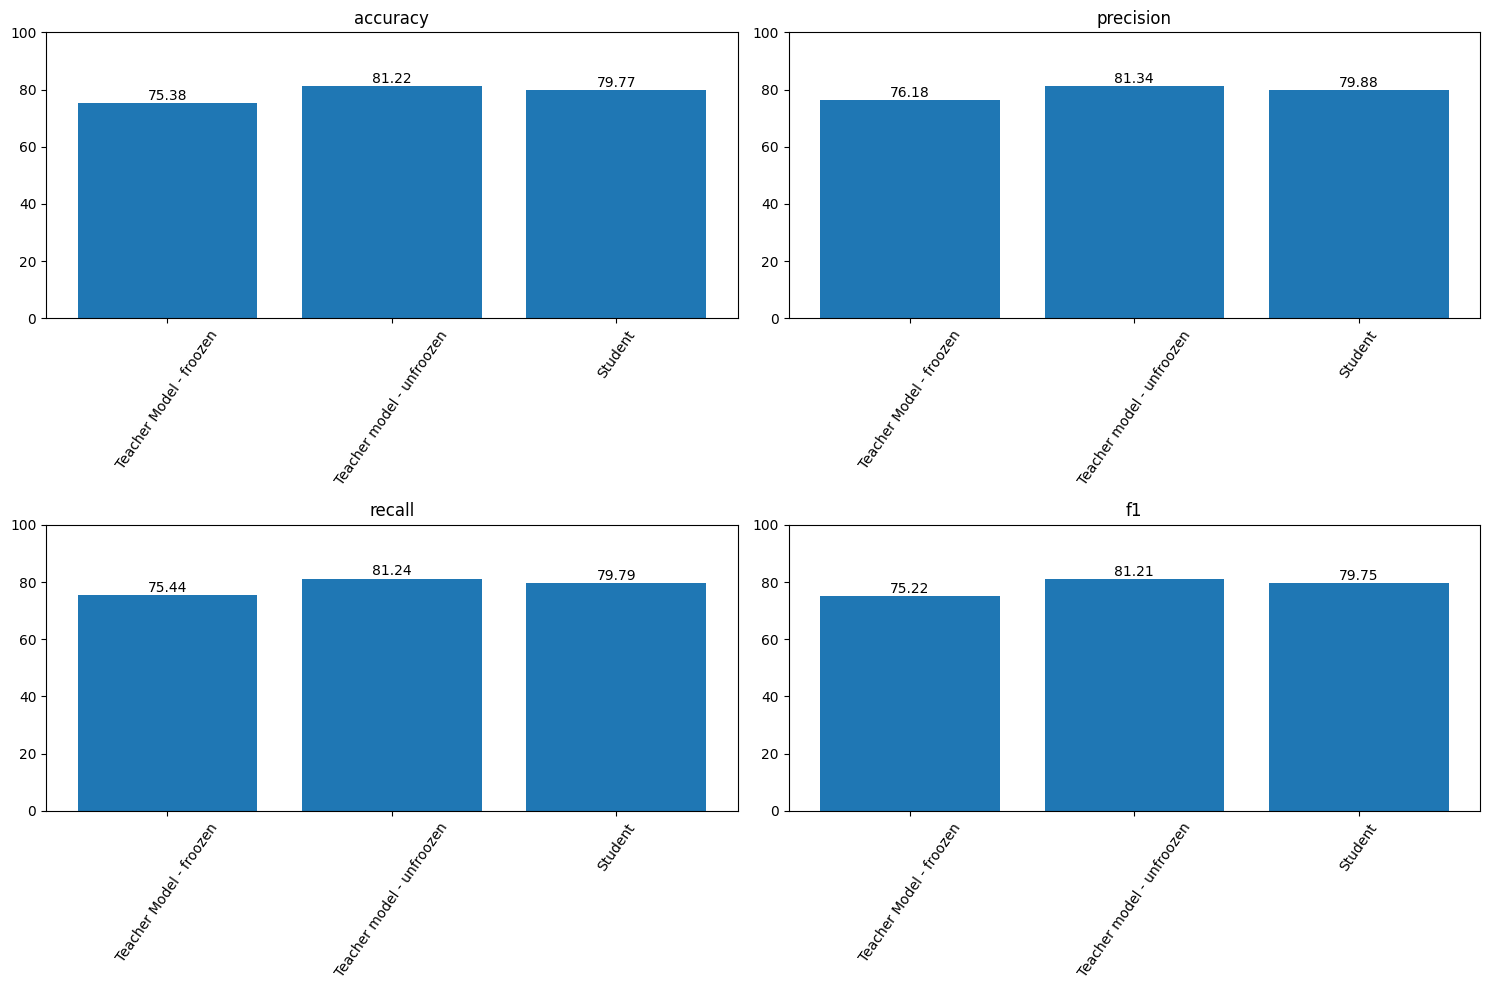

In [60]:
# get the final metrics
student_metrics.run(test_labels, valid_preds, "Student")
student_metrics.plot()

## b. Performance and Speed Comparison

In [61]:
# Execution time for the prediction of the same amount of labels:
print(f"Execution time: {teacher_time:.2f} seconds")
print(f"Execution time: {student_time:.2f} seconds")

Execution time: 35.39 seconds
Execution time: 20.00 seconds


In [62]:
teacher_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   8211840   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   0          'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [63]:
student.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   8211840   ['input_token[0][0]',         
 rtaModel)                   ngAndCrossAttentions(last_   0          'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

For our distilled model we trained our bert model using "distilbert/distilroberta-base" to improve the computational efficiency.

Comparing the our previous model, with the distilbert we can see an improvemente both in time and in memory of around a 30%. Having at the beginning around 124 million parameters on the model, we managed to reduce it to 82 million (Almost 500 MB to 310 MB) which also helped with the speed time of the model.

## c. Analysis and Improvements

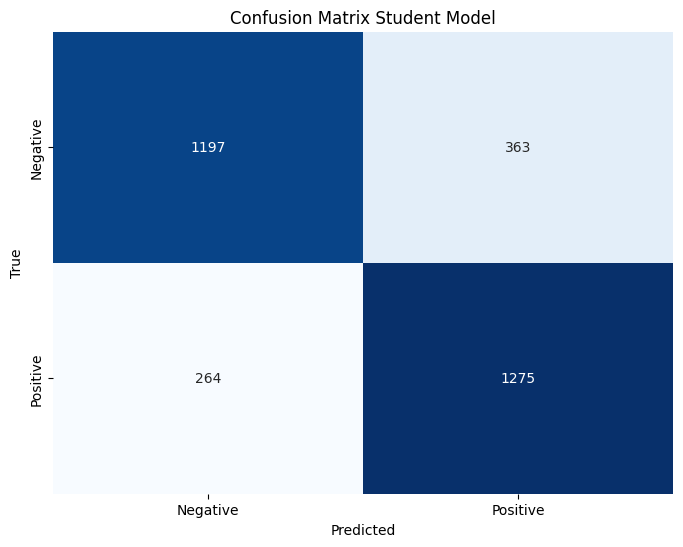

In [64]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, valid_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Student Model')
plt.show()

One of the main issues we had when running our models was computer capacity, even when using paid Google Colab, we were still limited by the amount of RAM available to use. We could try to further strengthen our model by increasing the training data and a bigger diversification of it, though as we saw in our analysis, the inclusion of more data wasn't making a huge impact on the performance of the model.